In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '', addFileNameCol = True)
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 328
The number of rows (Samples): 1845647, The number of columns: 20, number of unique sender id's: (328,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'File Name'],
      dtype='object') with 20 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [9]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 163887


In [10]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [11]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [12]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [13]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 1681760, The number of columns: 20


In [ ]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [ ]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [ ]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [ ]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [ ]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [ ]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [ ]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [ ]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [ ]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [ ]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [ ]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [ ]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Pre Processing (For Training Phase)

In [14]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [15]:
dfData['Rolling Average Amount [USD]'] = np.nan #<! Rolling average over time of all data
dfData['Time Difference Group [Sec]'] = np.nan #<! The time difference from the previous transaction of teh same user
dfData['Rolling Average Time Difference [Sec]'] = np.nan #<! The average of teh average time difference per group (Until the i-th transaction where i is the row index sorted by transaction time)


In [16]:
dfData['Rolling Average Amount [USD]'] = dfData['Amount [USD]'].cumsum() / np.arange(1.0, dfData.shape[0] + 1)
dfData.head()

Transaction ID  Transaction Time  \
905528  0x2971c7bcbf18c57a2879b07a0f6dbbc14b7c928a0335...               NaN   
905527  0xc18b50d6311d2de6f6bfd450a38291297eb0e1c96320...               NaN   
905526  0x29d0b83aeead81925d6df3a5c252bb759811fbc5bb5d...               NaN   
905525  0x292d05383a2d9150c5b24718ceef760608561469222f...               NaN   
905524  0x4020de95411dd43e8613588f07a8e9643093c8e9c9a2...               NaN   

                      Block Time                                   Sender ID  \
905528 2016-02-12 11:01:25+00:00  0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c   
905527 2016-05-11 09:23:12+00:00  0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c   
905526 2016-05-13 11:44:02+00:00  0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c   
905525 2016-05-19 07:50:40+00:00  0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c   
905524 2016-05-20 12:29:30+00:00  0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c   

                                       Receiver ID Receiver Type  Amount  \
905528  0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c        Wallet     0.5   
905527  0xbb9bc244d798123fde783fcc1c72d3bb8c189413         Token    50.0   
905526  0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28        Wallet    26.0   
905525  0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28        Wallet    50.0   
905524  0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28        Wallet   100.0   

       Currency                               Currency Hash Currency Type  \
905528      ETH  0x0000000000000000000000000000000000000000           NaN   
905527      ETH  0x0000000000000000000000000000000000000000           NaN   
905526      ETH  0x0000000000000000000000000000000000000000           NaN   
905525      ETH  0x0000000000000000000000000000000000000000           NaN   
905524      ETH  0x0000000000000000000000000000000000000000           NaN   

        ...  Gas Used  Gas Predicted  Balance In  Balance Out  Label  \
905528  ...     21000            NaN         NaN          NaN      0   
905527  ...     74091            NaN         NaN          NaN      0   
905526  ...     21000            NaN         NaN          NaN      0   
905525  ...     21000            NaN         NaN          NaN      0   
905524  ...     21000            NaN         NaN          NaN      0   

        Risk Level         File Name  Rolling Average Amount [USD]  \
905528         NaN  Furucombo006.csv                      2.737825   
905527         NaN  Furucombo006.csv                    250.901485   
905526         NaN  Furucombo006.csv                    259.010057   
905525         NaN  Furucombo006.csv                    378.236602   
905524         NaN  Furucombo006.csv                    576.462950   

        Time Difference Group [Sec] Rolling Average Time Difference [Sec]  
905528                          NaN                                   NaN  
905527                          NaN                                   NaN  
905526                          NaN                                   NaN  
905525                          NaN                                   NaN  
905524                          NaN                                   NaN  

[5 rows x 23 columns]

In [17]:

def f(df):
  #tsxAmountThr    = 8
  #tsxTimeDiffThr  = -0.99
  d = {}
  tsxAmountThr    = 8
  tsxTimeDiffThr  = -0.99
  time_str = 'Block Time'#'Transaction Time' 
  id_str = 'Receiver ID'
  rol_av_am_str ='Rolling Average Amount [USD]' ; am_str = 'Amount [USD]'
  time_diff_str = 'Time Difference Group [Sec]'
  roll_avgr_time_diff = 'Rolling Average Time Difference [Sec]'
  rule_alrt_str = 'Alert Rule'
  time_rule_str = 'Time Diff Rule'
  amount_rule_str = 'Amount Rule' 
     

  df.sort_values(time_str, inplace=True)
  for index, row in df.iterrows():
    if row[id_str] not in d:
      group_id = row[id_str]
      previous = row[time_str] ; current = row[time_str]  
      counter = 1
      time_diff = (current - previous).total_seconds()
      average = time_diff
      d[group_id] = {'current' : current, 'counter': counter , 'average' : time_diff}  
      df.at[index, time_diff_str] = time_diff
      #df.at[index, 'group_average'] = average
      

    else:
      group_id = row[id_str]
      previous = d[group_id]['current'] ; current = row[time_str]  
      counter = d[group_id]['counter'] + 1 

      time_diff = (current - previous).total_seconds()

      average = (d[group_id]['average']*(counter - 1) + time_diff) / counter

      d[group_id] = {'current' : current, 'counter': counter , 'average' : average}
      df.at[index, time_diff_str] = time_diff
      #df.at[index, 'group_average'] = average
      
      
    
    avrg =np.mean([d[gr]['average'] for gr in d.keys()])
    df.at[index, roll_avgr_time_diff] = avrg
      
  df[amount_rule_str] = ((df[am_str] - df[rol_av_am_str]) / df[rol_av_am_str]) >= tsxAmountThr
  df[time_rule_str] = ((df[time_diff_str] - df[roll_avgr_time_diff]) / df[roll_avgr_time_diff]) <= tsxTimeDiffThr
  df[rule_alrt_str] = df[amount_rule_str] & df[time_rule_str] #rule_alrt_str = 'Alert Rule'
  return df
            

        
    

In [ ]:
def func(df):
    

In [ ]:
#output = f(dfData)

In [ ]:
f(dfData)

file :  0xhabitat001.csv


recall :  0.0    precision:  0.0
file :  Agora001.csv


recall :  1.0    precision:  0.029411764705882353
file :  Agora002.csv


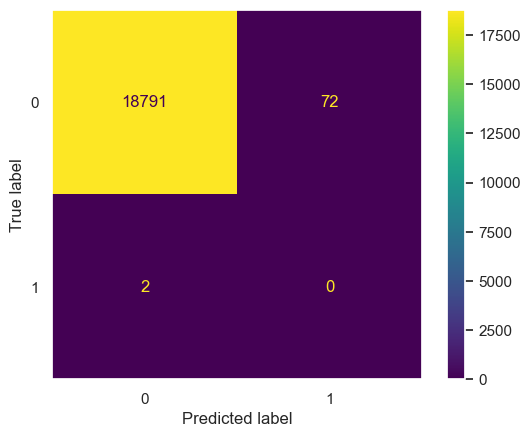

recall :  0.0    precision:  0.0
file :  Akropolis001.csv


recall :  1.0    precision:  0.3333333333333333
file :  AlphaFinance002.csv


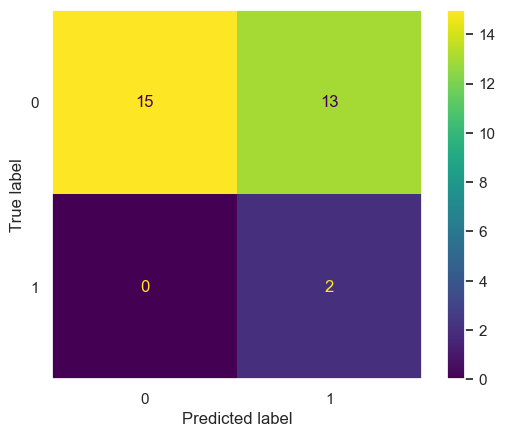

recall :  1.0    precision:  0.13333333333333333
file :  AnibusDAO001.csv


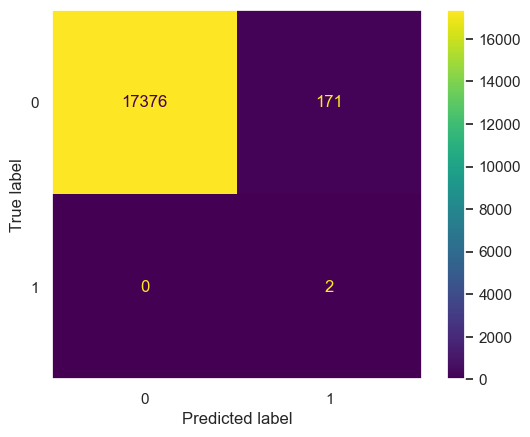

recall :  1.0    precision:  0.011560693641618497
file :  AnySwap001.csv


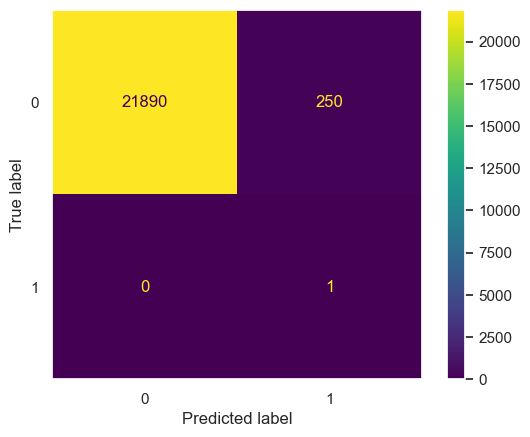

recall :  1.0    precision:  0.00398406374501992
file :  Aphrodite Protocol001.csv


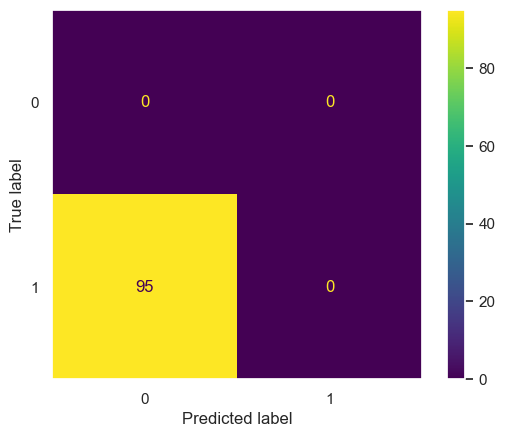

recall :  0.0    precision:  0.0
file :  Armor001.csv


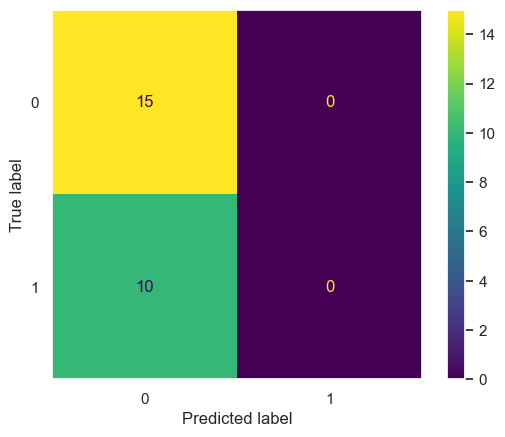

recall :  0.0    precision:  0.0
file :  ArrayFinance001.csv


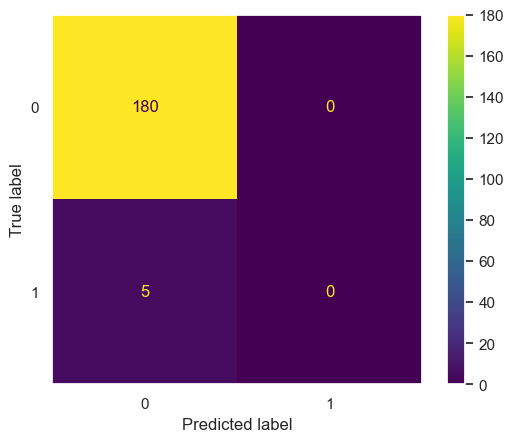

recall :  0.0    precision:  0.0
file :  AscendEX001.csv


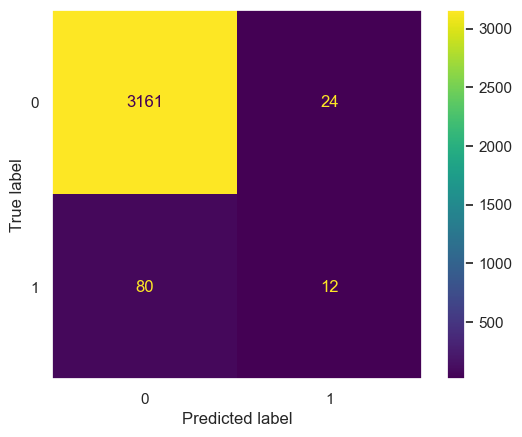

recall :  0.13043478260869565    precision:  0.3333333333333333
file :  AvageDAO001.csv


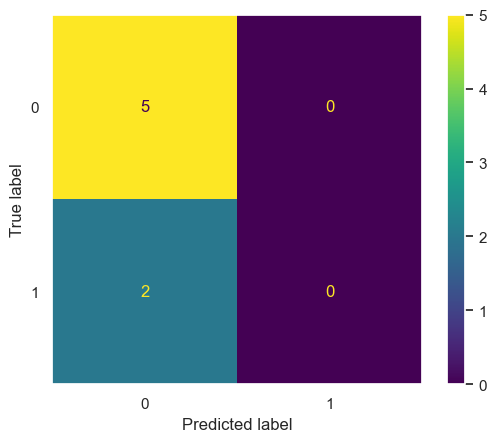

recall :  0.0    precision:  0.0
file :  Bacon Protocol001.csv


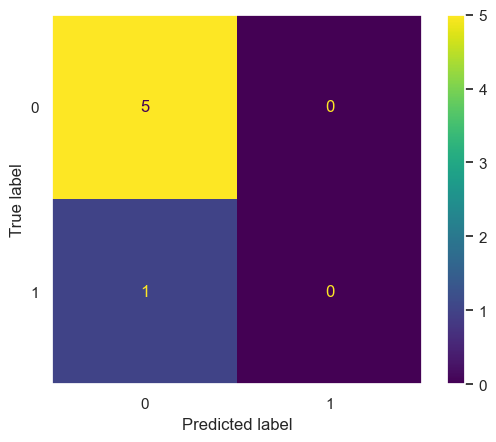

recall :  0.0    precision:  0.0
file :  BadgerDAO001.csv


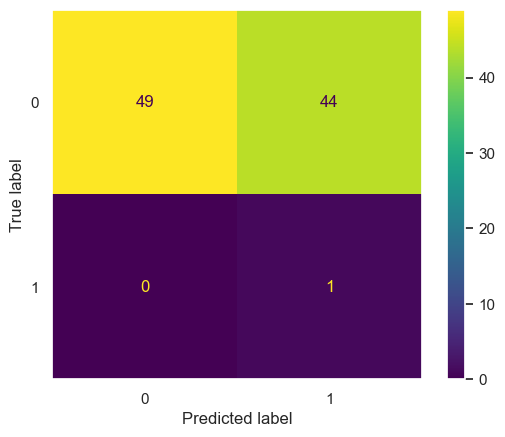

recall :  1.0    precision:  0.022222222222222223
file :  BadgerDAO002.csv


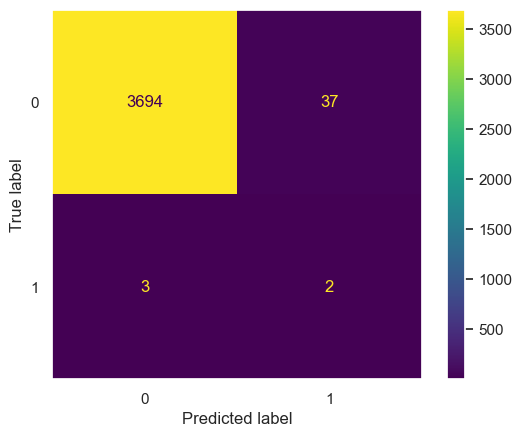

recall :  0.4    precision:  0.05128205128205128
file :  Bancor001.csv


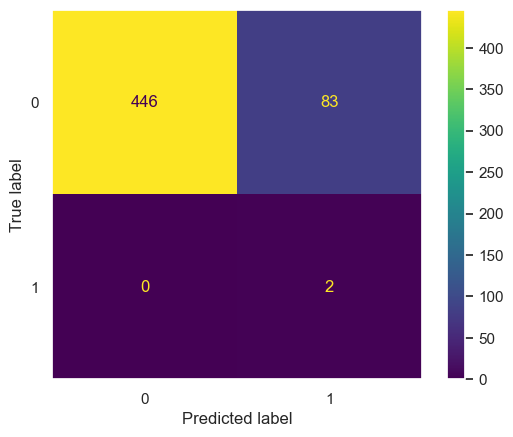

recall :  1.0    precision:  0.023529411764705882
file :  BasketDAO001.csv


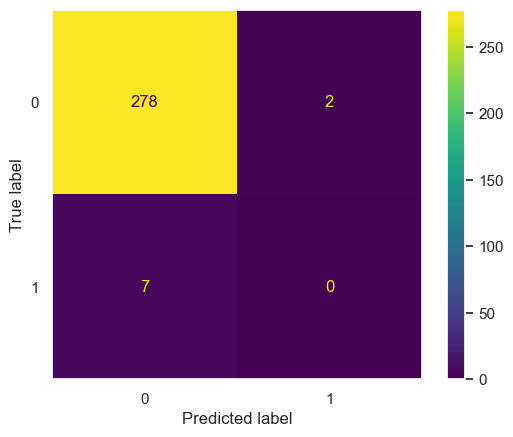

recall :  0.0    precision:  0.0
file :  BentFinance001.csv


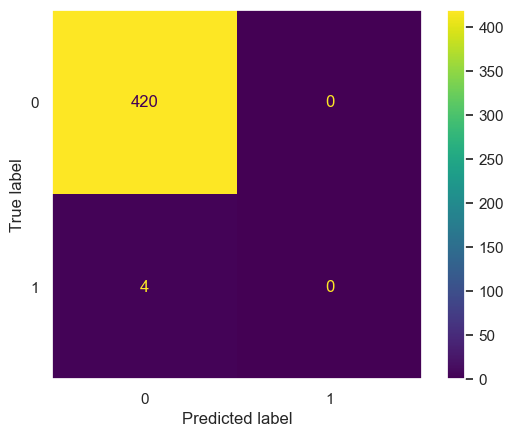

recall :  0.0    precision:  0.0
file :  Bifrost001.csv


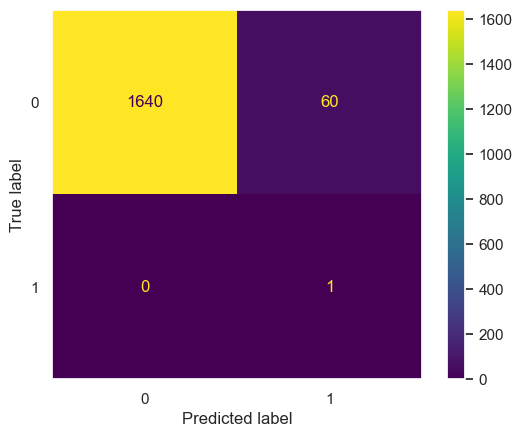

recall :  1.0    precision:  0.01639344262295082
file :  Bilaxy001.csv


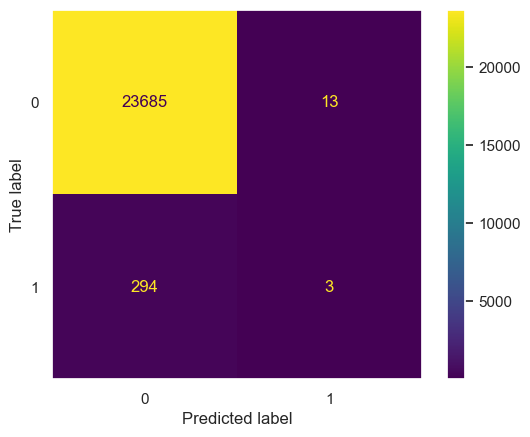

recall :  0.010101010101010102    precision:  0.1875
file :  BinaryProtocol001.csv


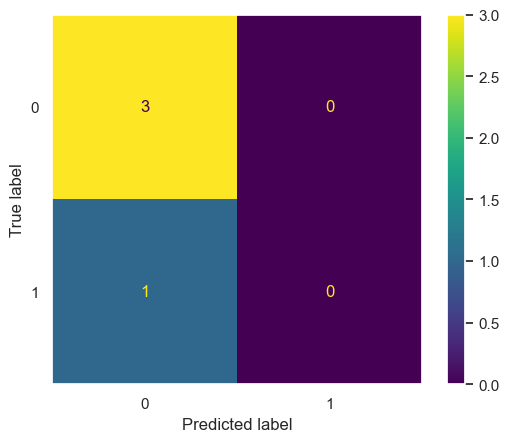

recall :  0.0    precision:  0.0
file :  Bitmart001.csv


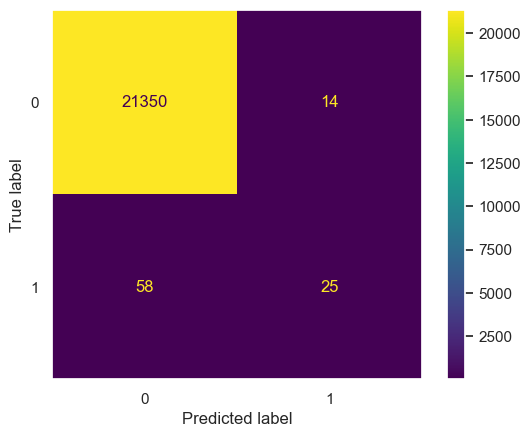

recall :  0.30120481927710846    precision:  0.6410256410256411
file :  Bitpoint001.csv


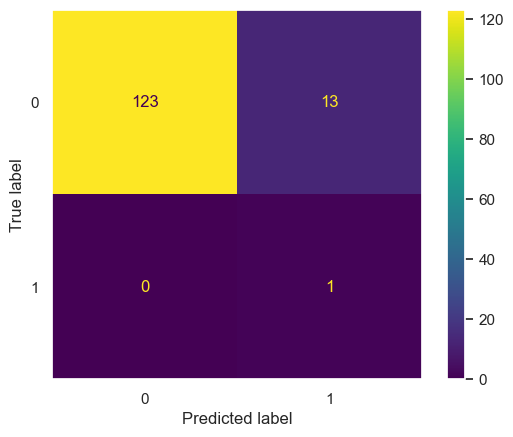

recall :  1.0    precision:  0.07142857142857142
file :  Bitpoint002.csv


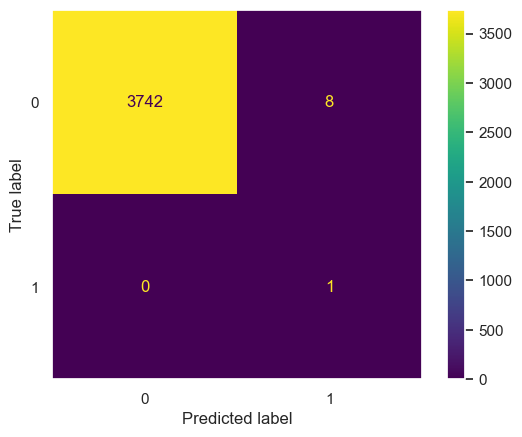

recall :  1.0    precision:  0.1111111111111111
file :  Bitpoint003.csv


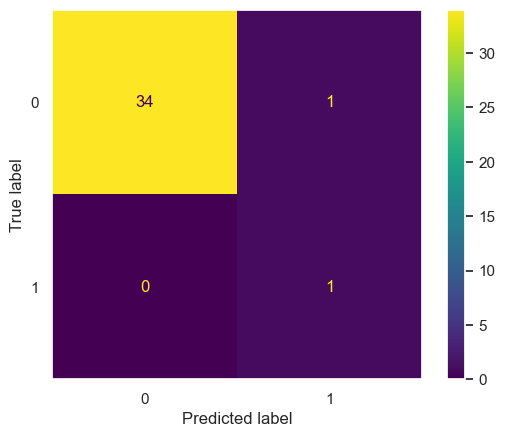

recall :  1.0    precision:  0.5
file :  Bitpoint004.csv


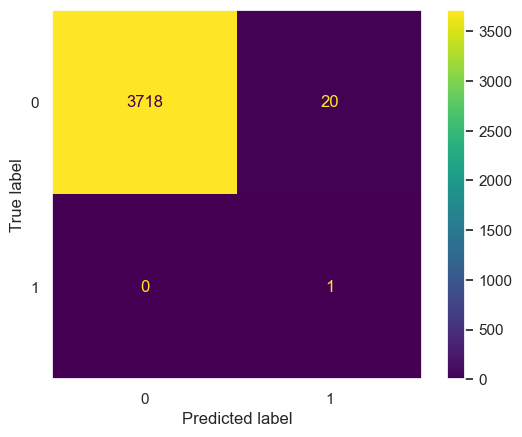

recall :  1.0    precision:  0.047619047619047616
file :  Bitpoint005.csv


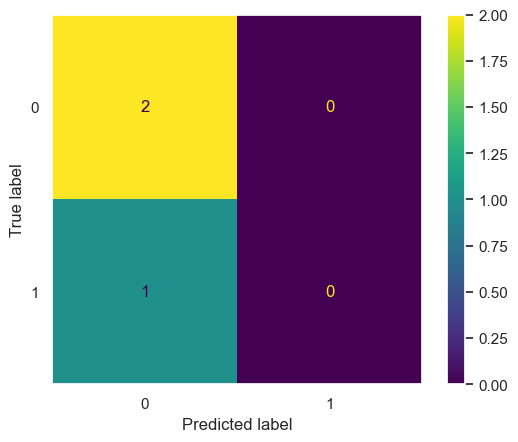

recall :  0.0    precision:  0.0
file :  Bitpoint006.csv


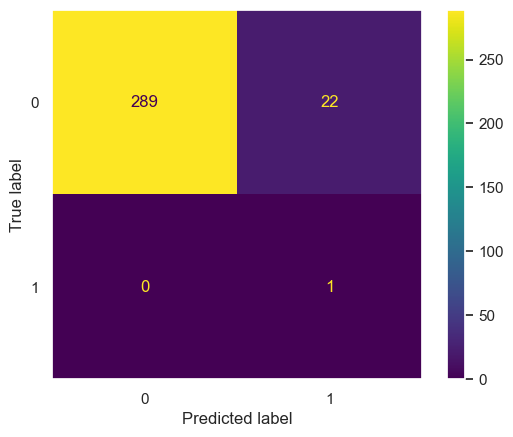

recall :  1.0    precision:  0.043478260869565216
file :  Bitpoint007.csv


recall :  0.0    precision:  0.0
file :  Bitpoint008.csv


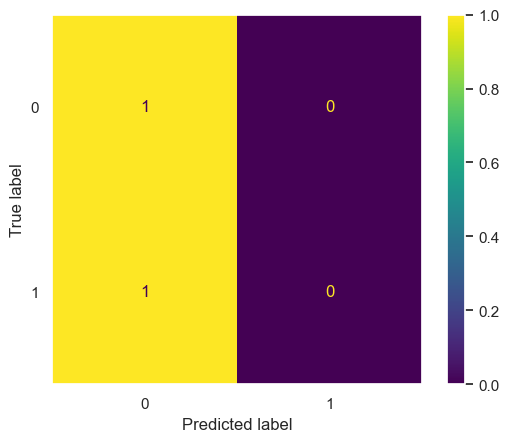

recall :  0.0    precision:  0.0
file :  Bitpoint009.csv


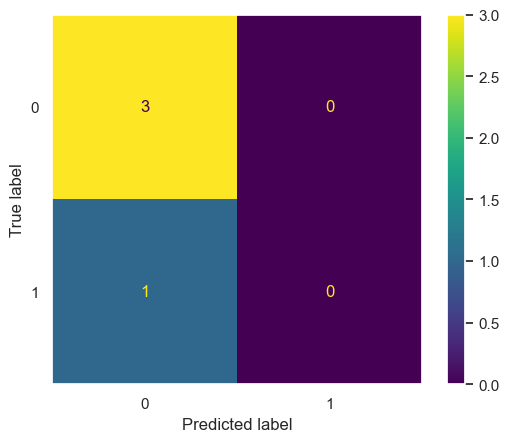

recall :  0.0    precision:  0.0
file :  Bitpoint010.csv


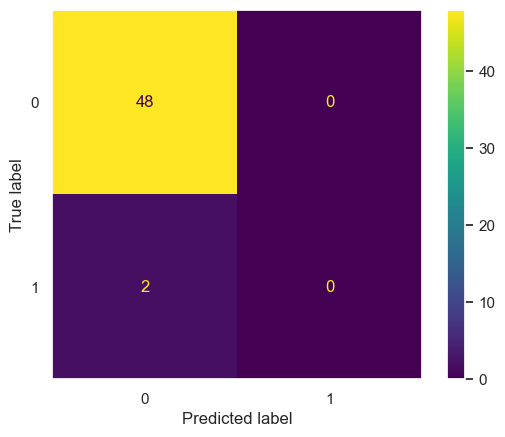

recall :  0.0    precision:  0.0
file :  Bitpoint011.csv


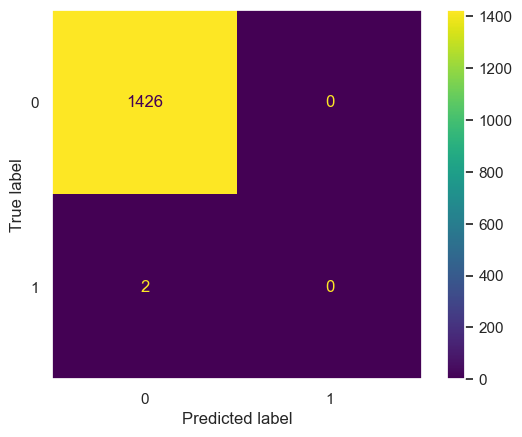

recall :  0.0    precision:  0.0
file :  Bitpoint013.csv


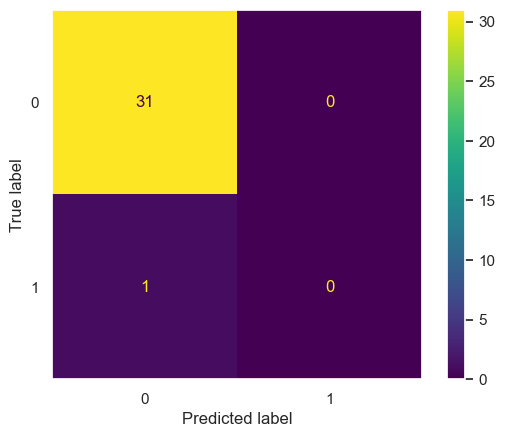

recall :  0.0    precision:  0.0
file :  Bitpoint014.csv


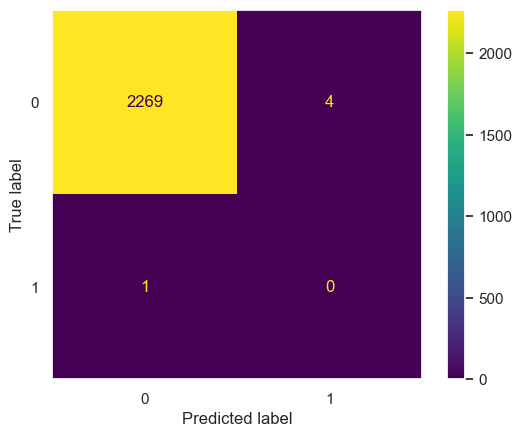

recall :  0.0    precision:  0.0
file :  Bitpoint015.csv


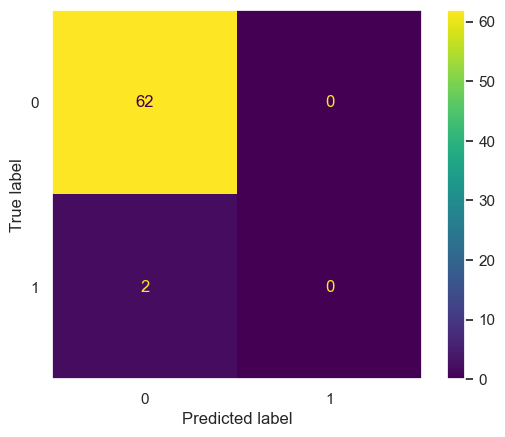

recall :  0.0    precision:  0.0
file :  Bitpoint016.csv


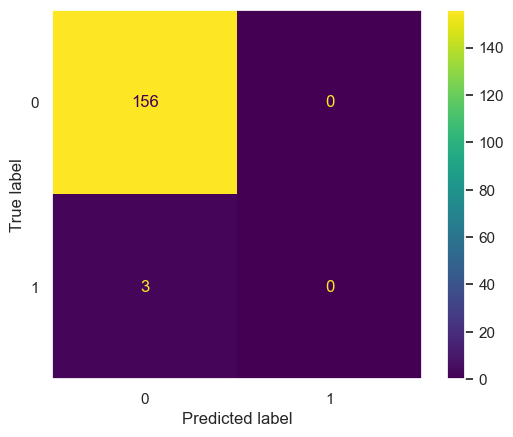

recall :  0.0    precision:  0.0
file :  Bitpoint017.csv


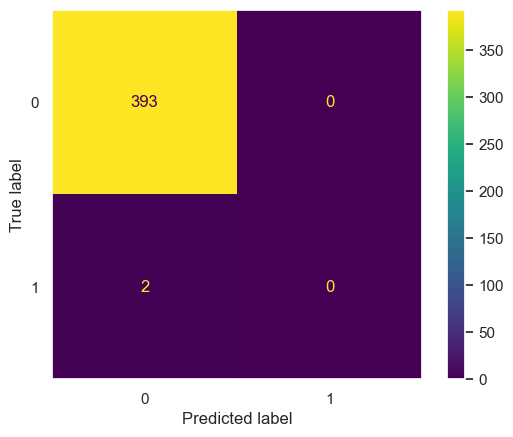

recall :  0.0    precision:  0.0
file :  BoredApe001.csv


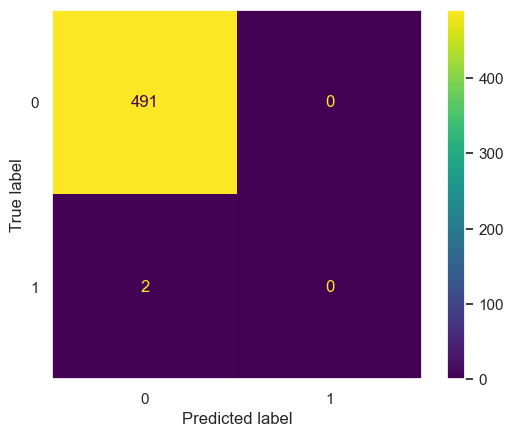

recall :  0.0    precision:  0.0
file :  BrincFinance001.csv


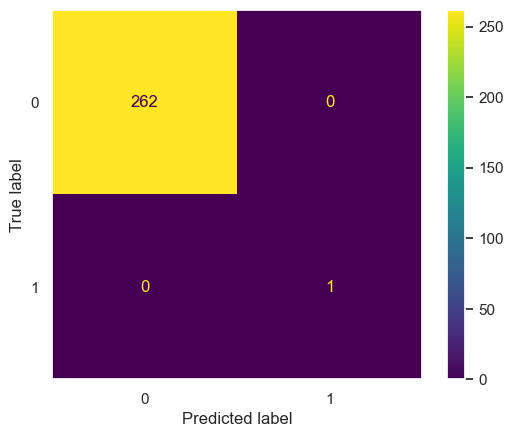

recall :  1.0    precision:  1.0
file :  BrincFinance002.csv


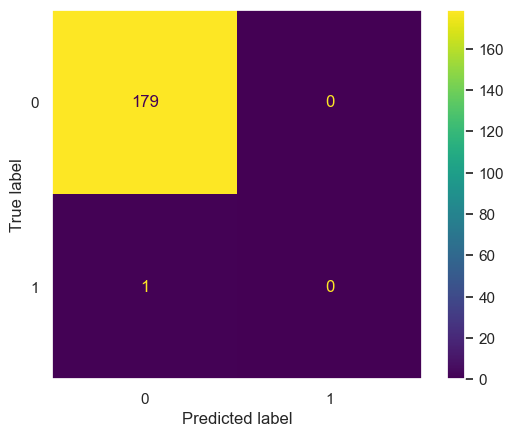

recall :  0.0    precision:  0.0
file :  BuildFinance001.csv


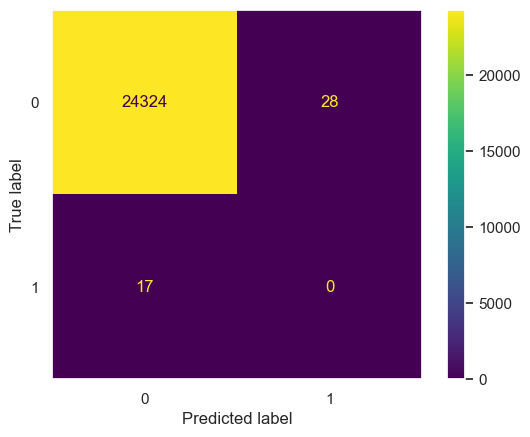

recall :  0.0    precision:  0.0
file :  BuildFinance002.csv


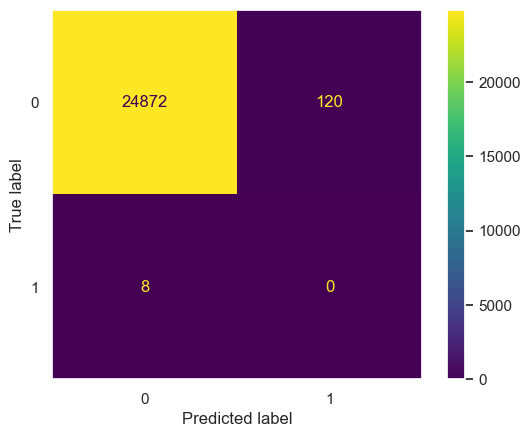

recall :  0.0    precision:  0.0
file :  BunnyFinance001.csv


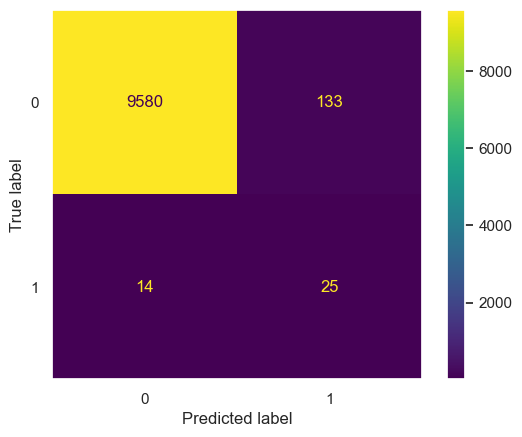

recall :  0.6410256410256411    precision:  0.15822784810126583
file :  CashioApp001.csv


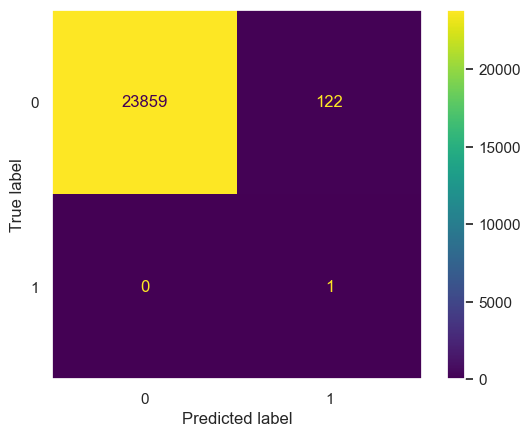

recall :  1.0    precision:  0.008130081300813009
file :  ChainPort001.csv


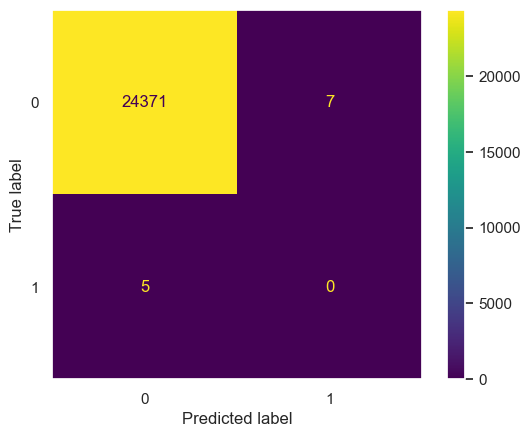

recall :  0.0    precision:  0.0
file :  ChainSwap001.csv


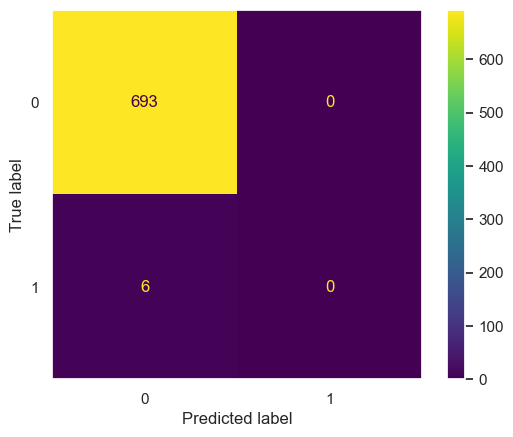

recall :  0.0    precision:  0.0
file :  ChainSwap002.csv


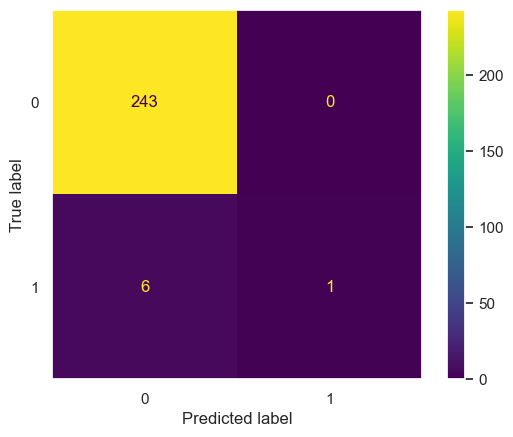

recall :  0.14285714285714285    precision:  1.0
file :  ChainSwap003.csv


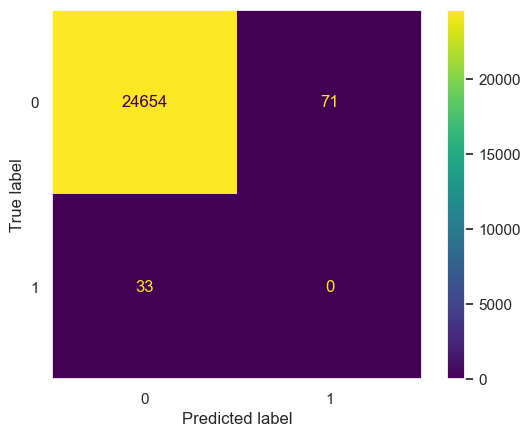

recall :  0.0    precision:  0.0
file :  ChainSwap004.csv


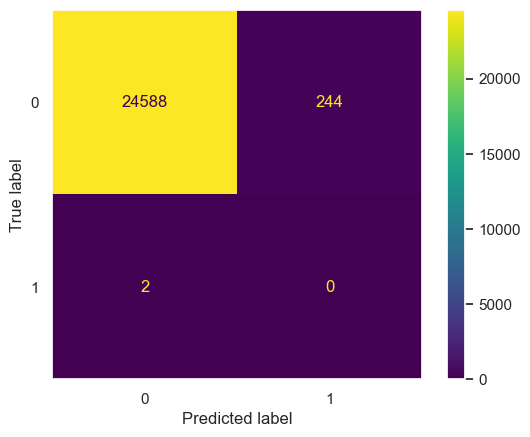

recall :  0.0    precision:  0.0
file :  ChainSwap005.csv


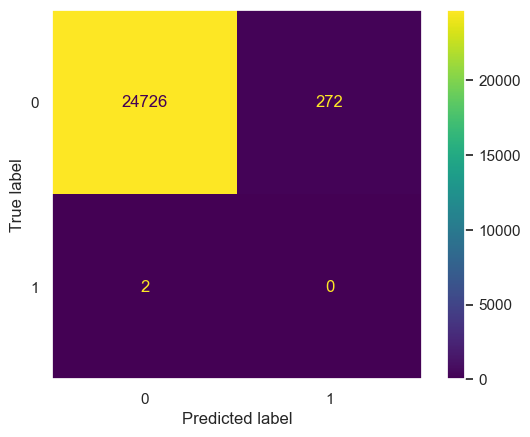

recall :  0.0    precision:  0.0
file :  ChainSwap006.csv


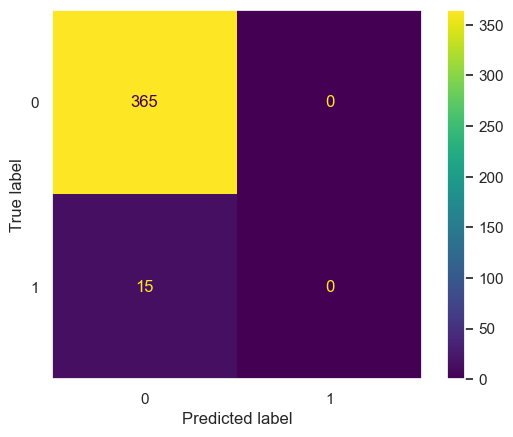

recall :  0.0    precision:  0.0
file :  CoinSWOP001.csv


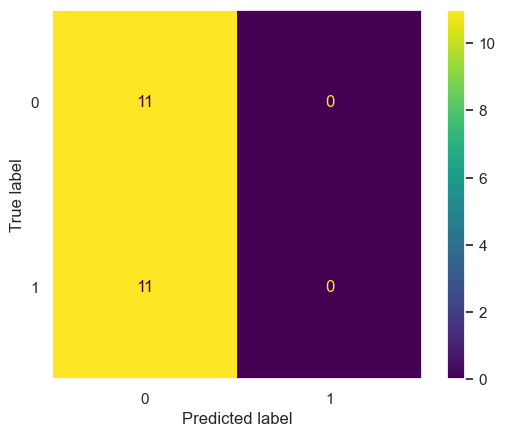

recall :  0.0    precision:  0.0
file :  Coinbene001.csv


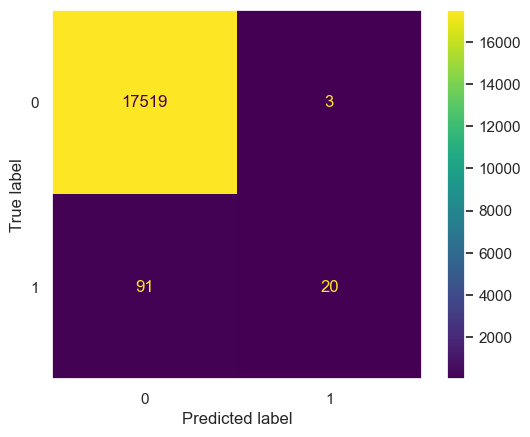

recall :  0.18018018018018017    precision:  0.8695652173913043
file :  Coinbene002.csv


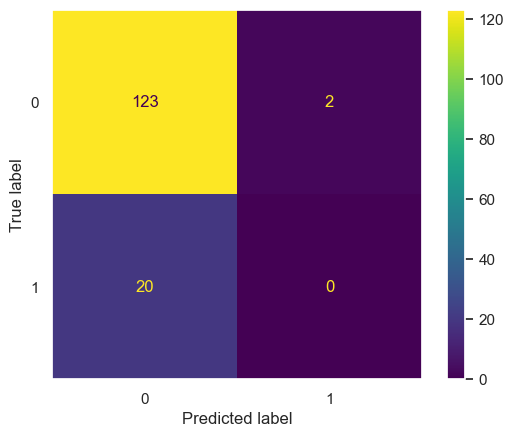

recall :  0.0    precision:  0.0
file :  Coinrail001.csv


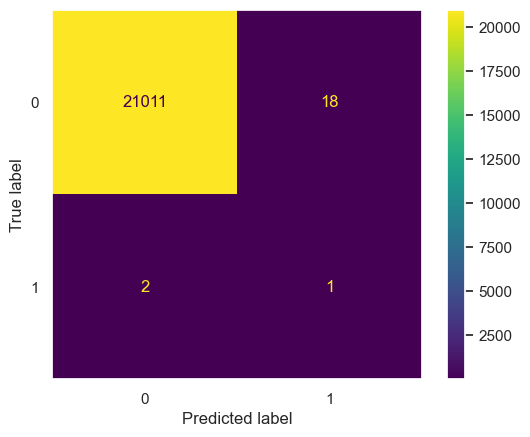

recall :  0.3333333333333333    precision:  0.05263157894736842
file :  CompounderFinance001.csv


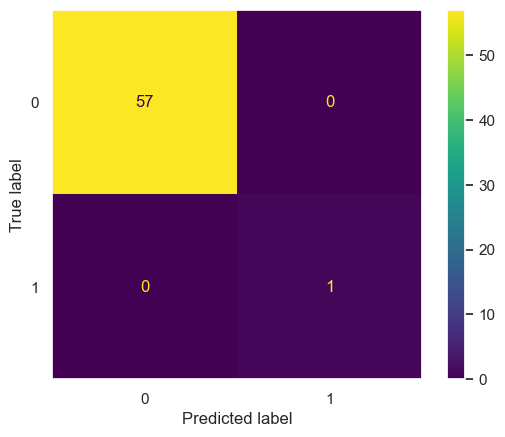

recall :  1.0    precision:  1.0
file :  CompounderFinance004.csv


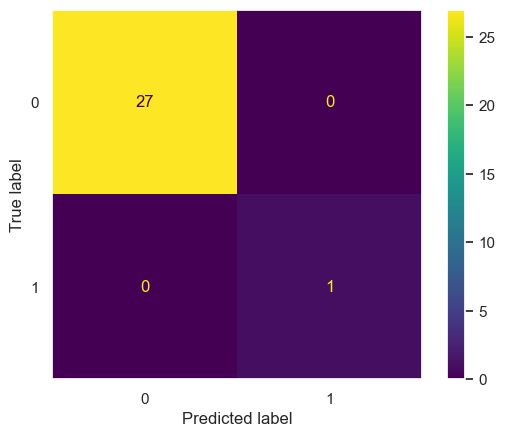

recall :  1.0    precision:  1.0
file :  CompounderFinance005.csv


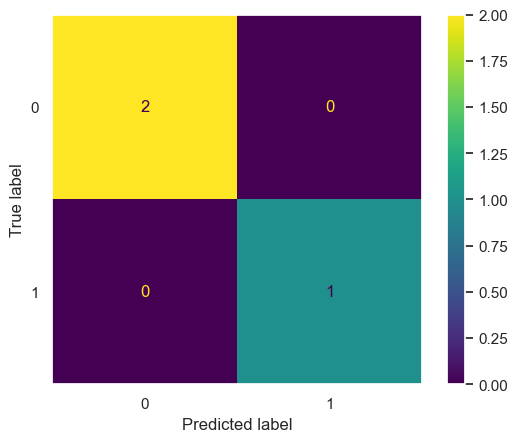

recall :  1.0    precision:  1.0
file :  CompounderFinance006.csv


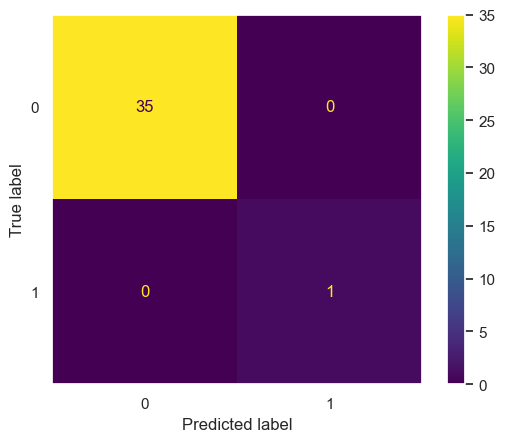

recall :  1.0    precision:  1.0
file :  CompounderFinance007.csv


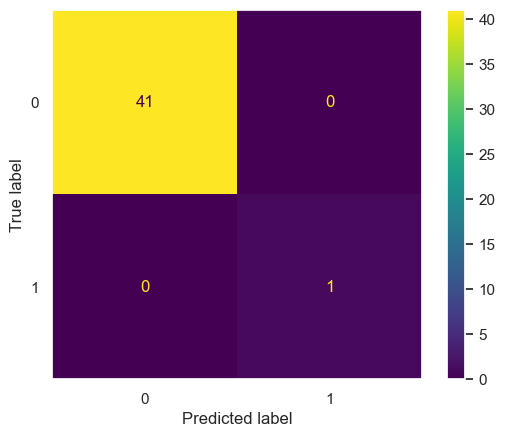

recall :  1.0    precision:  1.0
file :  CompounderFinance008.csv


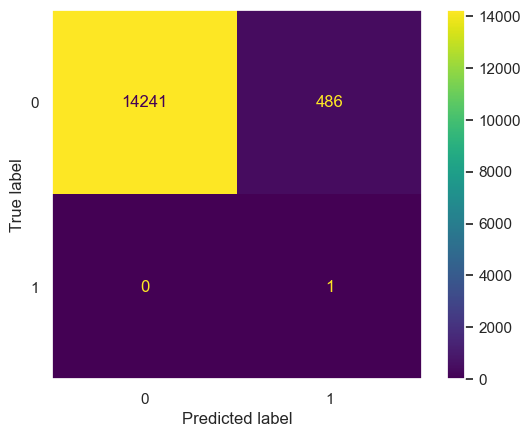

recall :  1.0    precision:  0.002053388090349076
file :  ConvexFinance001.csv


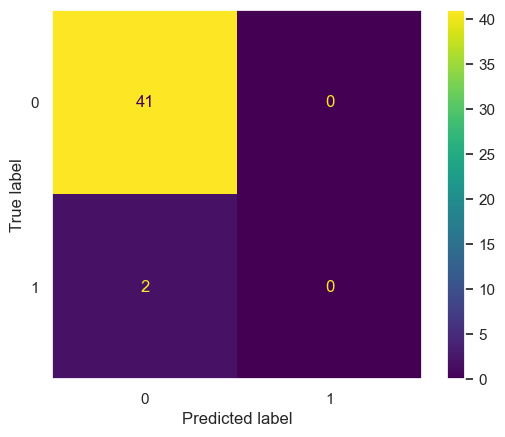

recall :  0.0    precision:  0.0
file :  CoverProtocol001.csv


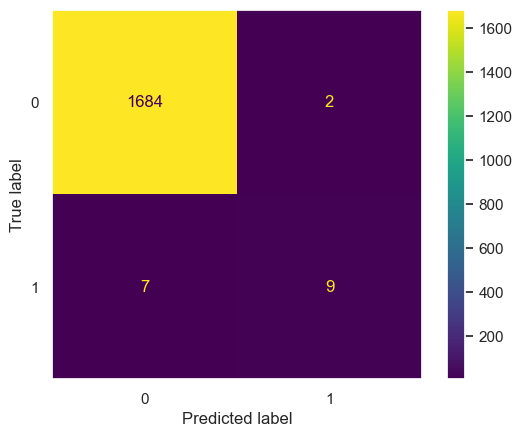

recall :  0.5625    precision:  0.8181818181818182
file :  CreamFinance004.csv


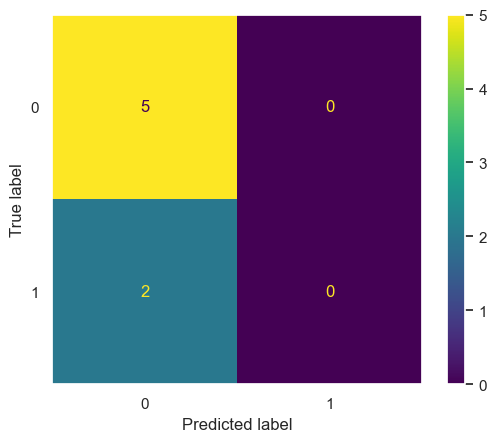

recall :  0.0    precision:  0.0
file :  CreamFinance005.csv


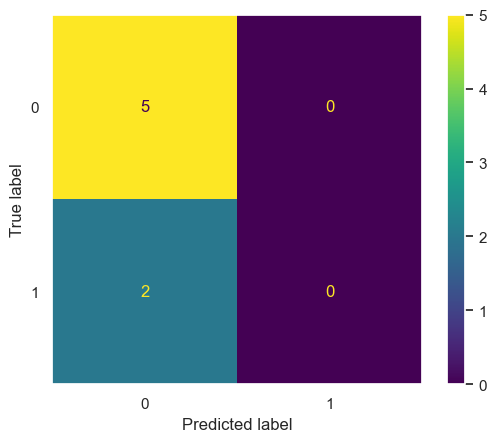

recall :  0.0    precision:  0.0
file :  CreamFinance006.csv


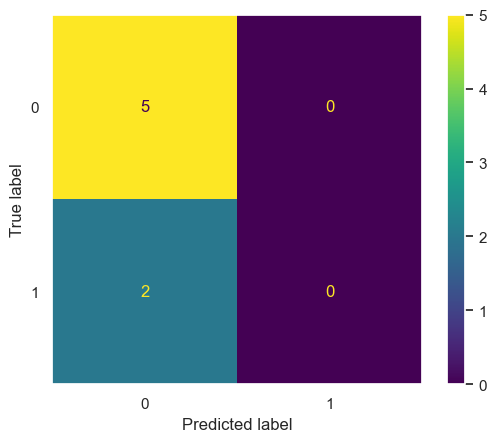

recall :  0.0    precision:  0.0
file :  CreamFinance007.csv


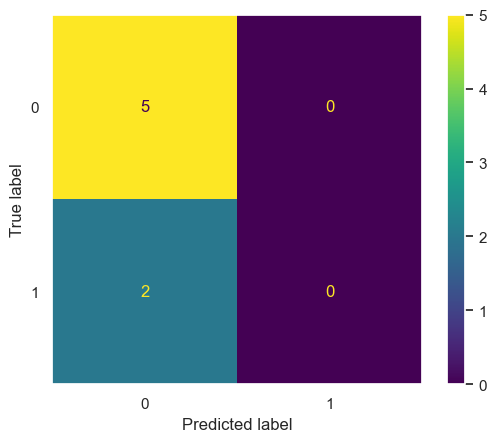

recall :  0.0    precision:  0.0
file :  CreamFinance008.csv


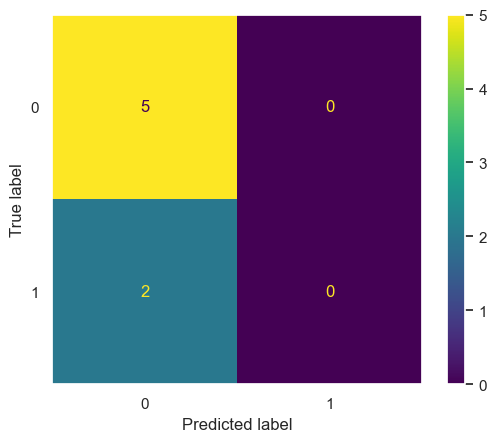

recall :  0.0    precision:  0.0
file :  CreamFinance009.csv


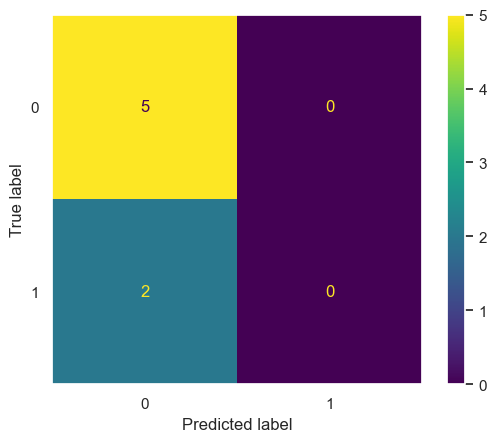

recall :  0.0    precision:  0.0
file :  CreamFinance010.csv


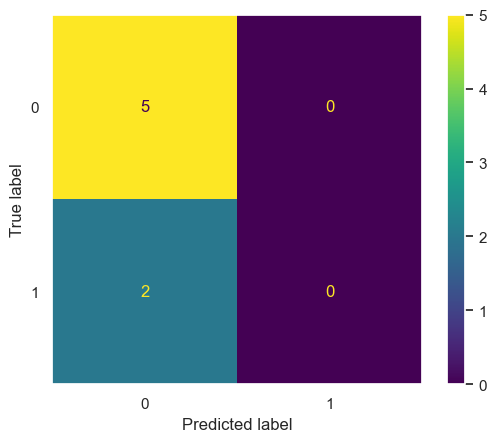

recall :  0.0    precision:  0.0
file :  CreamFinance011.csv


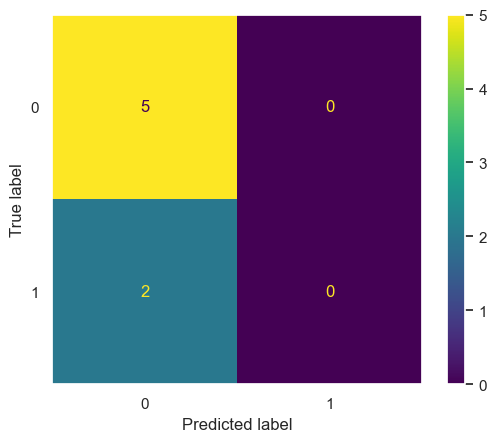

recall :  0.0    precision:  0.0
file :  Cryptopia001.csv


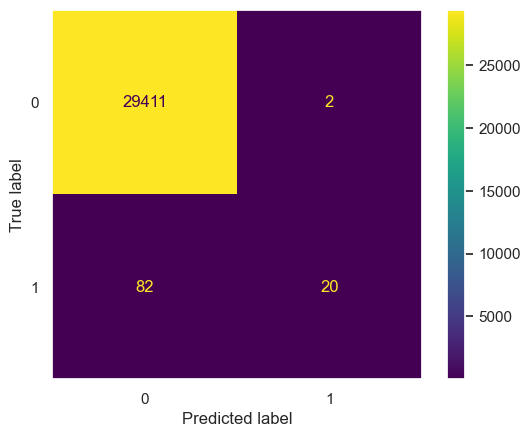

recall :  0.19607843137254902    precision:  0.9090909090909091
file :  Curve DNS001.csv


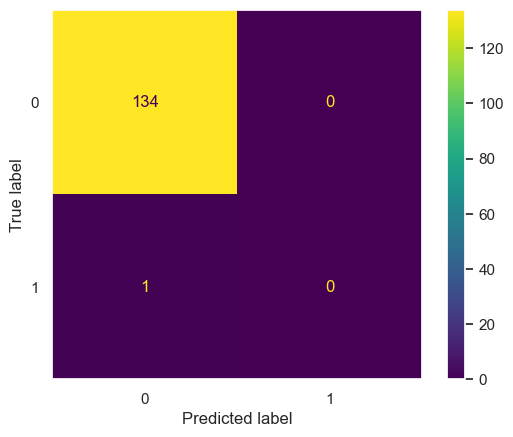

recall :  0.0    precision:  0.0
file :  Curve DNS002.csv


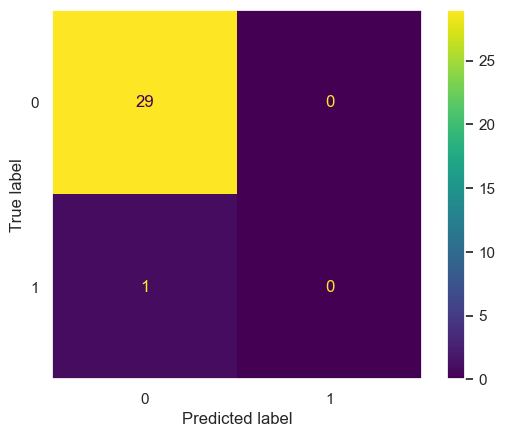

recall :  0.0    precision:  0.0
file :  Curve DNS003.csv


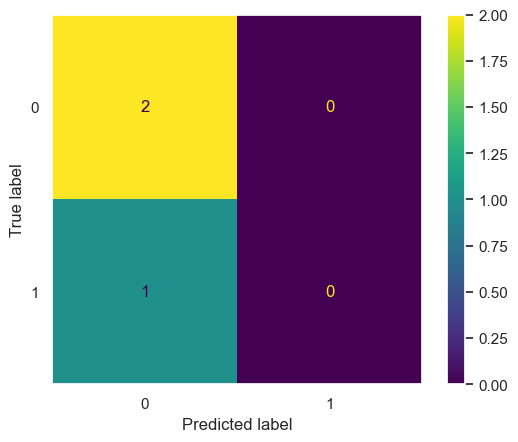

recall :  0.0    precision:  0.0
file :  Curve DNS004.csv


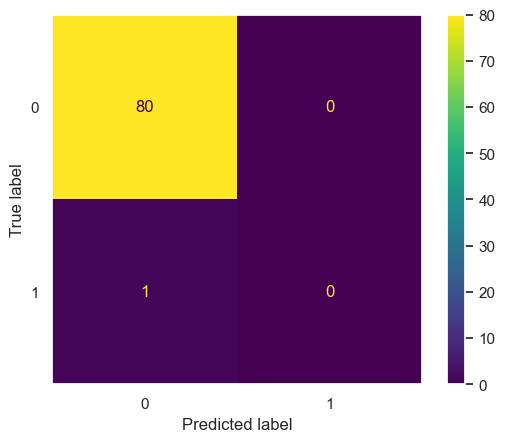

recall :  0.0    precision:  0.0
file :  Curve DNS005.csv


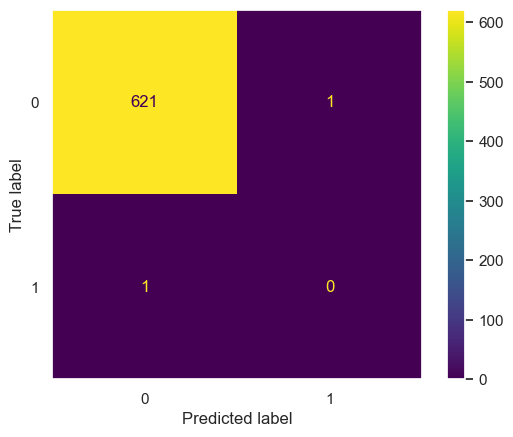

recall :  0.0    precision:  0.0
file :  DAOMaker2001.csv


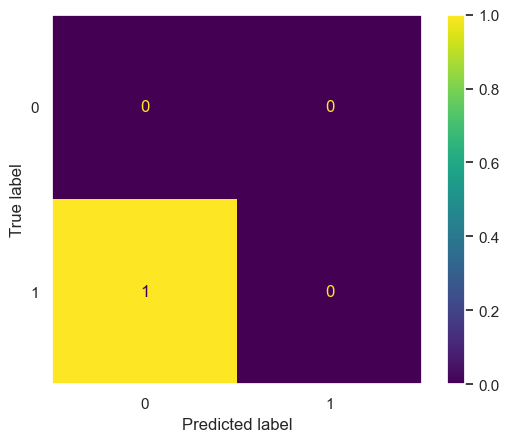

recall :  0.0    precision:  0.0
file :  DAOMaker2002.csv


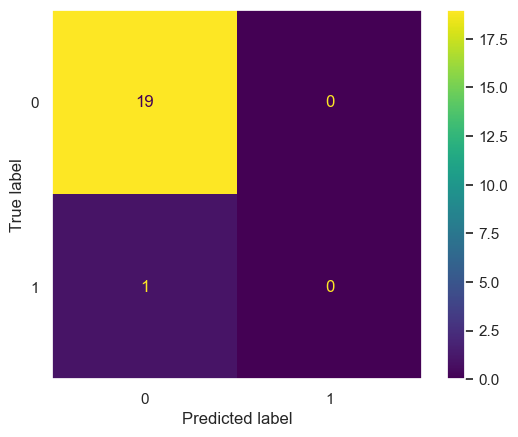

recall :  0.0    precision:  0.0
file :  DAOMaker2003.csv


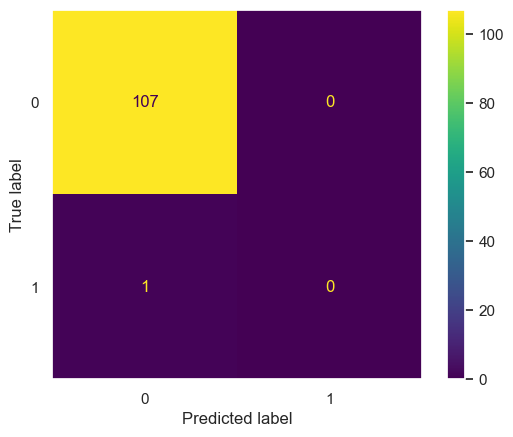

recall :  0.0    precision:  0.0
file :  DAOMaker2004.csv


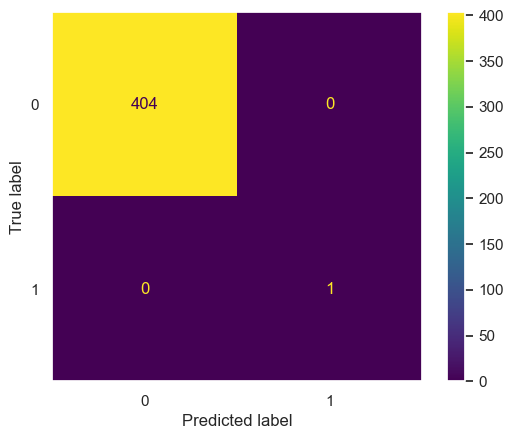

recall :  1.0    precision:  1.0
file :  DAOVentures001.csv


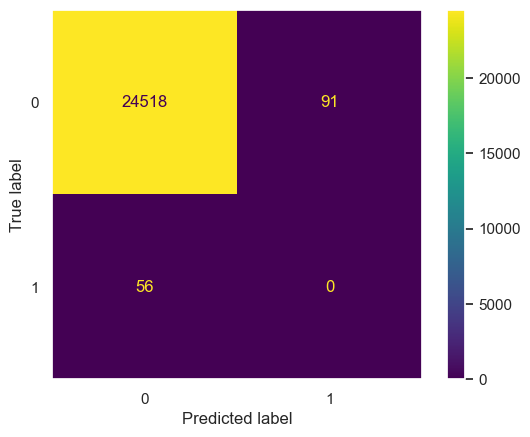

recall :  0.0    precision:  0.0
file :  DEGO001.csv


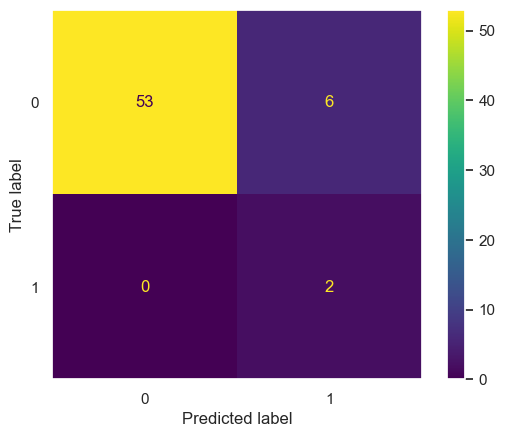

recall :  1.0    precision:  0.25
file :  DODO001.csv


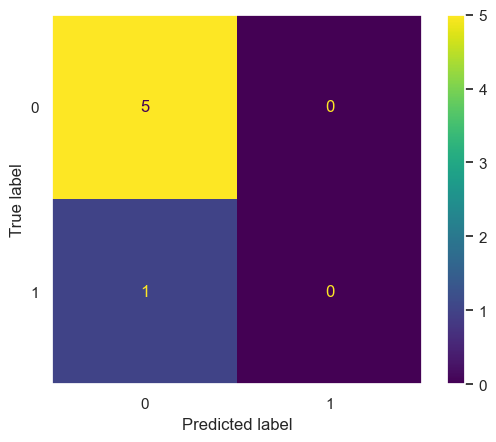

recall :  0.0    precision:  0.0
file :  DeFiPie001.csv


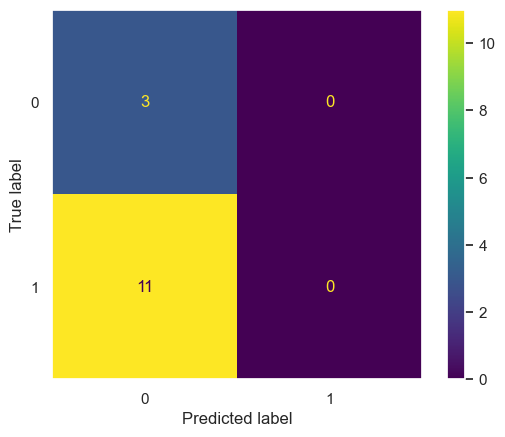

recall :  0.0    precision:  0.0
file :  DeeKay001.csv


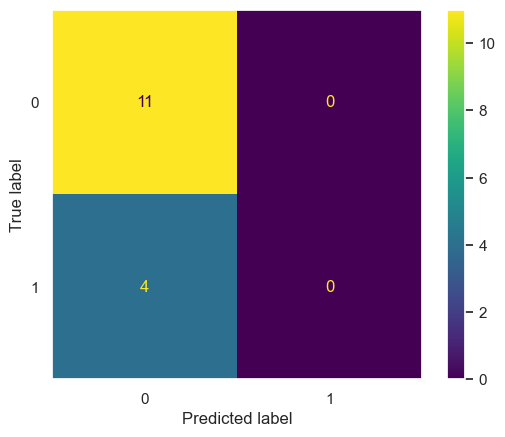

recall :  0.0    precision:  0.0
file :  Depo001.csv


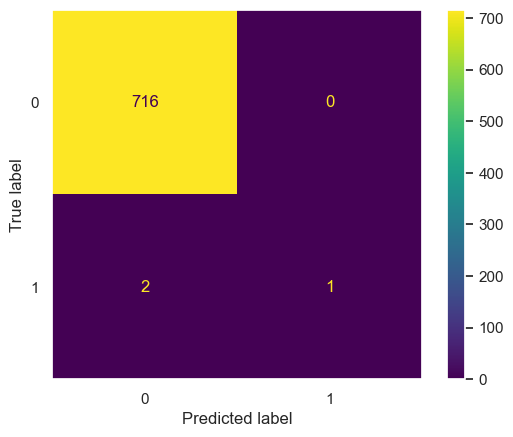

recall :  0.3333333333333333    precision:  1.0
file :  Depo002.csv


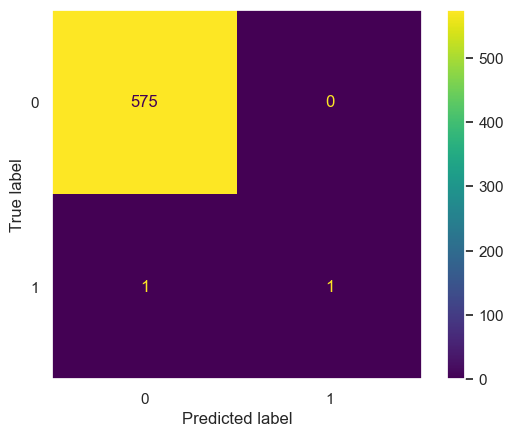

recall :  0.5    precision:  1.0
file :  Depo003.csv


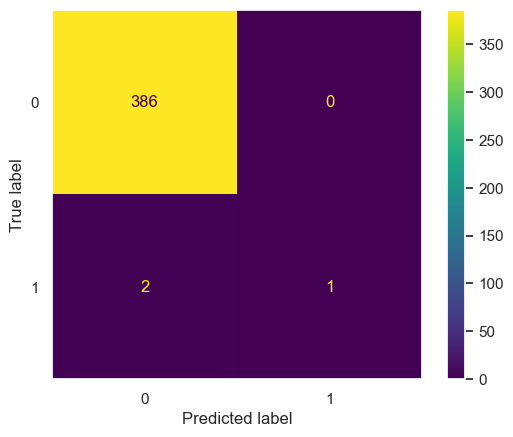

recall :  0.3333333333333333    precision:  1.0
file :  Deriswap (the 1st fake)001.csv


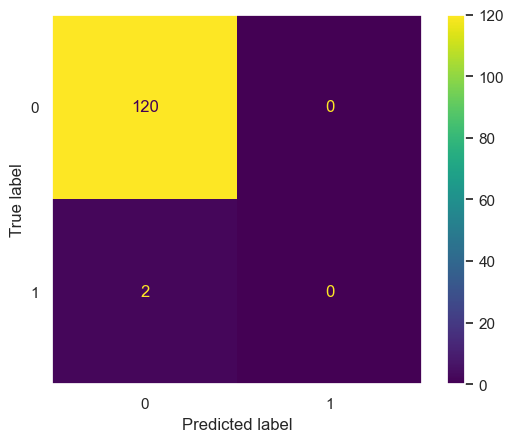

recall :  0.0    precision:  0.0
file :  DistX001.csv


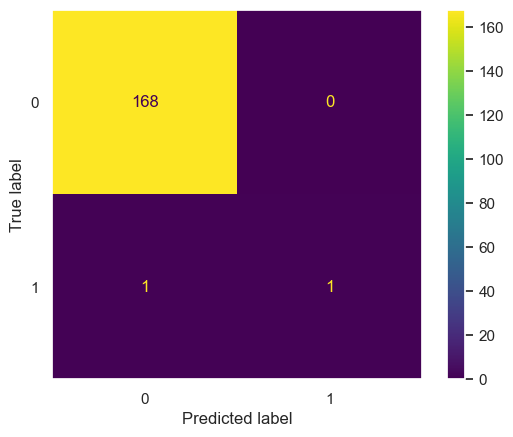

recall :  0.5    precision:  1.0
file :  DragonEx001.csv


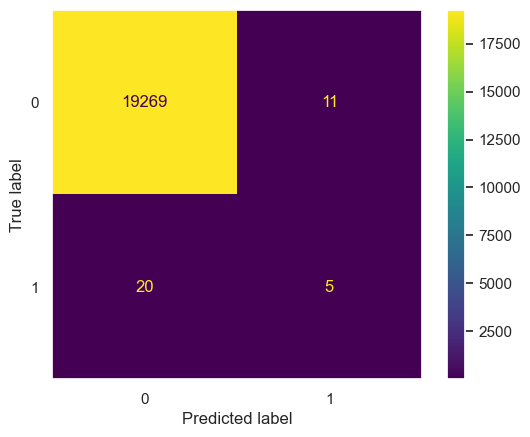

recall :  0.2    precision:  0.3125
file :  ELLA001.csv


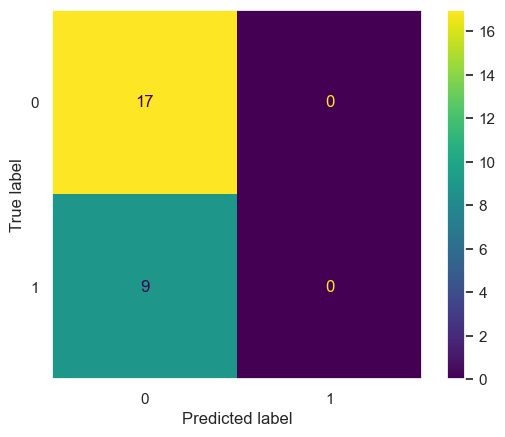

recall :  0.0    precision:  0.0
file :  EVA001.csv


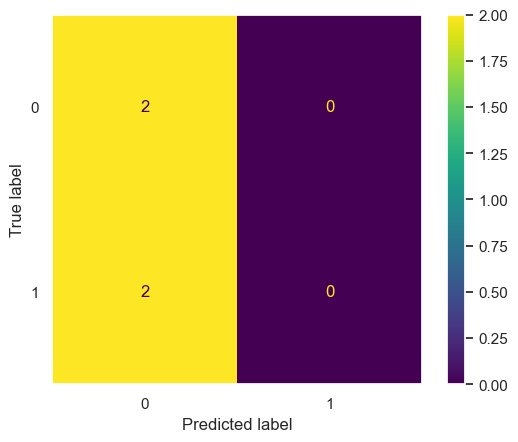

recall :  0.0    precision:  0.0
file :  EXMO001.csv


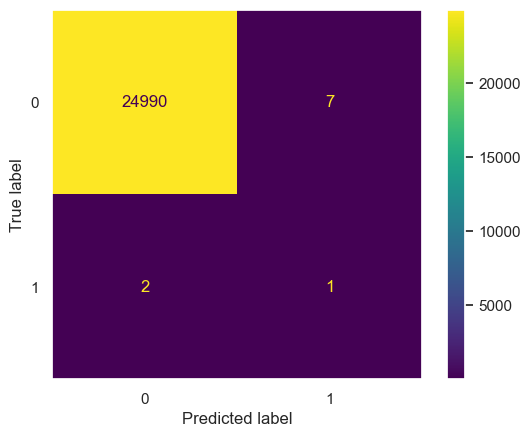

recall :  0.3333333333333333    precision:  0.125
file :  EasyFi001.csv


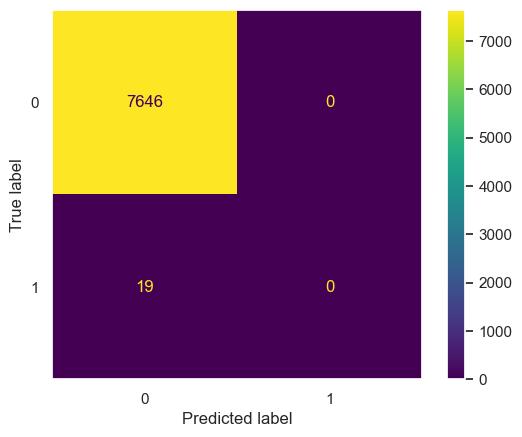

recall :  0.0    precision:  0.0
file :  EasyFi002.csv


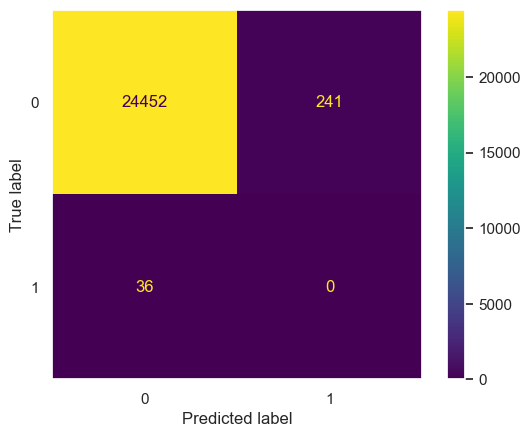

recall :  0.0    precision:  0.0
file :  EasyFi004.csv


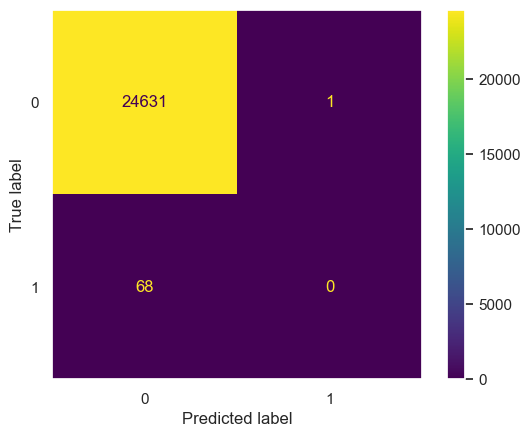

recall :  0.0    precision:  0.0
file :  EasyFi005.csv


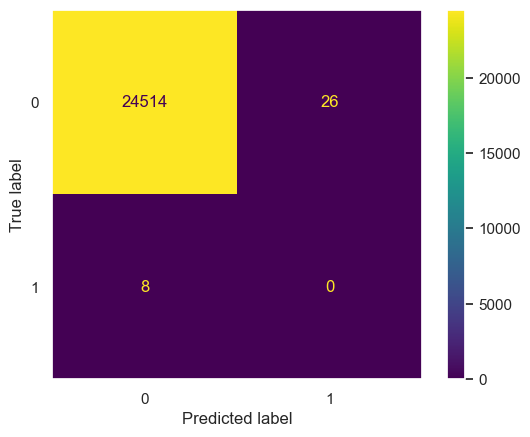

recall :  0.0    precision:  0.0
file :  EasyFi006.csv


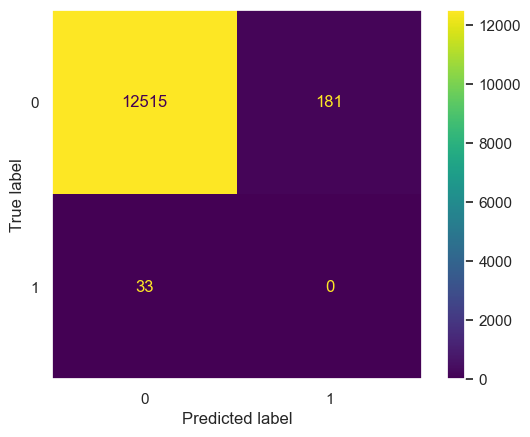

recall :  0.0    precision:  0.0
file :  EasyFi007.csv


recall :  0.0    precision:  0.0
file :  EasyFi008.csv


recall :  0.0    precision:  0.0
file :  EasyFi010.csv


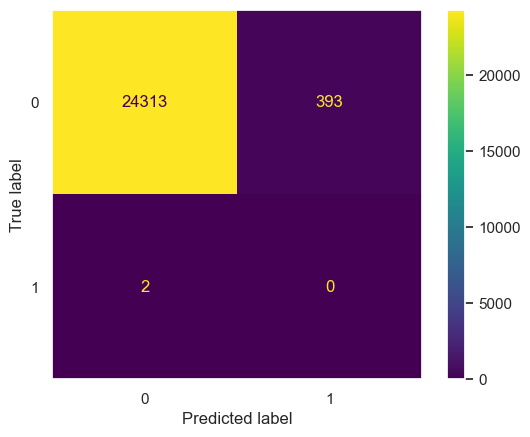

recall :  0.0    precision:  0.0
file :  EasyFi011.csv


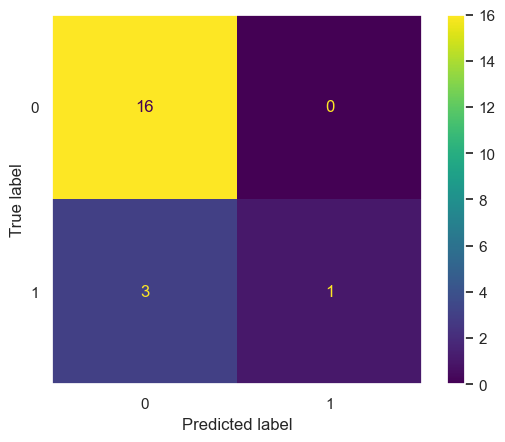

recall :  0.25    precision:  1.0
file :  EasyFi012.csv


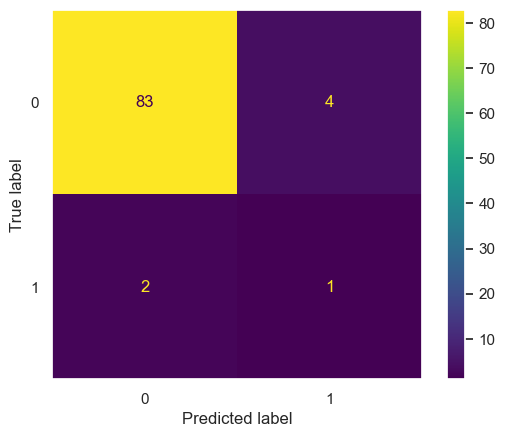

recall :  0.3333333333333333    precision:  0.2
file :  Eminence001.csv


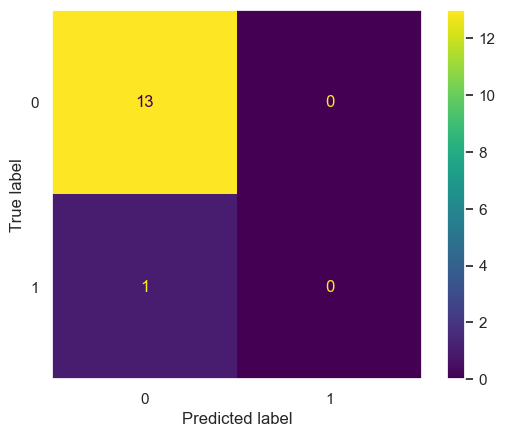

recall :  0.0    precision:  0.0
file :  Eminence002.csv


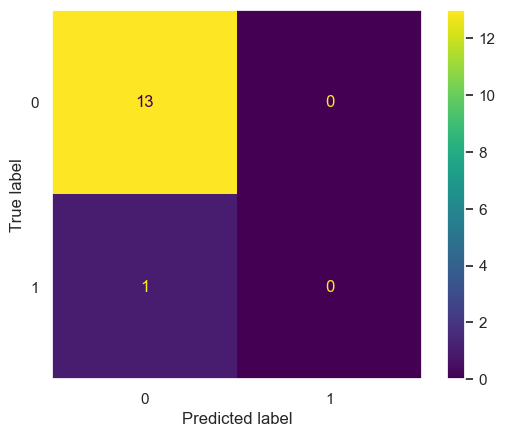

recall :  0.0    precision:  0.0
file :  Eminence003.csv


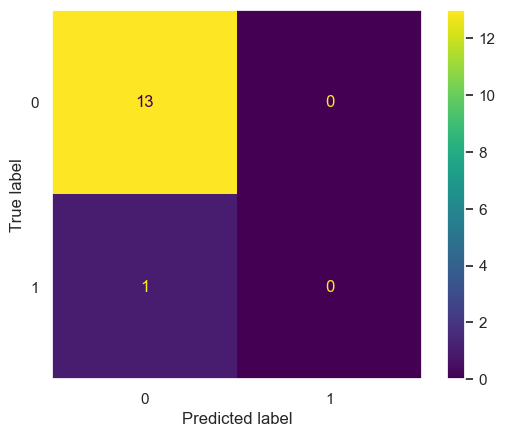

recall :  0.0    precision:  0.0
file :  Enigma001.csv


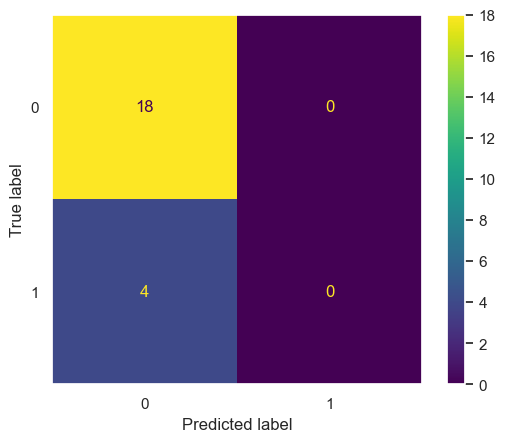

recall :  0.0    precision:  0.0
file :  Enigma002.csv


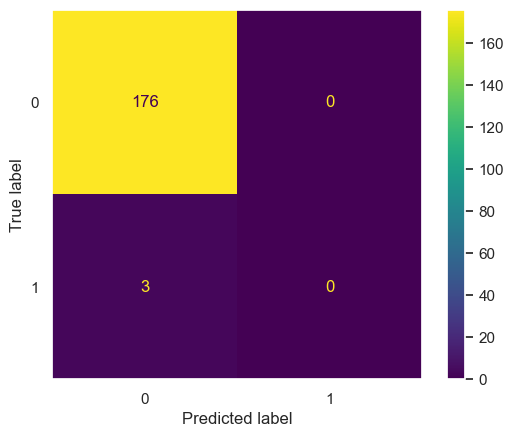

recall :  0.0    precision:  0.0
file :  Eterbase001.csv


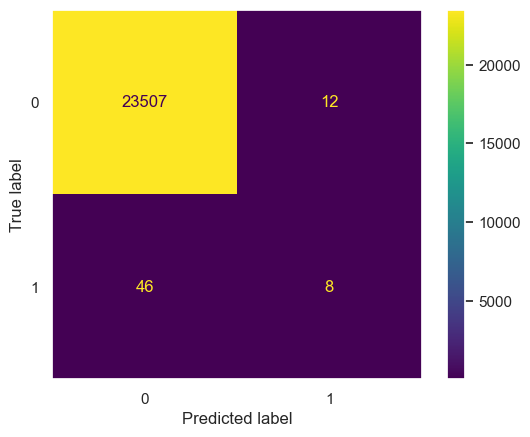

recall :  0.14814814814814814    precision:  0.4
file :  EtherCrash001.csv


recall :  0.5    precision:  0.09090909090909091
file :  EtherDelta001.csv


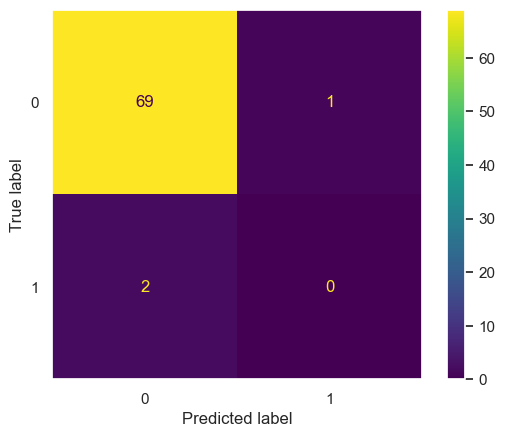

recall :  0.0    precision:  0.0
file :  EtherDelta002.csv


recall :  0.0    precision:  0.0
file :  EtherDelta003.csv


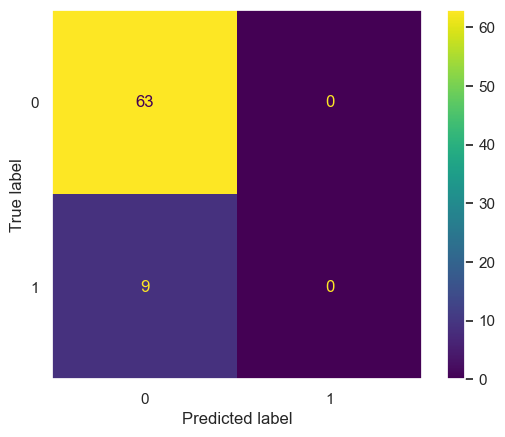

recall :  0.0    precision:  0.0
file :  EtherDelta004.csv


recall :  0.0    precision:  0.0
file :  EtherDelta005.csv


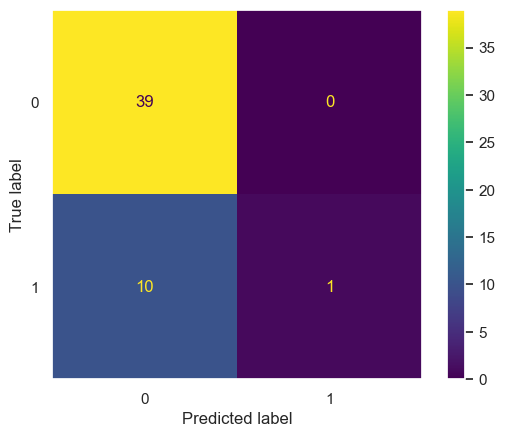

recall :  0.09090909090909091    precision:  1.0
file :  EtherDelta006.csv


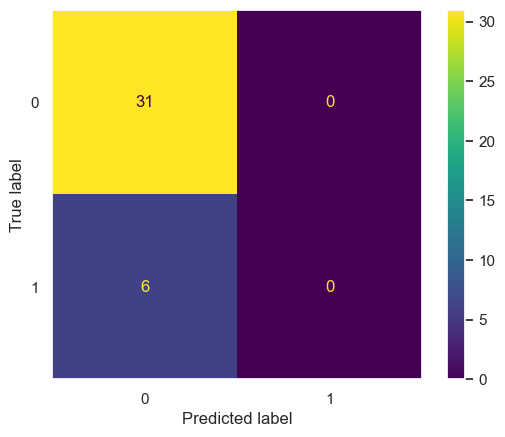

recall :  0.0    precision:  0.0
file :  EtherDelta007.csv


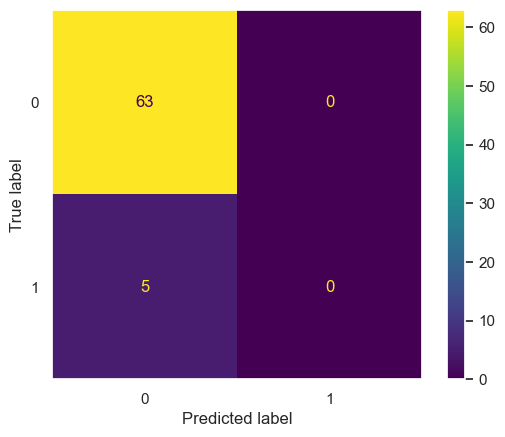

recall :  0.0    precision:  0.0
file :  EtherDelta009.csv


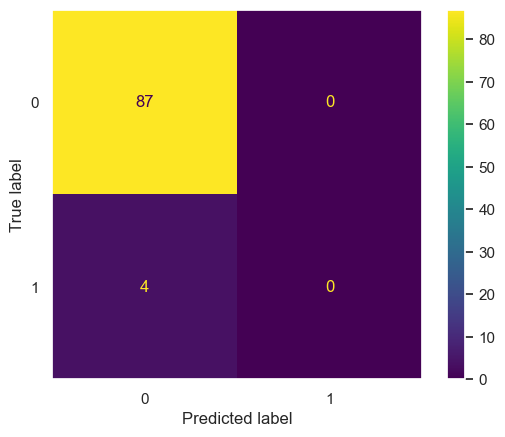

recall :  0.0    precision:  0.0
file :  EtherDelta010.csv


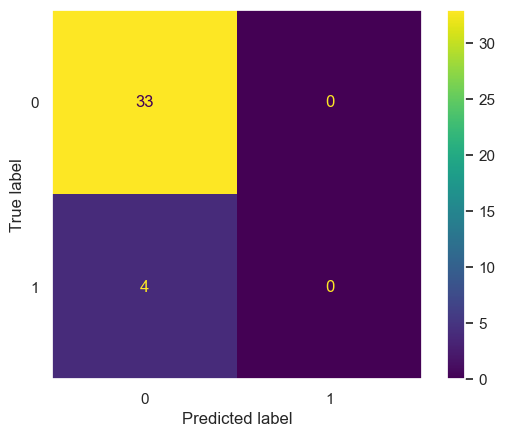

recall :  0.0    precision:  0.0
file :  EtherDelta011.csv


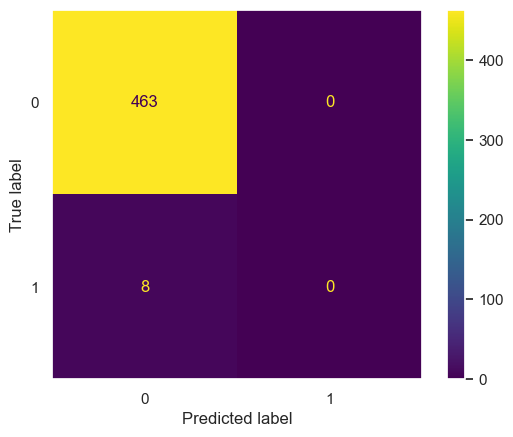

recall :  0.0    precision:  0.0
file :  EtherDelta012.csv


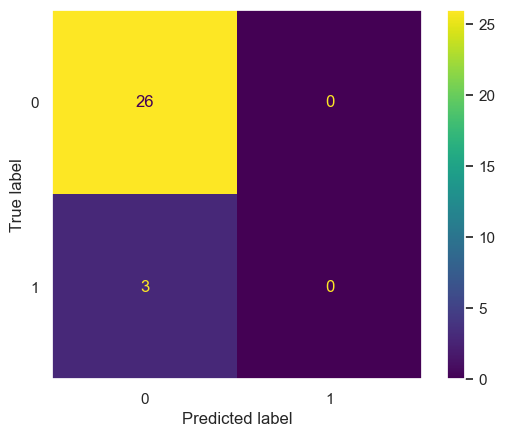

recall :  0.0    precision:  0.0
file :  EthereumYiled001.csv


recall :  0.0    precision:  0.0
file :  EthereumYiled002.csv


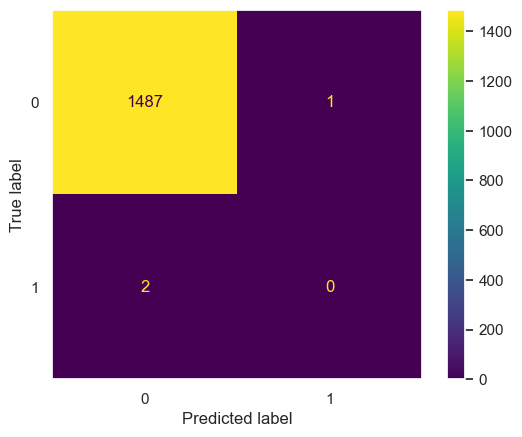

recall :  0.0    precision:  0.0
file :  FAKEFundYourselfNow001.csv


recall :  0.0    precision:  0.0
file :  FAKEFundYourselfNow002.csv


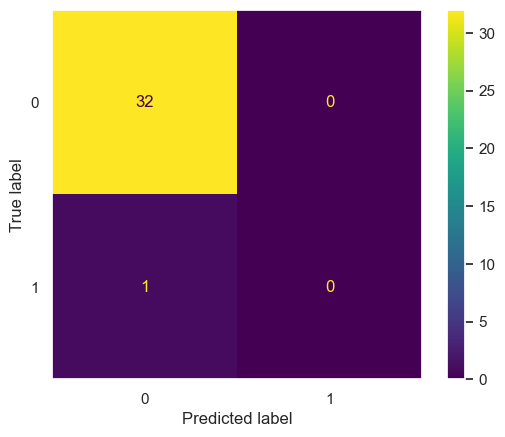

recall :  0.0    precision:  0.0
file :  FAKEFundYourselfNow003.csv


recall :  0.0    precision:  0.0
file :  FaceDAO001.csv


recall :  0.0    precision:  0.0
file :  FakeAVA Token Sale001.csv


recall :  0.0    precision:  0.0
file :  FakeDfinityTokenSale001.csv


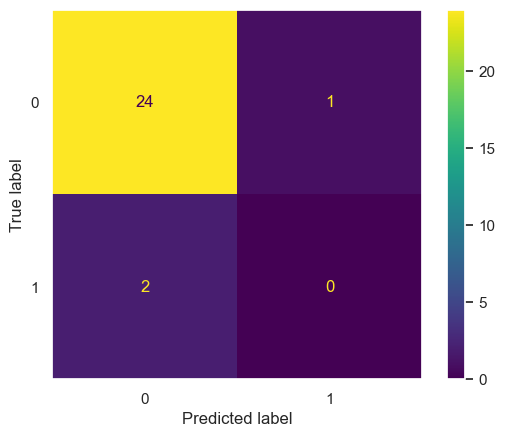

recall :  0.0    precision:  0.0
file :  FakeDfinityTokenSale002.csv


recall :  1.0    precision:  0.0070921985815602835
file :  FakeHack137001.csv


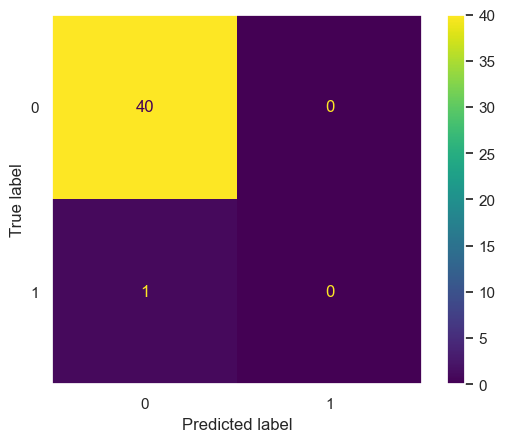

recall :  0.0    precision:  0.0
file :  FakeHeroTokenSale001.csv


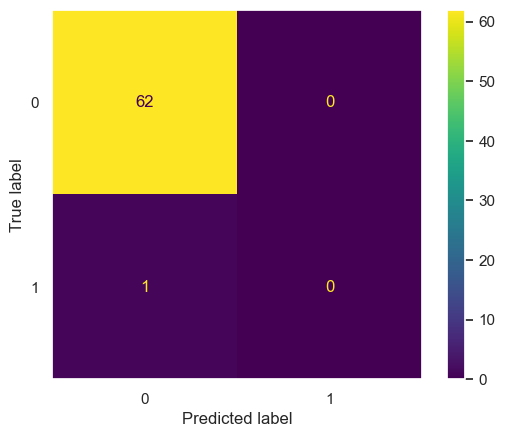

recall :  0.0    precision:  0.0
file :  FakeHeroTokenSale002.csv


recall :  0.0    precision:  0.0
file :  FakeHeroTokenSale003.csv


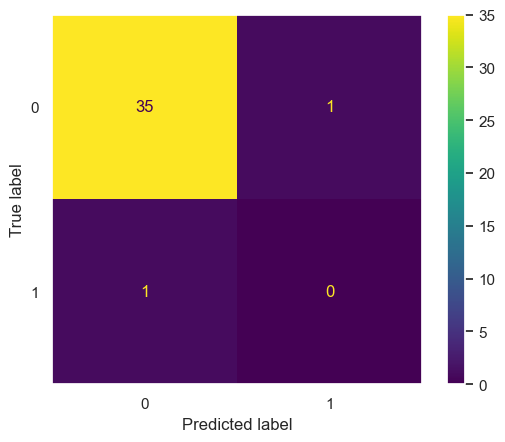

recall :  0.0    precision:  0.0
file :  FakeHeroTokenSale004.csv


recall :  0.0    precision:  0.0
file :  FakeHeroTokenSale005.csv


recall :  0.0    precision:  0.0
file :  FakeHeroTokenSale006.csv


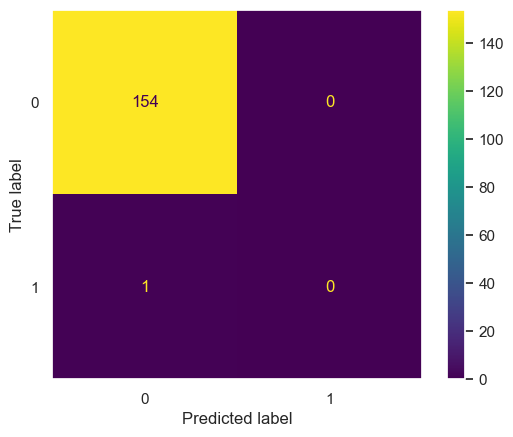

recall :  0.0    precision:  0.0
file :  FakePhishing2753001.csv


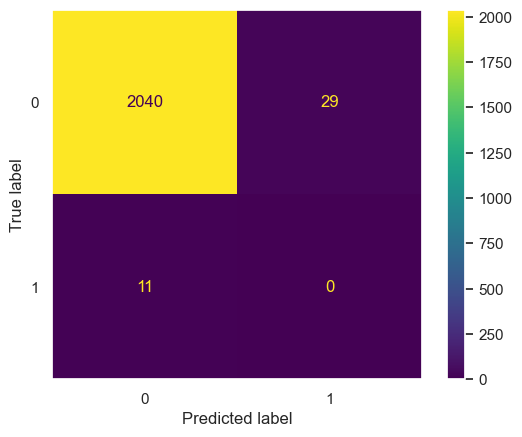

recall :  0.0    precision:  0.0
file :  FakePhishing3187001.csv


recall :  0.0    precision:  0.0
file :  FakePhishing4287001.csv


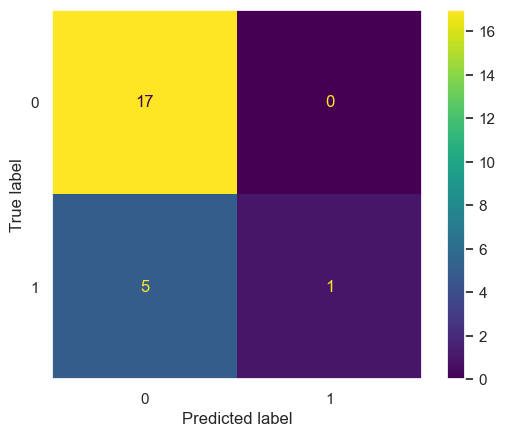

recall :  0.16666666666666666    precision:  1.0
file :  FakePhishing697001.csv


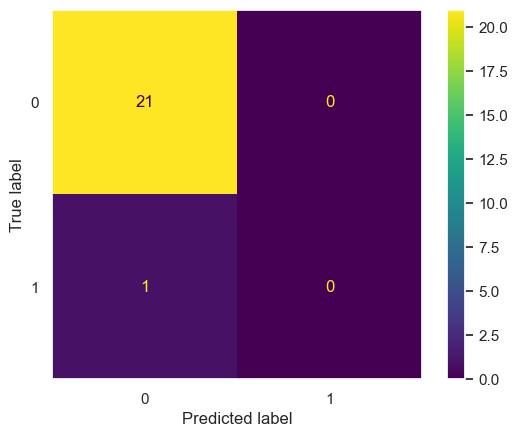

recall :  0.0    precision:  0.0
file :  FlippazOne001.csv


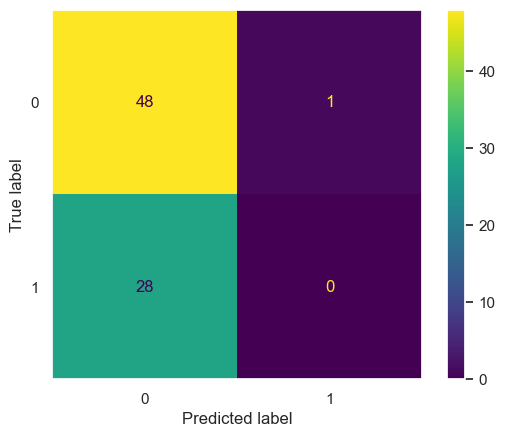

recall :  0.0    precision:  0.0
file :  FloatProtocolFuse001.csv


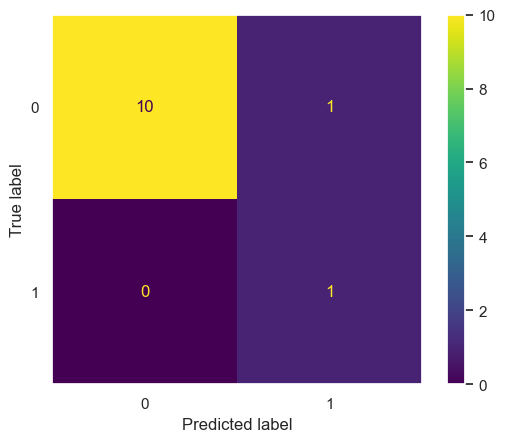

recall :  1.0    precision:  0.5
file :  Focus001.csv


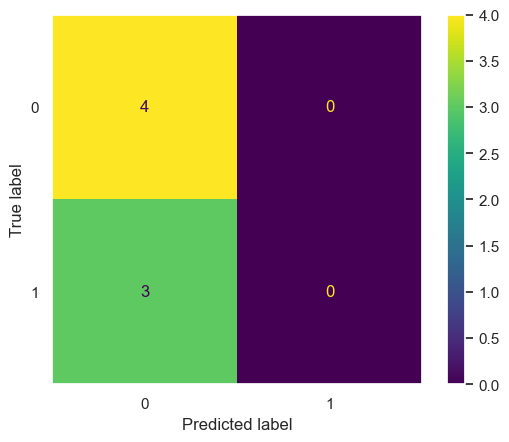

recall :  0.0    precision:  0.0
file :  FormationFi001.csv


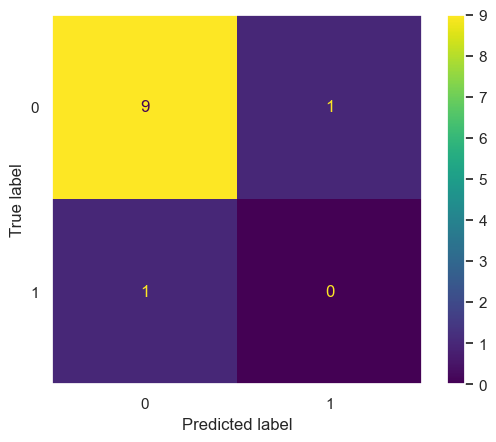

recall :  0.0    precision:  0.0
file :  Fortress Loans001.csv


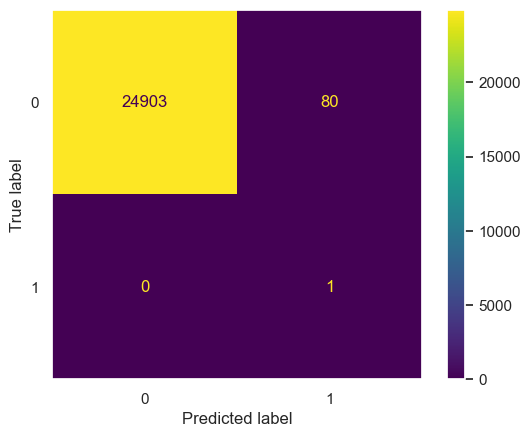

recall :  1.0    precision:  0.012345679012345678
file :  Fortress Loans002.csv


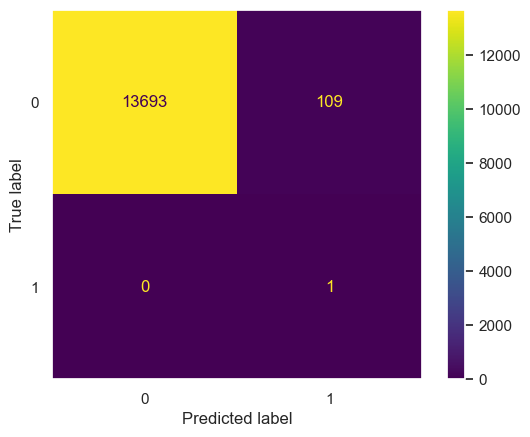

recall :  1.0    precision:  0.00909090909090909
file :  Fortress Loans003.csv


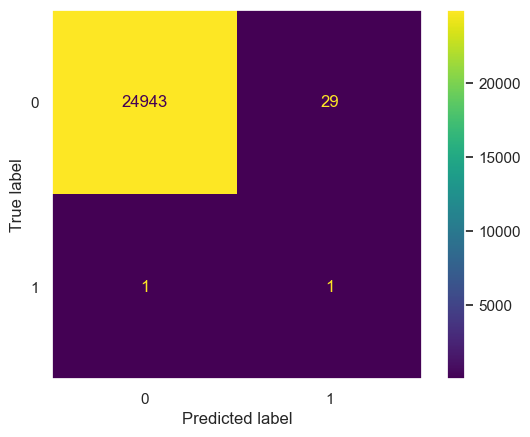

recall :  0.5    precision:  0.03333333333333333
file :  Furucombo001.csv


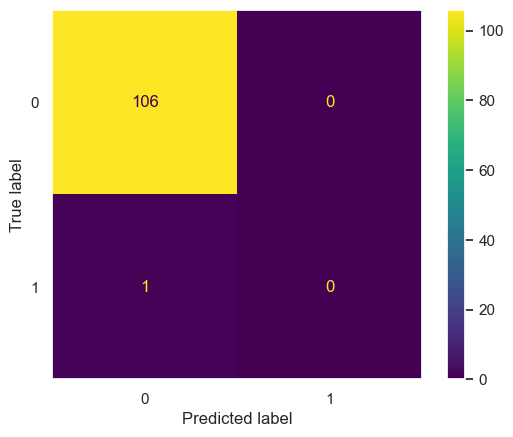

recall :  0.0    precision:  0.0
file :  Furucombo002.csv


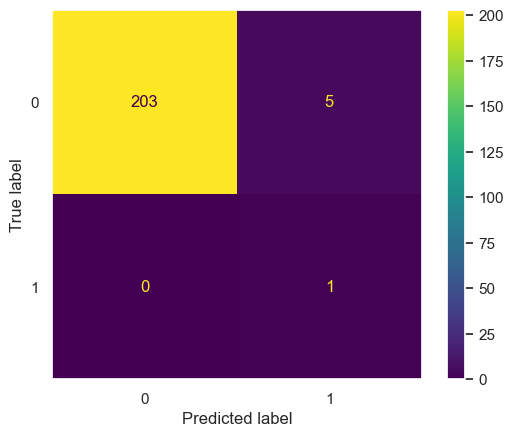

recall :  1.0    precision:  0.16666666666666666
file :  Furucombo003.csv


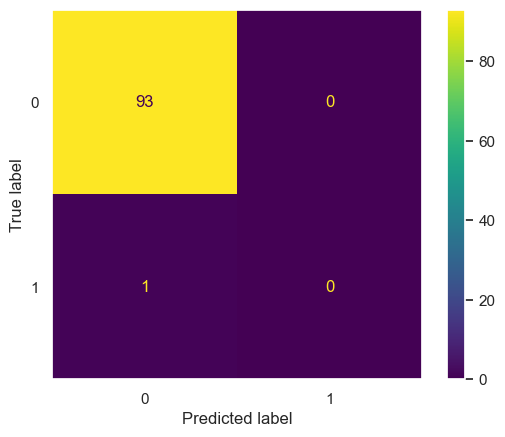

recall :  0.0    precision:  0.0
file :  Furucombo004.csv


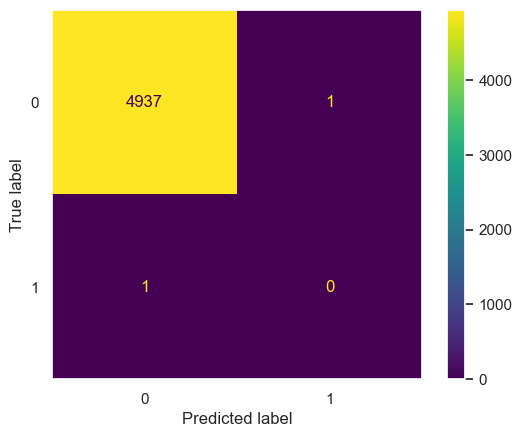

recall :  0.0    precision:  0.0
file :  Furucombo005.csv


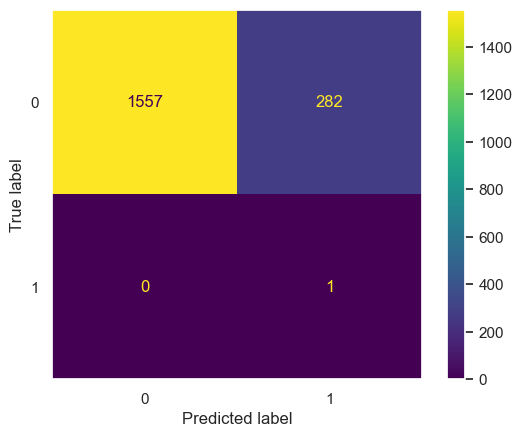

recall :  1.0    precision:  0.0035335689045936395
file :  Furucombo006.csv


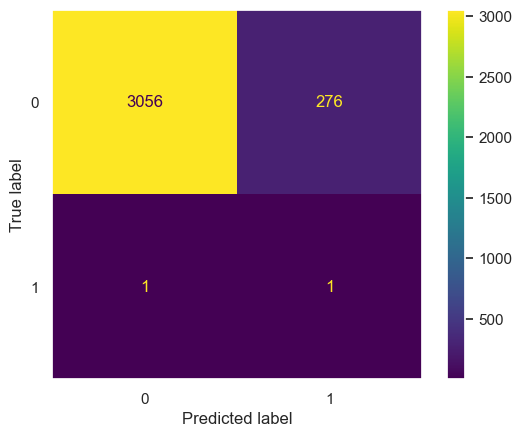

recall :  0.5    precision:  0.0036101083032490976
file :  Furucombo007.csv


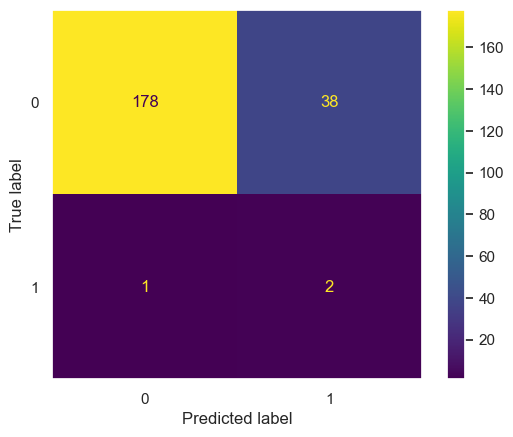

recall :  0.6666666666666666    precision:  0.05
file :  Furucombo008.csv


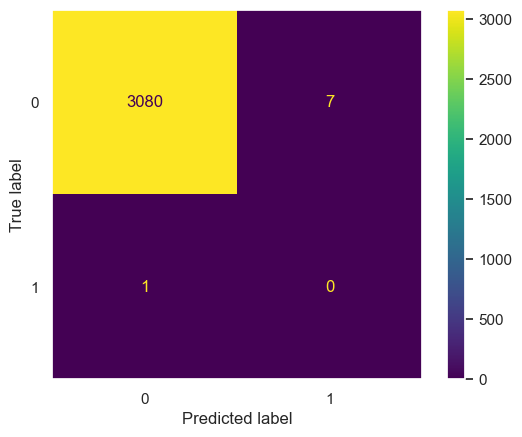

recall :  0.0    precision:  0.0
file :  Furucombo009.csv


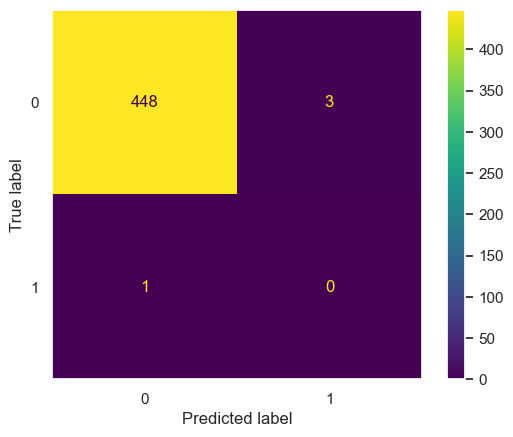

recall :  0.0    precision:  0.0
file :  FusionNetwork001.csv


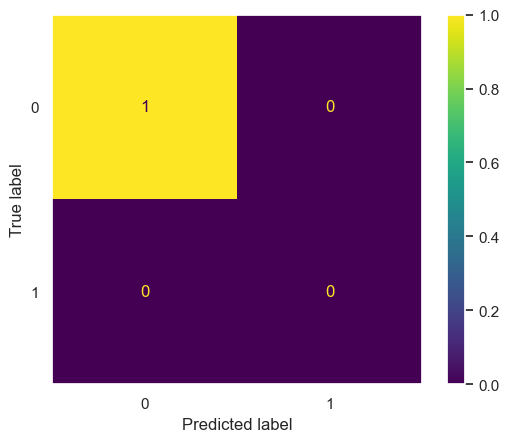

recall :  0.0    precision:  0.0
file :  HarmonyBridge001.csv


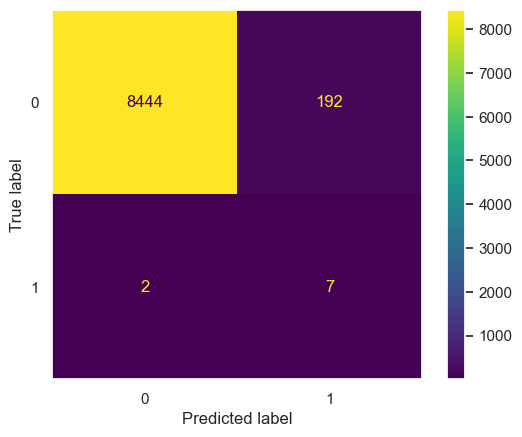

recall :  0.7777777777777778    precision:  0.035175879396984924
file :  HarmonyBridge002.csv


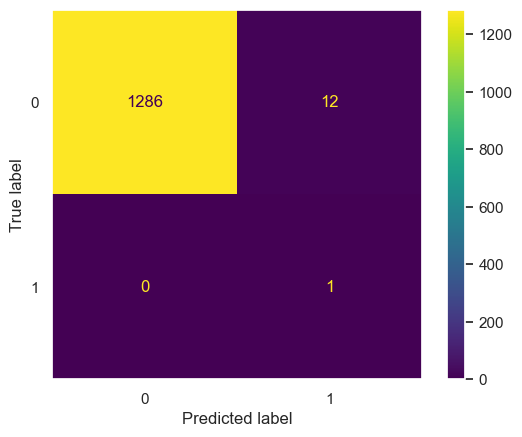

recall :  1.0    precision:  0.07692307692307693
file :  HarmonyBridge003.csv


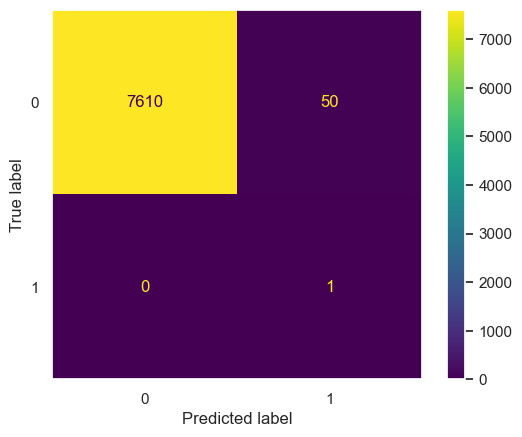

recall :  1.0    precision:  0.0196078431372549
file :  HarmonyBridge004.csv


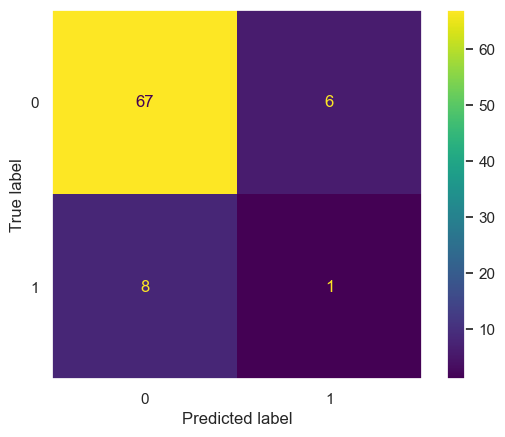

recall :  0.1111111111111111    precision:  0.14285714285714285
file :  HarmonyBridge005.csv


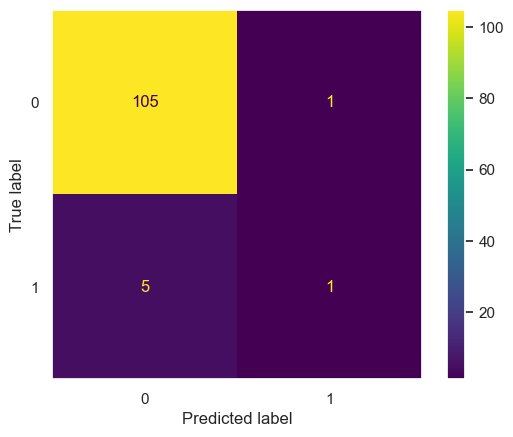

recall :  0.16666666666666666    precision:  0.5
file :  HarvestFinance001.csv


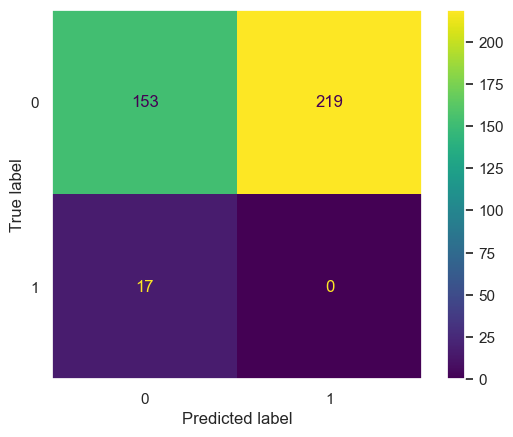

recall :  0.0    precision:  0.0
file :  Holy001.csv


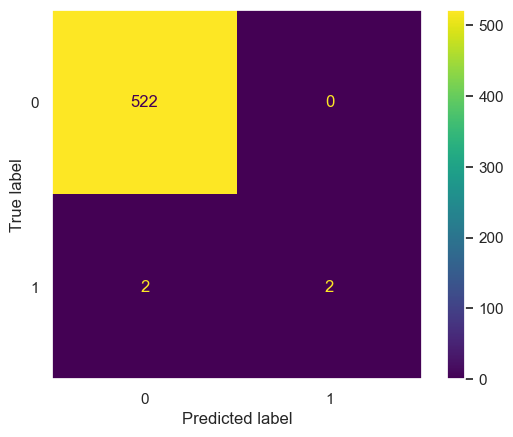

recall :  0.5    precision:  1.0
file :  HughKarp001.csv


recall :  1.0    precision:  0.06666666666666667
file :  HypeBetFinance001.csv


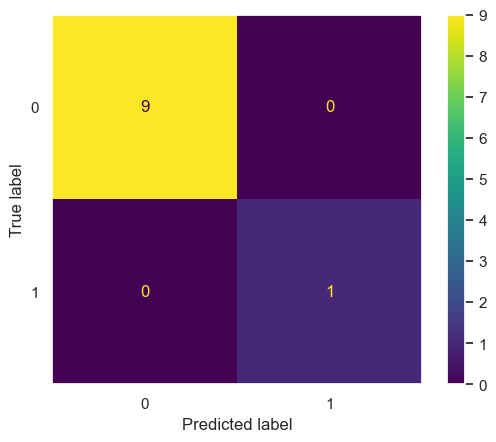

recall :  1.0    precision:  1.0
file :  IMX001.csv


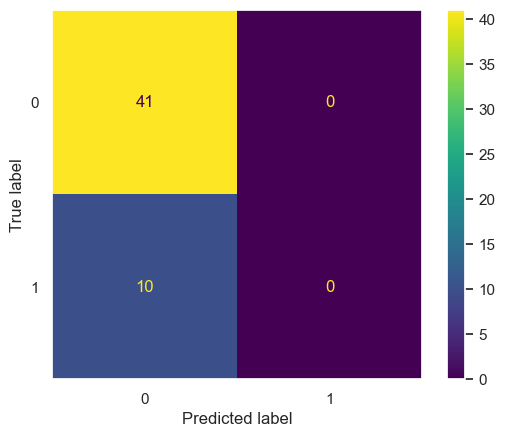

recall :  0.0    precision:  0.0
file :  IMX002.csv


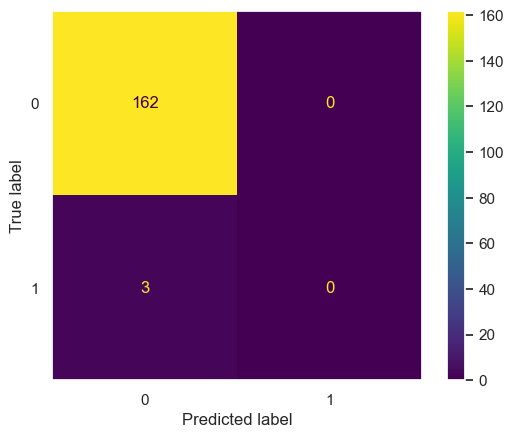

recall :  0.0    precision:  0.0
file :  IMX003.csv


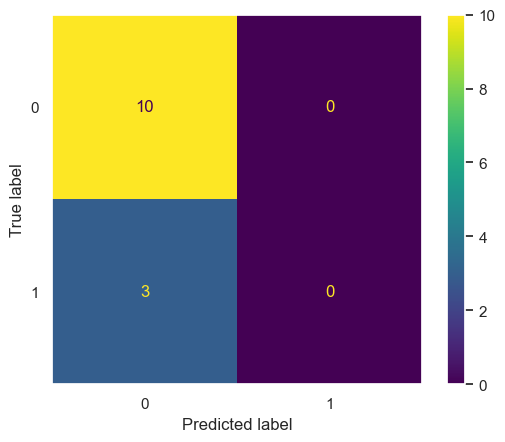

recall :  0.0    precision:  0.0
file :  IanBalina001.csv


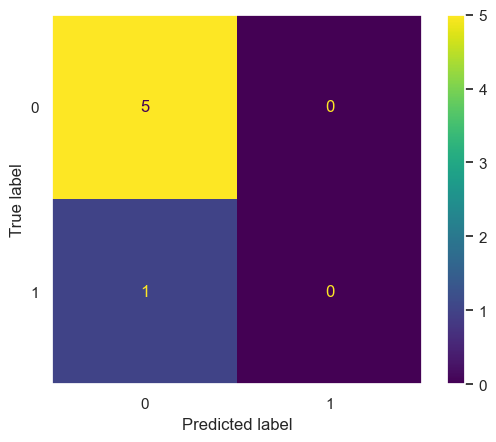

recall :  0.0    precision:  0.0
file :  IanBalina002.csv


recall :  0.0    precision:  0.0
file :  IanBalina003.csv


recall :  0.2    precision:  0.16666666666666666
file :  IanBalina004.csv


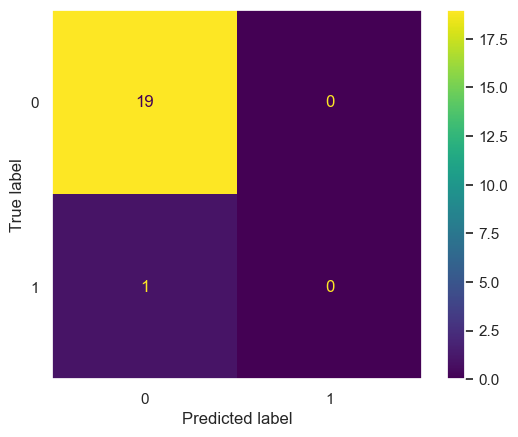

recall :  0.0    precision:  0.0
file :  IanBalina006.csv


recall :  0.5    precision:  0.01282051282051282
file :  IanBalina008.csv


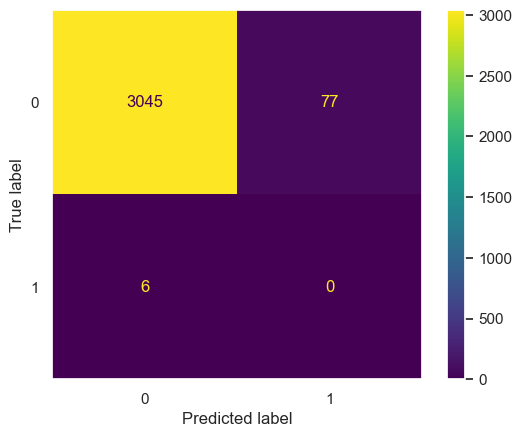

recall :  0.0    precision:  0.0
file :  IanBalina009.csv


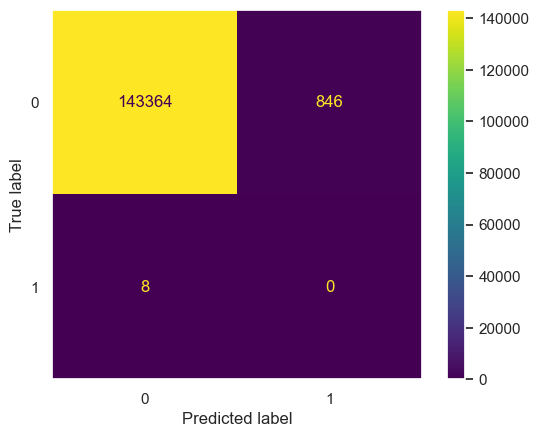

recall :  0.0    precision:  0.0
file :  IanBalina010.csv


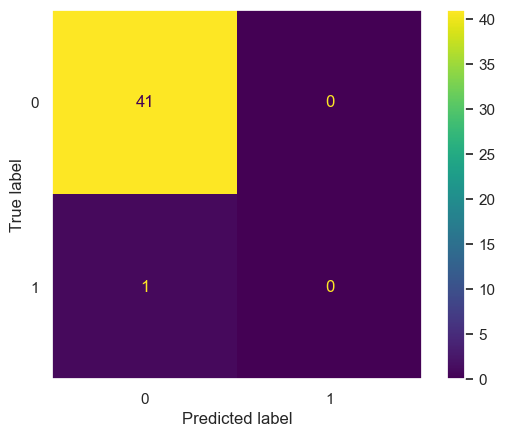

recall :  0.0    precision:  0.0
file :  IanBalina011.csv


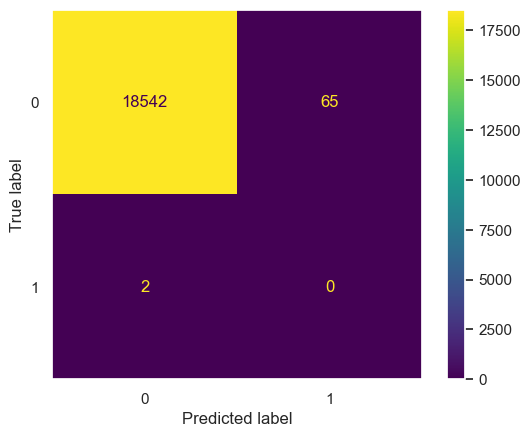

recall :  0.0    precision:  0.0
file :  IndexFinance001.csv


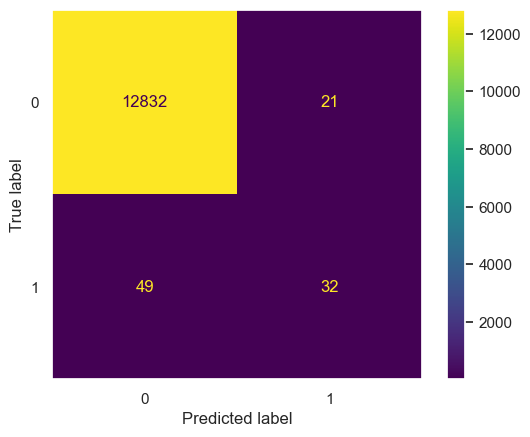

recall :  0.3950617283950617    precision:  0.6037735849056604
file :  InverseFinance001.csv


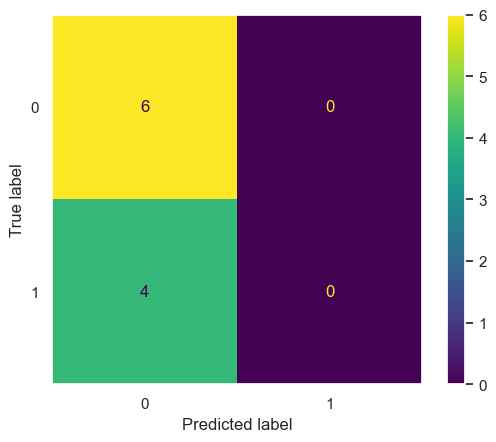

recall :  0.0    precision:  0.0
file :  Kucoin001.csv


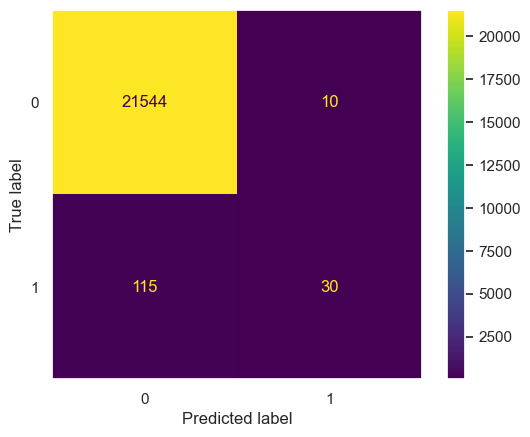

recall :  0.20689655172413793    precision:  0.75
file :  Kucoin002.csv


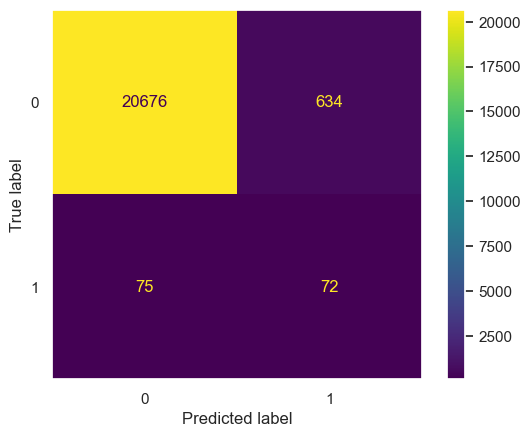

recall :  0.4897959183673469    precision:  0.10198300283286119
file :  LCX001.csv


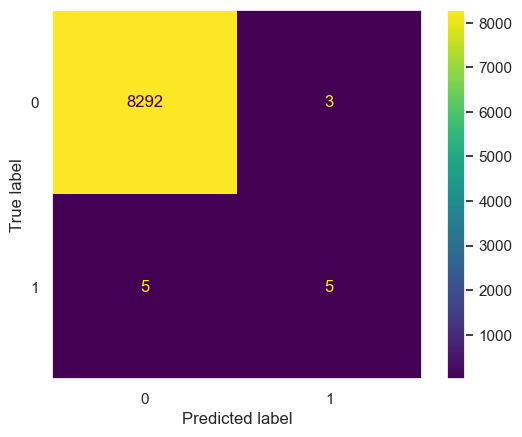

recall :  0.5    precision:  0.625
file :  Lendfme001.csv


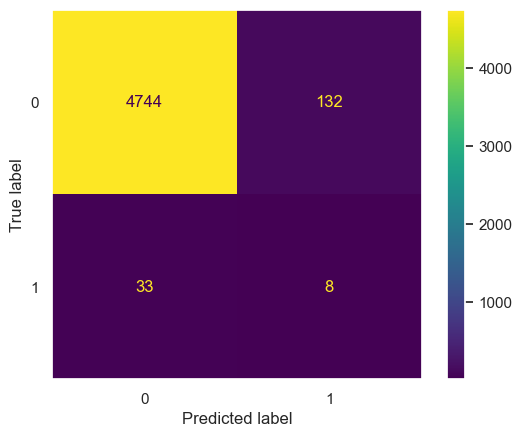

recall :  0.1951219512195122    precision:  0.05714285714285714
file :  Liquid001.csv


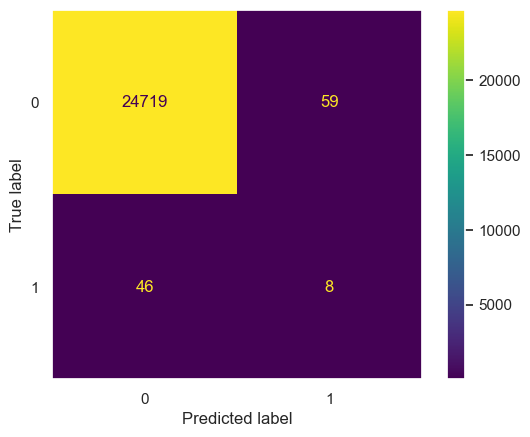

recall :  0.14814814814814814    precision:  0.11940298507462686
file :  Liquid002.csv


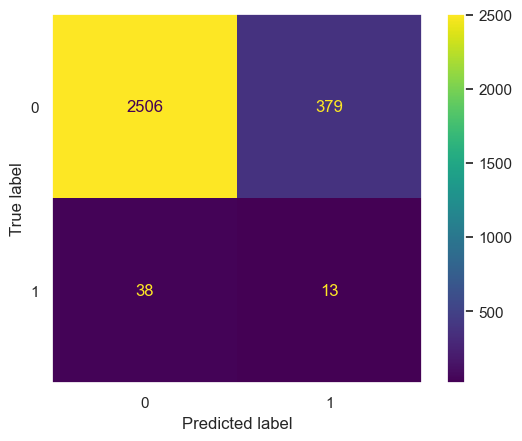

recall :  0.2549019607843137    precision:  0.03316326530612245
file :  Liquid003.csv


recall :  1.0    precision:  0.14285714285714285
file :  LooksRareExchange001.csv


recall :  0.0    precision:  0.0
file :  Lympo001.csv


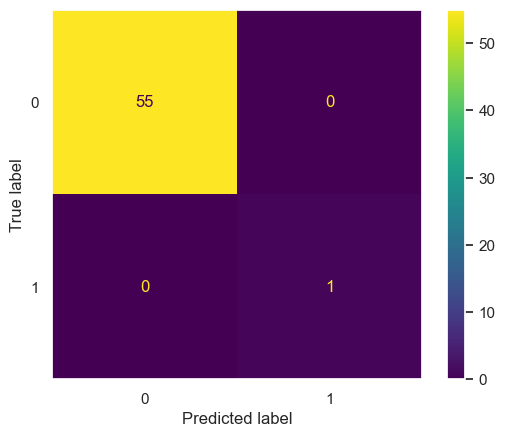

recall :  1.0    precision:  1.0
file :  Lympo003.csv


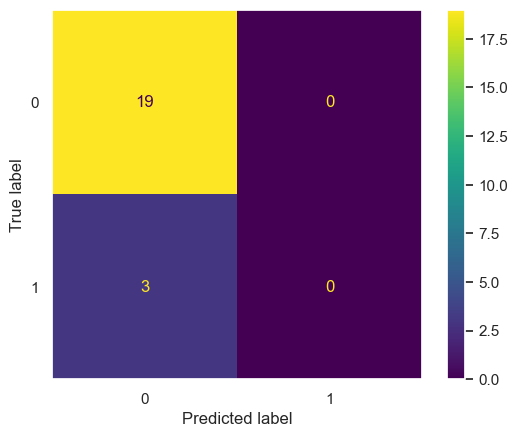

recall :  0.0    precision:  0.0
file :  Malicious Actor001.csv


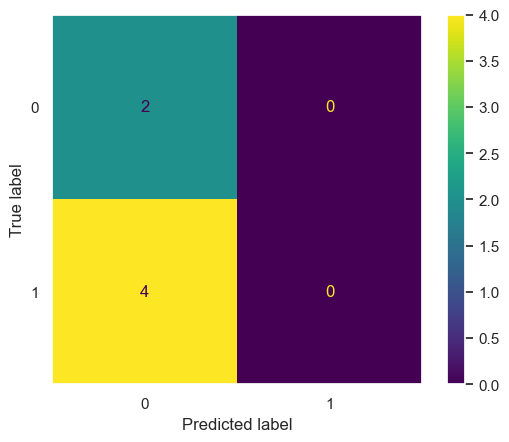

recall :  0.0    precision:  0.0
file :  Malicious Actor002.csv


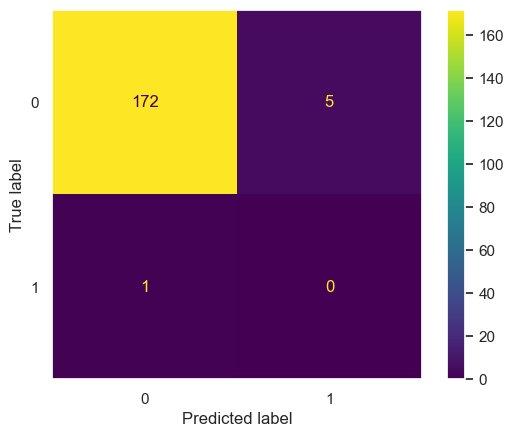

recall :  0.0    precision:  0.0
file :  Malicious Actor003.csv


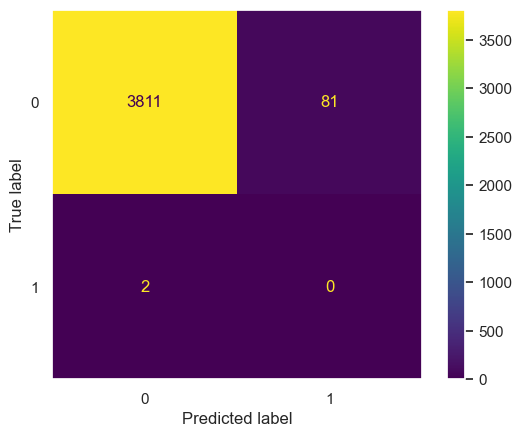

recall :  0.0    precision:  0.0
file :  Malicious Actor004.csv


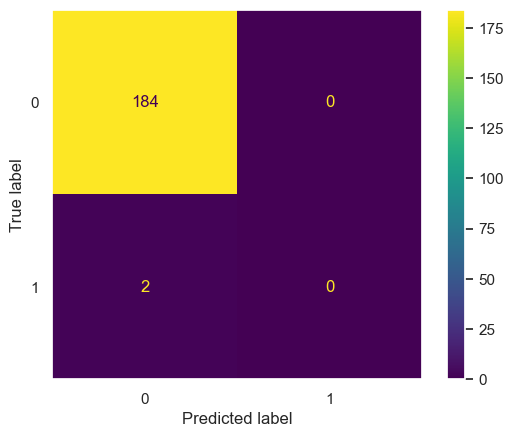

recall :  0.0    precision:  0.0
file :  Malicious Actor005.csv


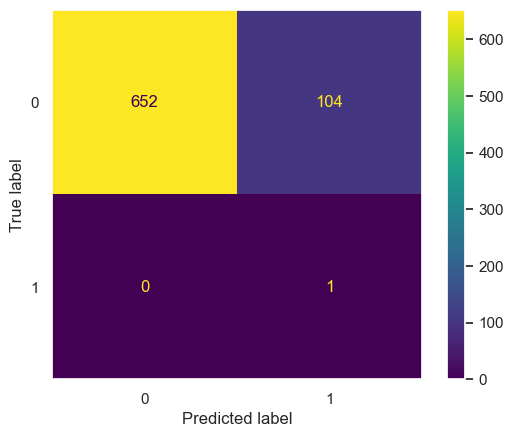

recall :  1.0    precision:  0.009523809523809525
file :  Malicious Actor006.csv


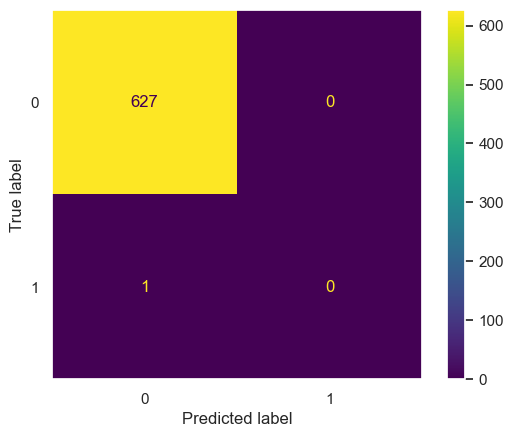

recall :  0.0    precision:  0.0
file :  Malicious Actor007.csv


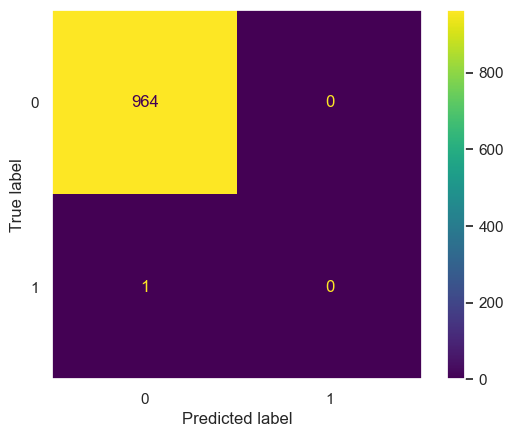

recall :  0.0    precision:  0.0
file :  Malicious Actor008.csv


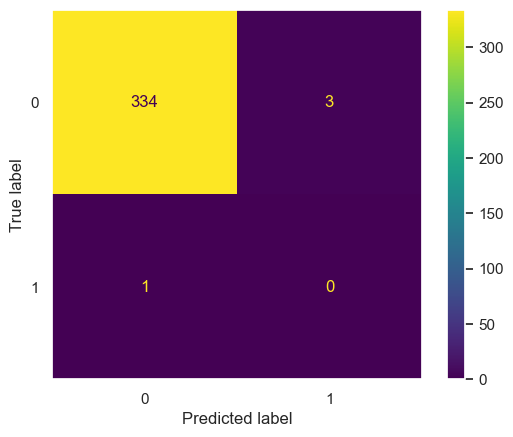

recall :  0.0    precision:  0.0
file :  MerkleTreeVentures001.csv


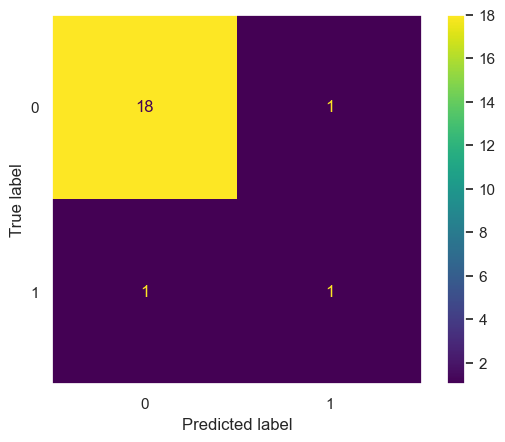

recall :  0.5    precision:  0.5
file :  MetadiumPresale001.csv


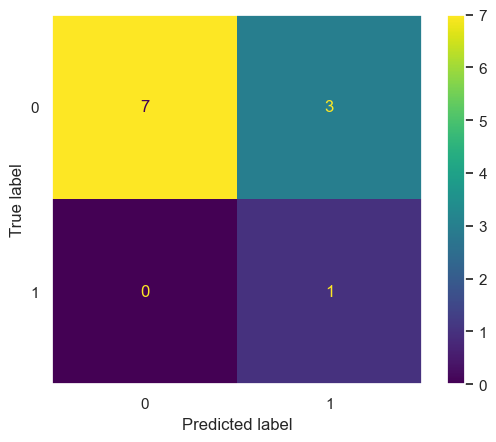

recall :  1.0    precision:  0.25
file :  MetadiumPresale002.csv


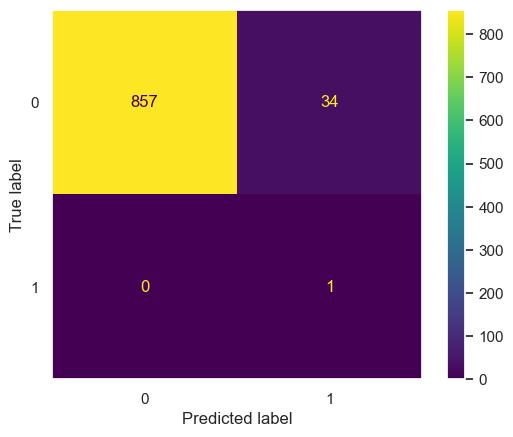

recall :  1.0    precision:  0.02857142857142857
file :  MetadiumPresale003.csv


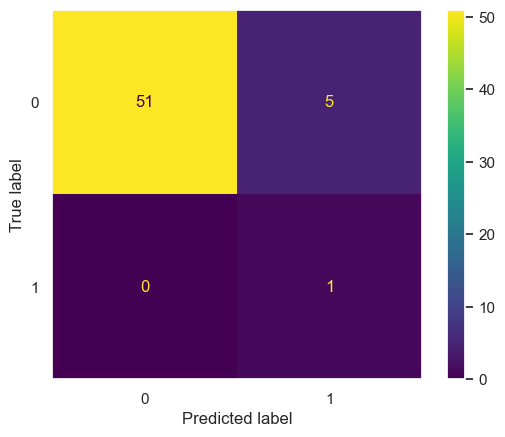

recall :  1.0    precision:  0.16666666666666666
file :  MetadiumPresale004.csv


recall :  0.0    precision:  0.0
file :  MetadiumPresale005.csv


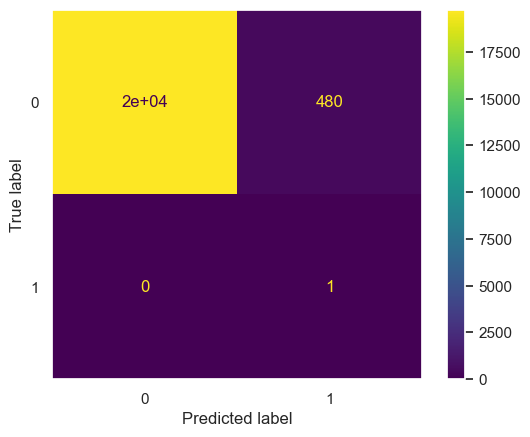

recall :  1.0    precision:  0.002079002079002079
file :  MetadiumPresale006.csv


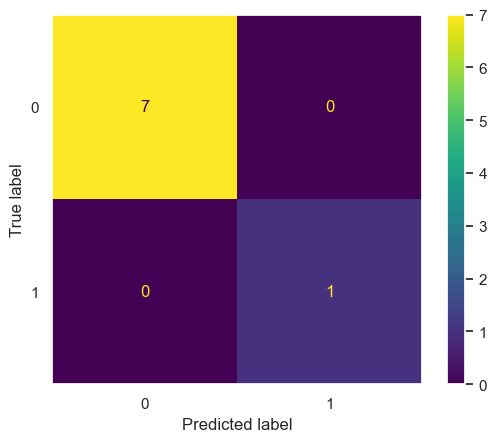

recall :  1.0    precision:  1.0
file :  MetadiumPresale007.csv


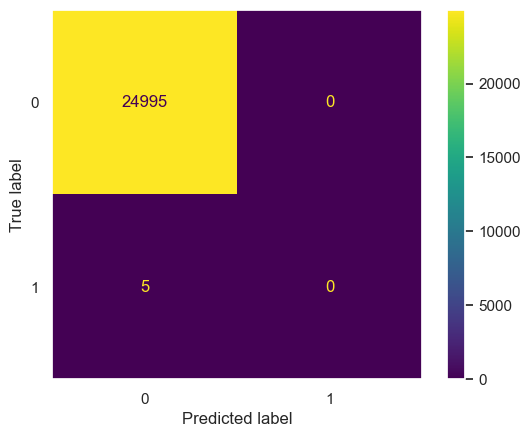

recall :  0.0    precision:  0.0
file :  MetadiumPresale008.csv


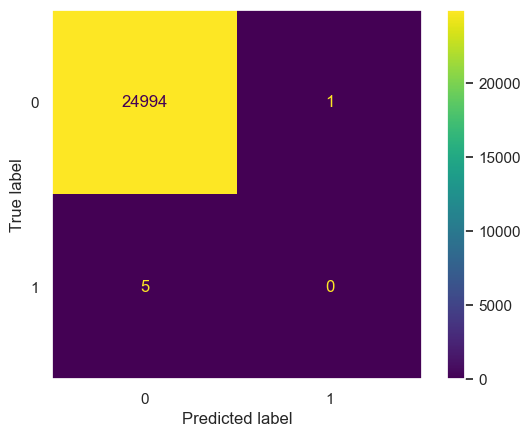

recall :  0.0    precision:  0.0
file :  MetadiumPresale009.csv


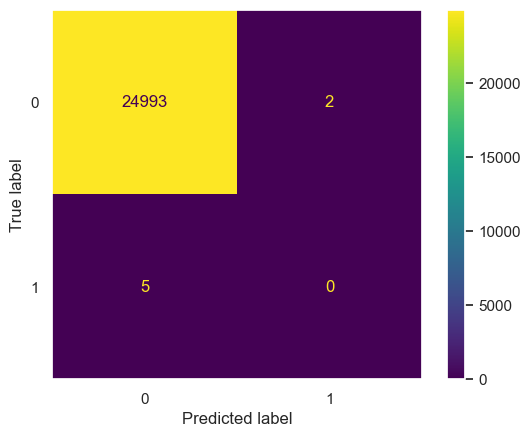

recall :  0.0    precision:  0.0
file :  MochaSetDollar001.csv


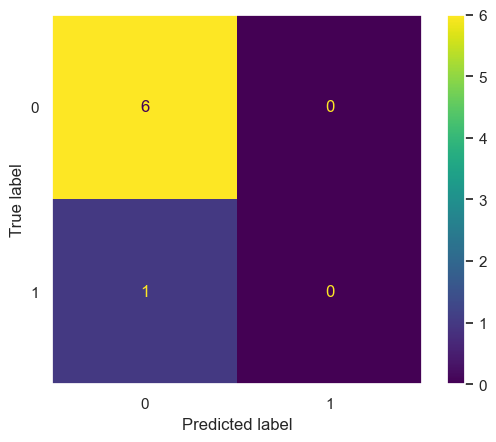

recall :  0.0    precision:  0.0
file :  MonoXFinance001.csv


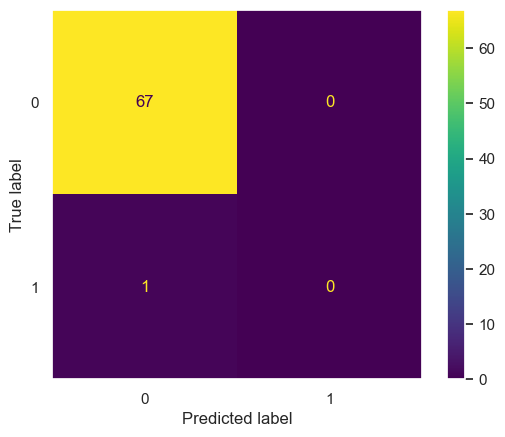

recall :  0.0    precision:  0.0
file :  MonoXfinance002.csv


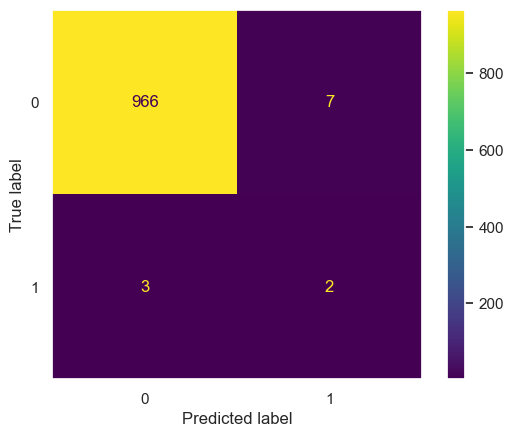

recall :  0.4    precision:  0.2222222222222222
file :  Multichain(Anyswap)001.csv


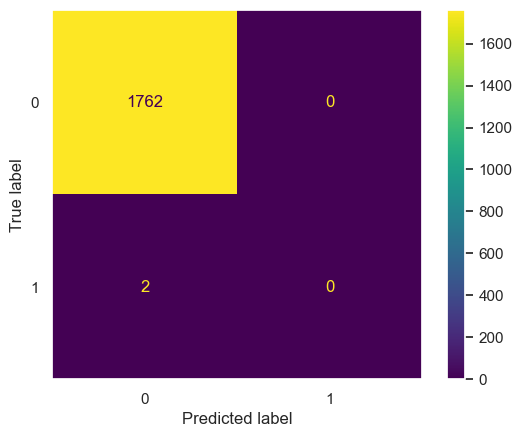

recall :  0.0    precision:  0.0
file :  Multichain(Anyswap)002.csv


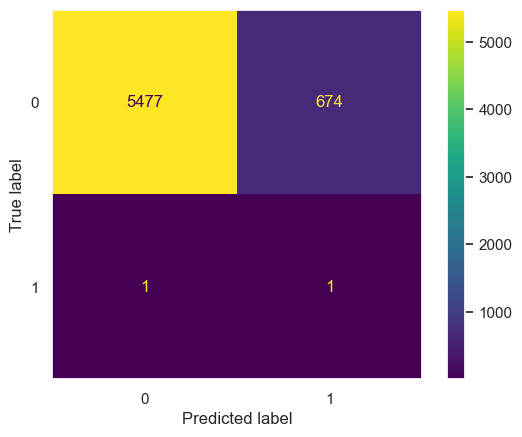

recall :  0.5    precision:  0.0014814814814814814
file :  Multichain(Anyswap)003.csv


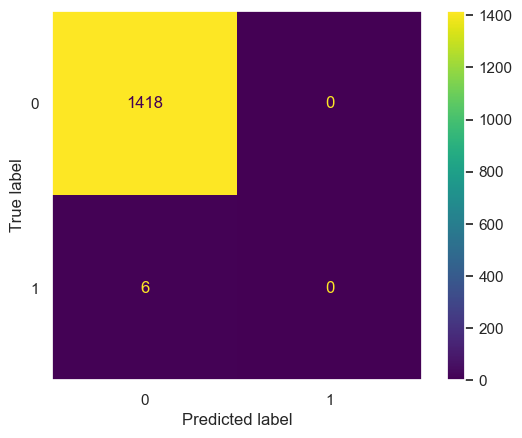

recall :  0.0    precision:  0.0
file :  Multichain(Anyswap)004.csv


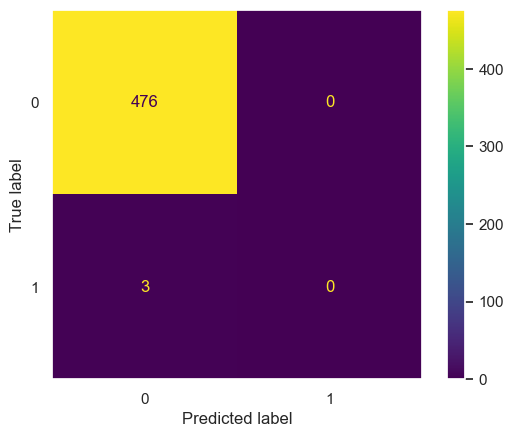

recall :  0.0    precision:  0.0
file :  Multisig001.csv


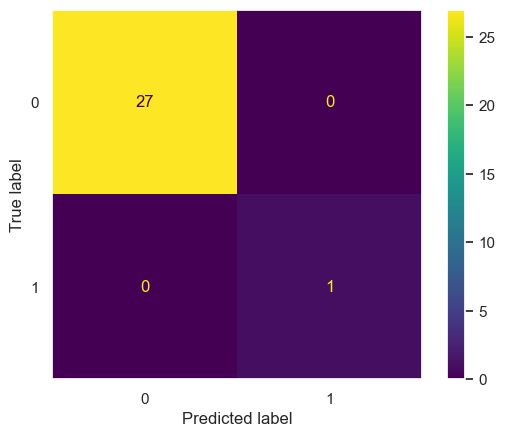

recall :  1.0    precision:  1.0
file :  Multisig002.csv


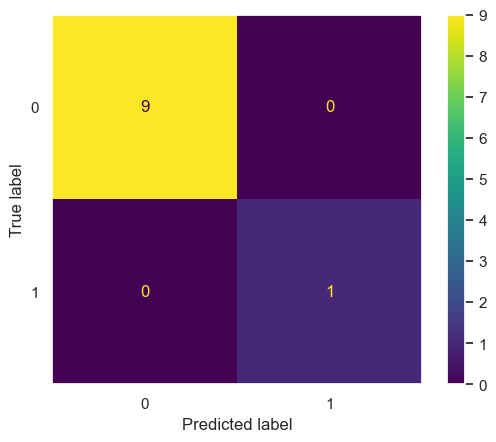

recall :  1.0    precision:  1.0
file :  Multisig003.csv


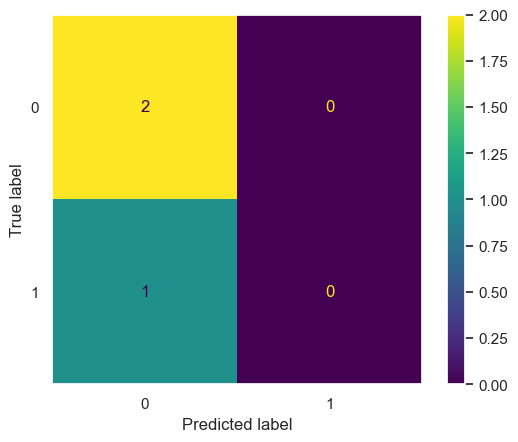

recall :  0.0    precision:  0.0
file :  NexusMutual001.csv


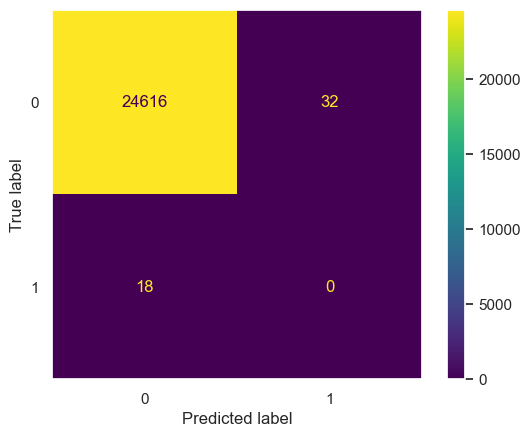

recall :  0.0    precision:  0.0
file :  Nomad001.csv


recall :  0.09090909090909091    precision:  0.3333333333333333
file :  Nomad003.csv


recall :  0.0    precision:  0.0
file :  NowSwapProtocol001.csv


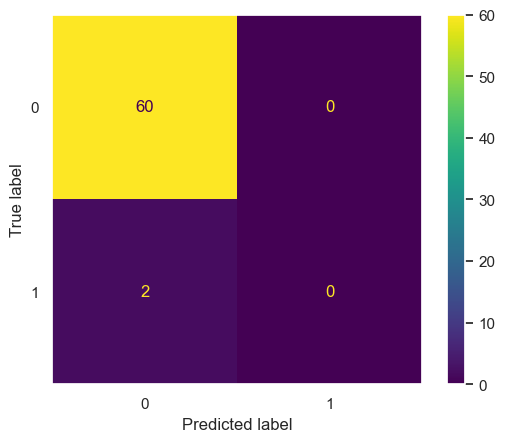

recall :  0.0    precision:  0.0
file :  OmniProtocol001.csv


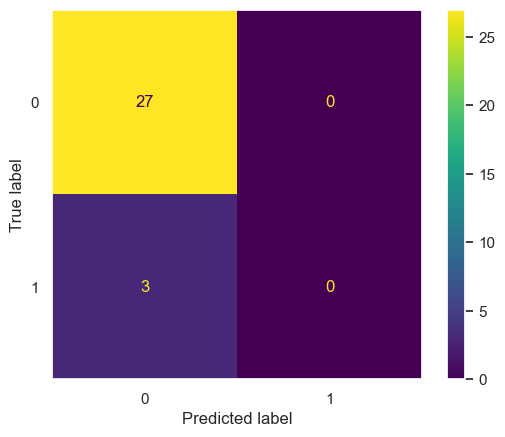

recall :  0.0    precision:  0.0
file :  Opyn001.csv


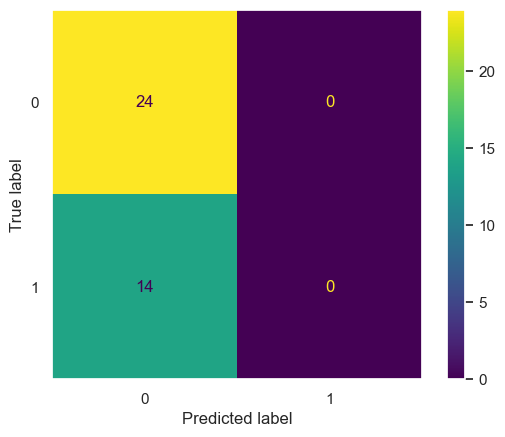

recall :  0.0    precision:  0.0
file :  OracleSwapToken.csv


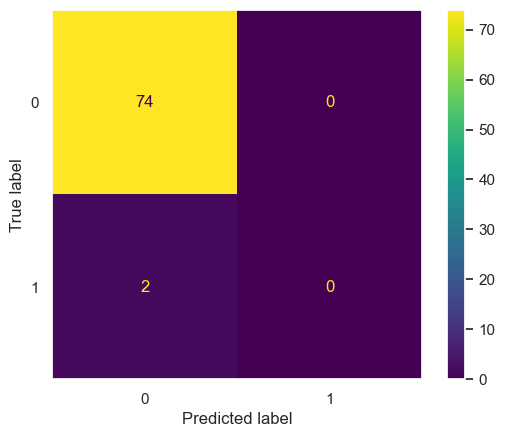

recall :  0.0    precision:  0.0
file :  PhoenixFinance002.csv


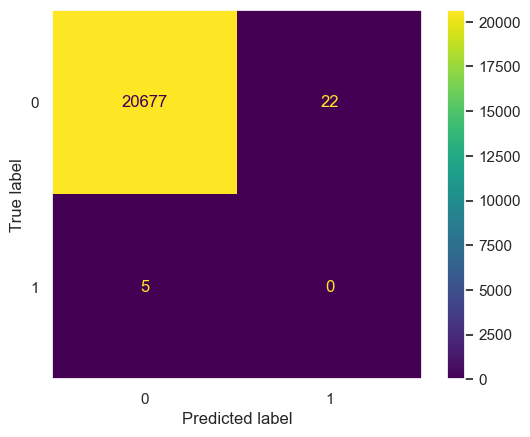

recall :  0.0    precision:  0.0
file :  PhoenixFinance003.csv


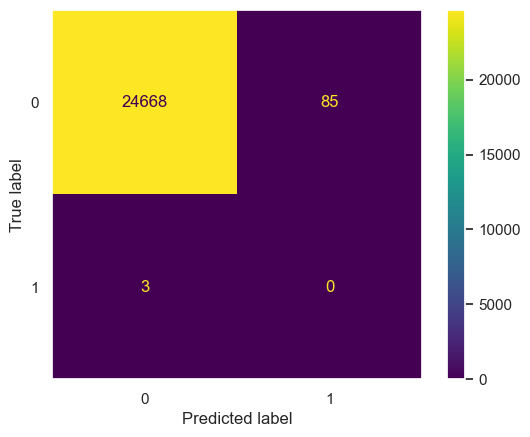

recall :  0.0    precision:  0.0
file :  PhoenixFinance004.csv


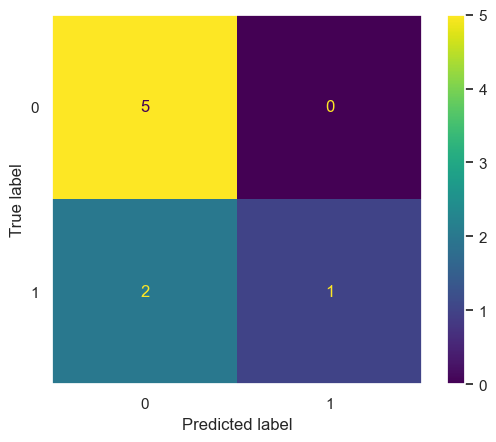

recall :  0.3333333333333333    precision:  1.0
file :  PhoenixFinance005.csv


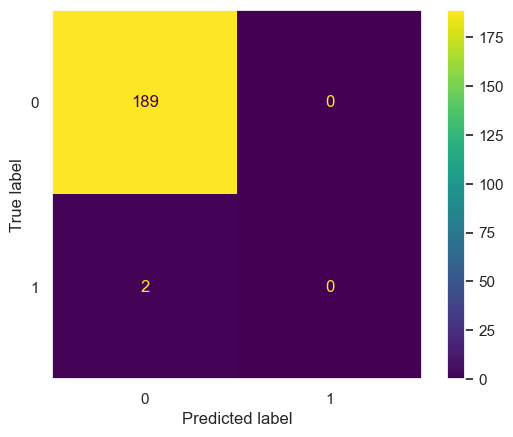

recall :  0.0    precision:  0.0
file :  PhoenixFinance006.csv


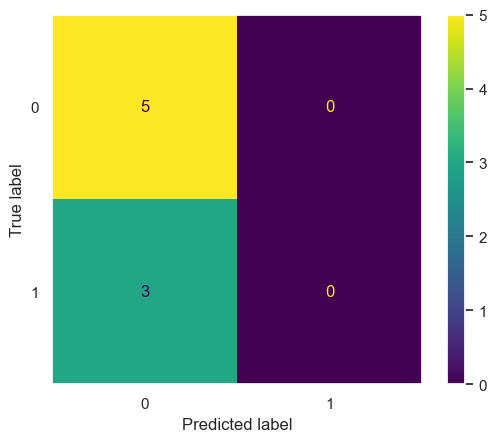

recall :  0.0    precision:  0.0
file :  PickleFinance001.csv


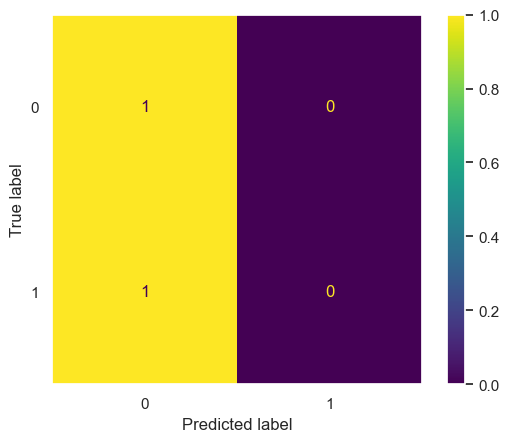

recall :  0.0    precision:  0.0
file :  Poly_Network001.csv


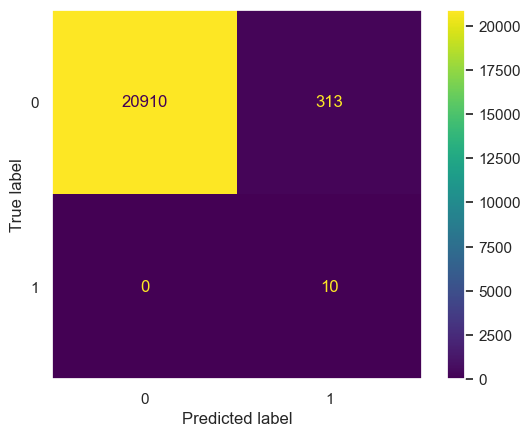

recall :  1.0    precision:  0.030959752321981424
file :  PopsicleFinance001.csv


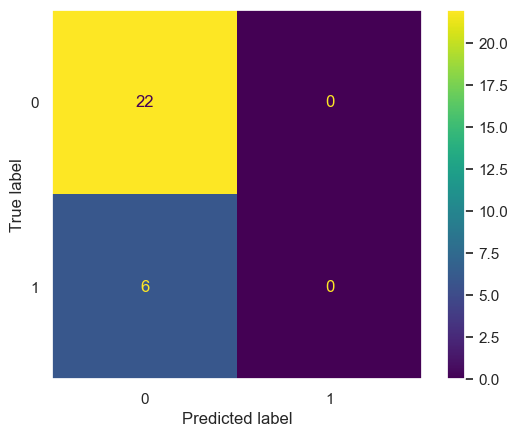

recall :  0.0    precision:  0.0
file :  PumpFarm001.csv


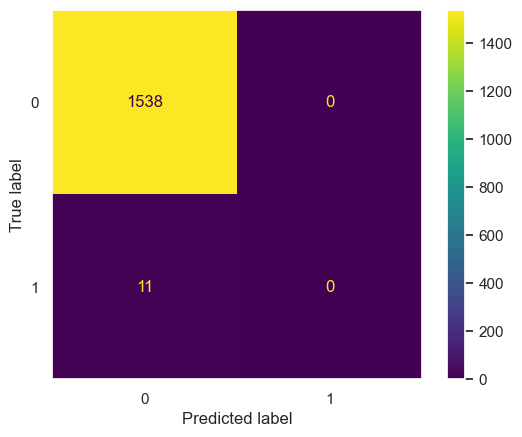

recall :  0.0    precision:  0.0
file :  PunkProtocol001.csv


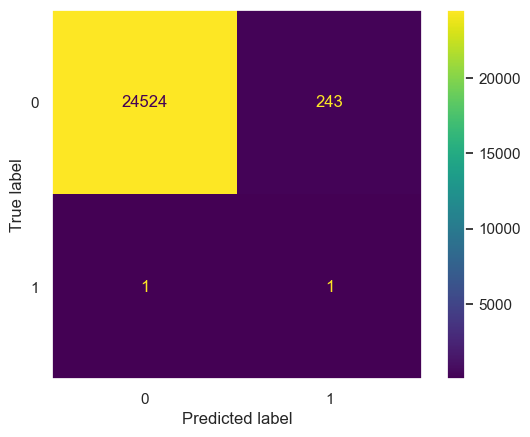

recall :  0.5    precision:  0.004098360655737705
file :  RBaseFinance001.csv


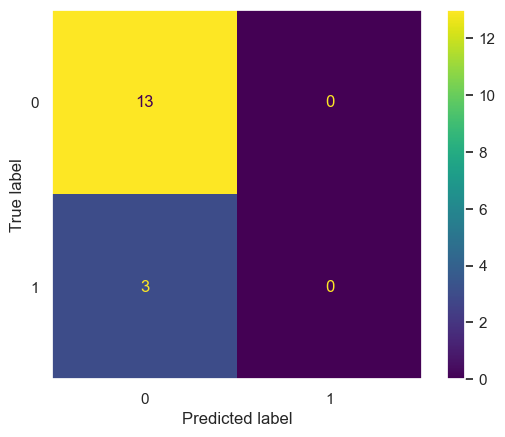

recall :  0.0    precision:  0.0
file :  Reflation001.csv


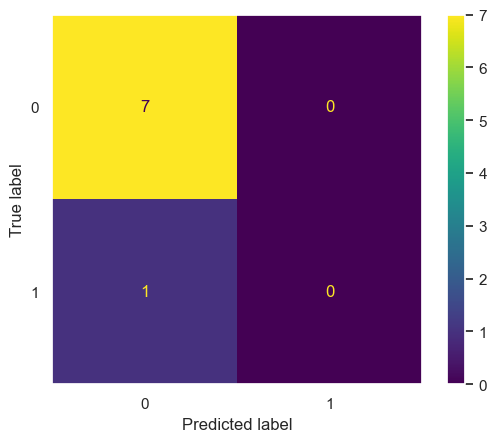

recall :  0.0    precision:  0.0
file :  ReflectFinance001.csv


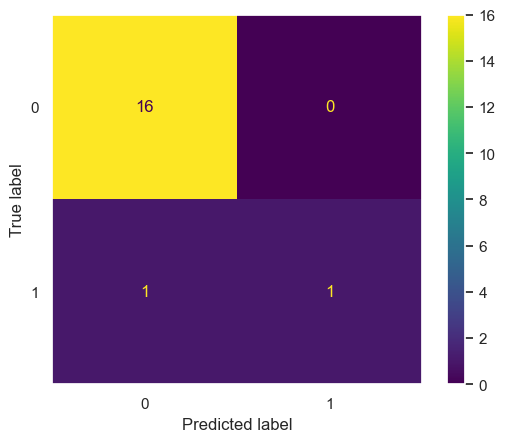

recall :  0.5    precision:  1.0
file :  Revest001.csv


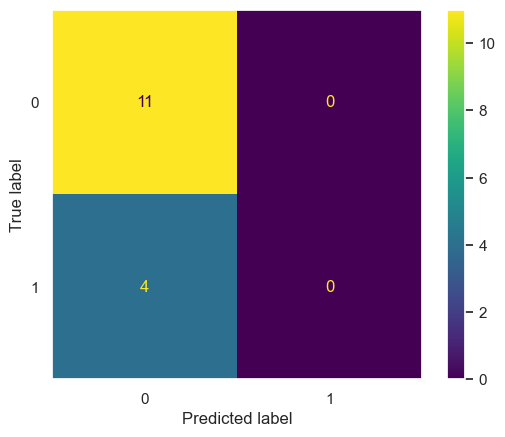

recall :  0.0    precision:  0.0
file :  RibbonFinance001.csv


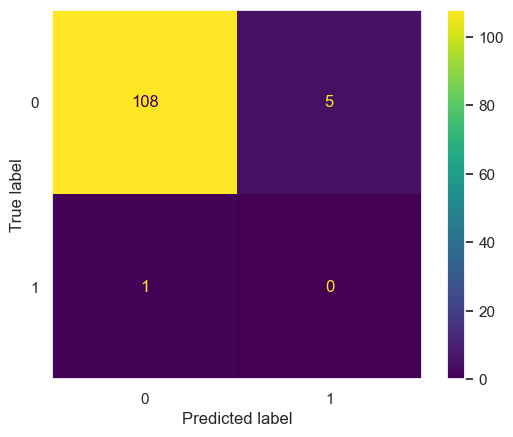

recall :  0.0    precision:  0.0
file :  RigoBlock001.csv


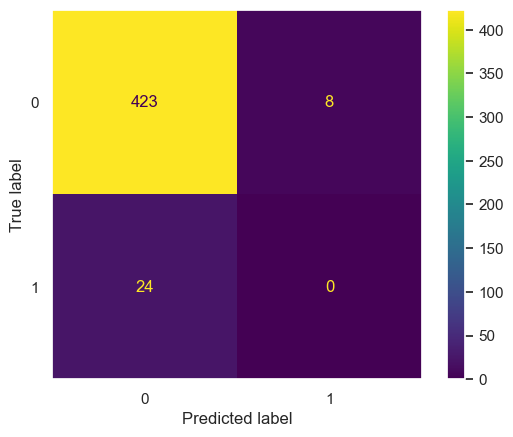

recall :  0.0    precision:  0.0
file :  Roll001.csv


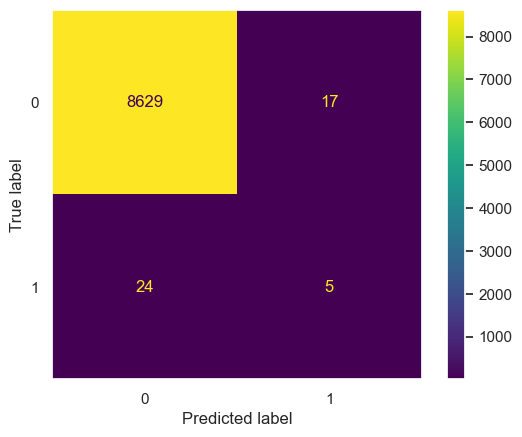

recall :  0.1724137931034483    precision:  0.22727272727272727
file :  Ronin001.csv


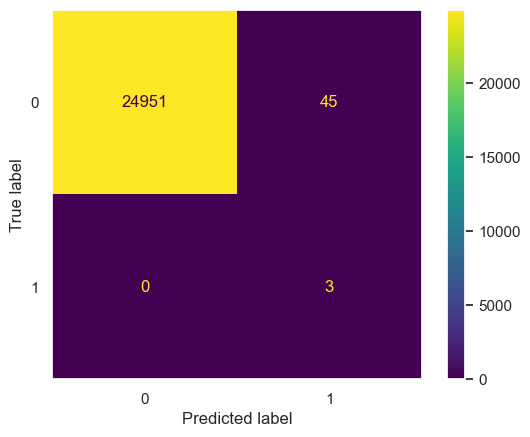

recall :  1.0    precision:  0.0625
file :  SaddleFinance001.csv


recall :  0.0    precision:  0.0
file :  SaddleFinance002.csv


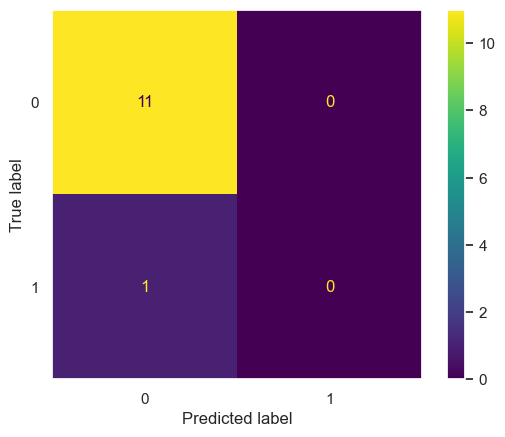

recall :  0.0    precision:  0.0
file :  Sanshu_nu001.csv


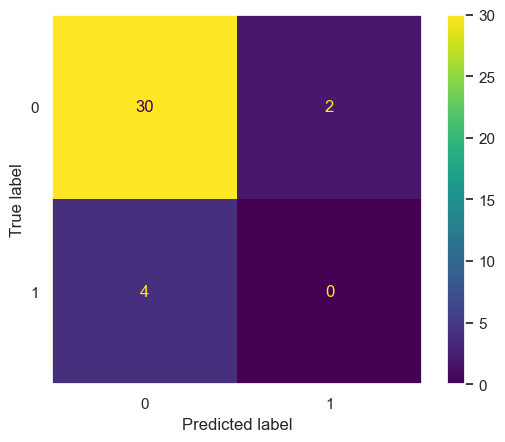

recall :  0.0    precision:  0.0
file :  Santa DAO001.csv


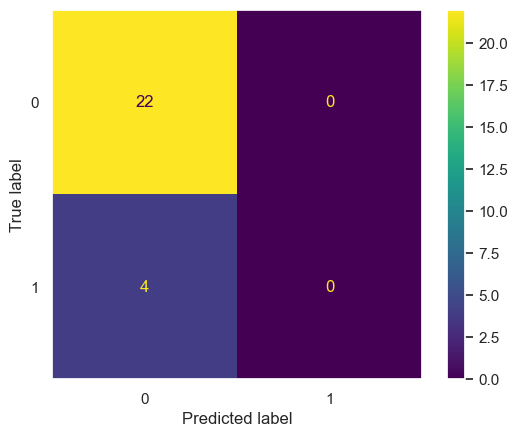

recall :  0.0    precision:  0.0
file :  SashimiSwap001.csv


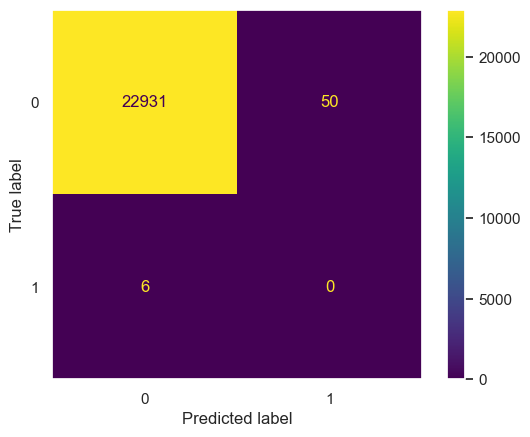

recall :  0.0    precision:  0.0
file :  SaturnbeamFiRug001.csv


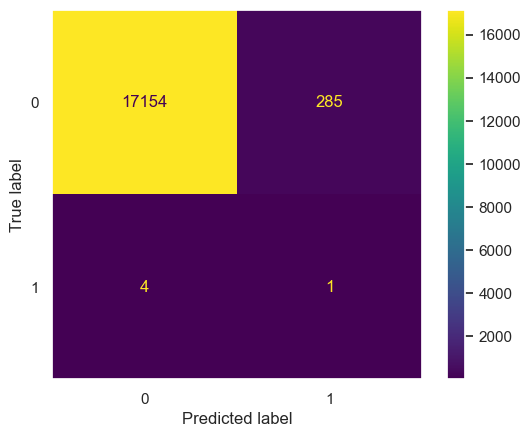

recall :  0.2    precision:  0.0034965034965034965
file :  SaturnbeamFiRug002.csv


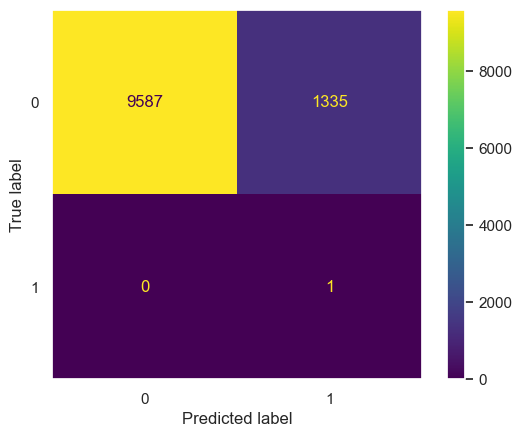

recall :  1.0    precision:  0.0007485029940119761
file :  SaturnbeamFiRug003.csv


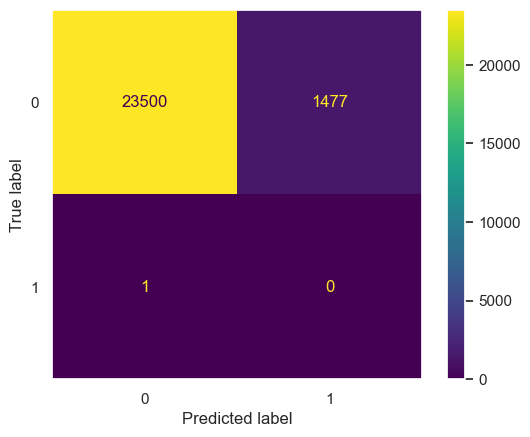

recall :  0.0    precision:  0.0
file :  SirenProtocol001.csv


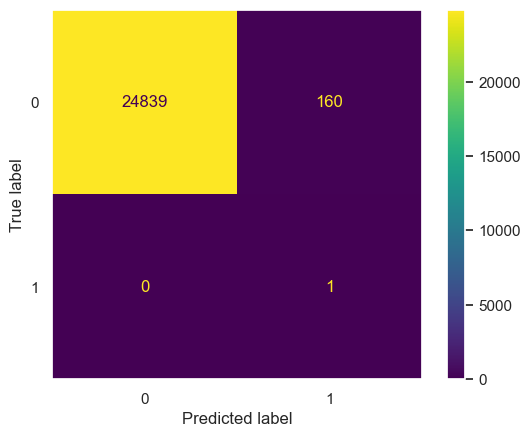

recall :  1.0    precision:  0.006211180124223602
file :  SpankChain.csv


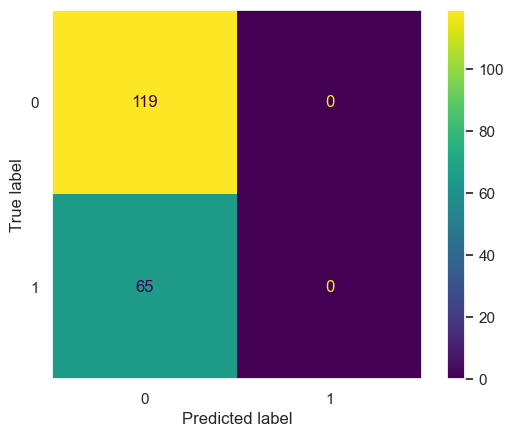

recall :  0.0    precision:  0.0
file :  SpankChain001.csv


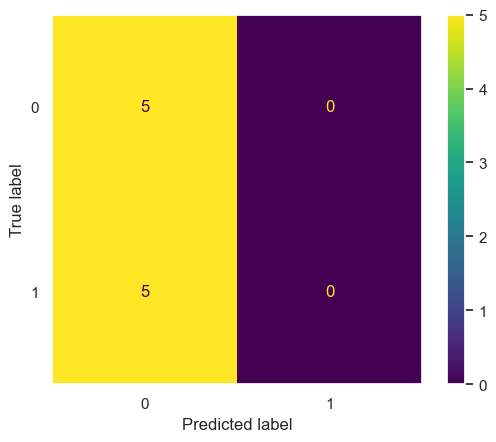

recall :  0.0    precision:  0.0
file :  Stazie001.csv


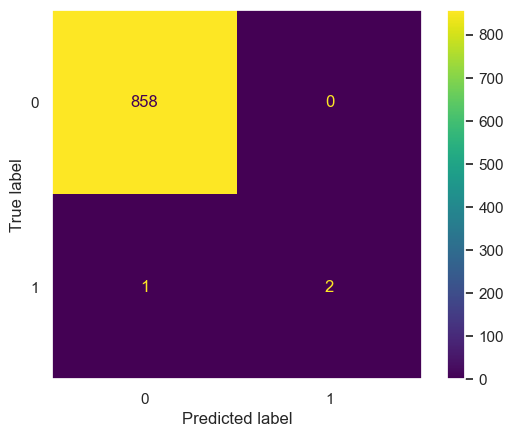

recall :  0.6666666666666666    precision:  1.0
file :  StoboxExchange001.csv


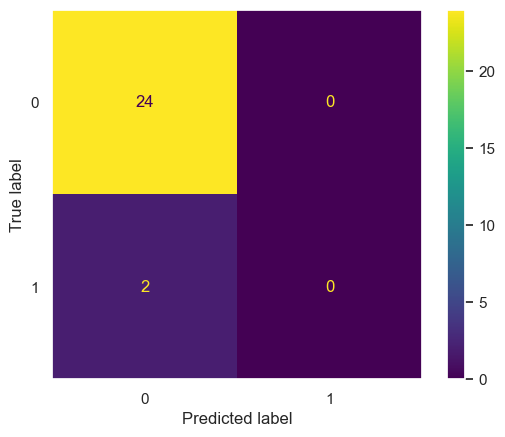

recall :  0.0    precision:  0.0
file :  Sudorare001.csv


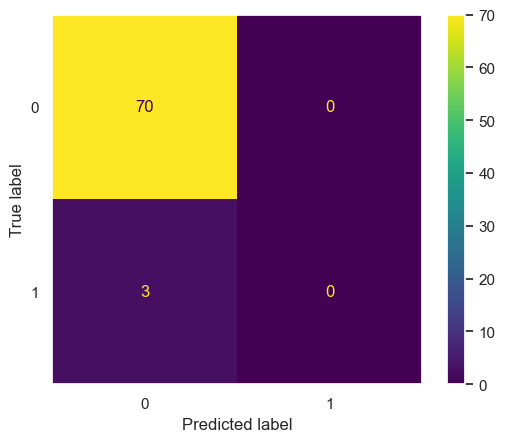

recall :  0.0    precision:  0.0
file :  SushiSwap001.csv


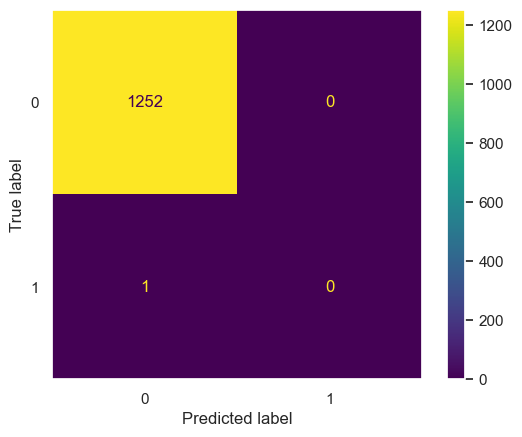

recall :  0.0    precision:  0.0
file :  SynLev001.csv


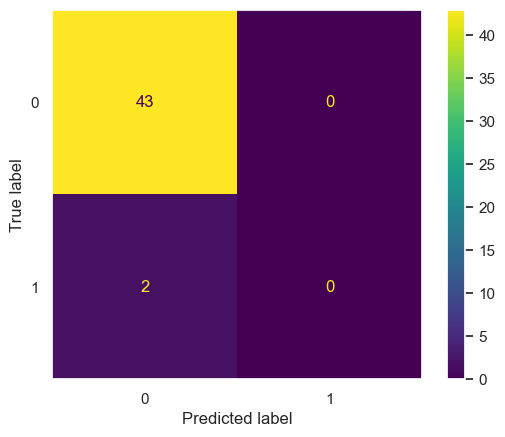

recall :  0.0    precision:  0.0
file :  SynLev002.csv


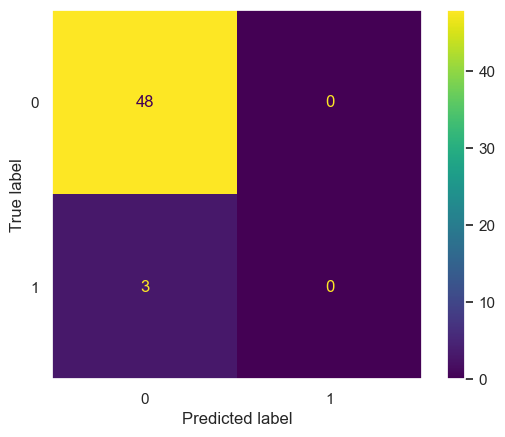

recall :  0.0    precision:  0.0
file :  THORChain001.csv


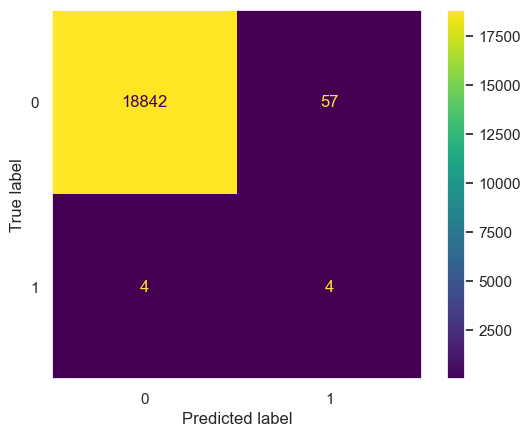

recall :  0.5    precision:  0.06557377049180328
file :  Taylor.csv


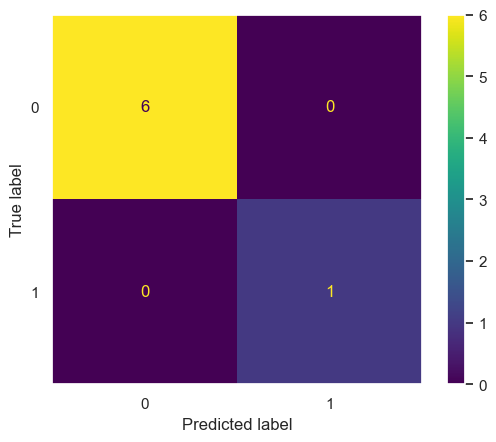

recall :  1.0    precision:  1.0
file :  Tecra001.csv


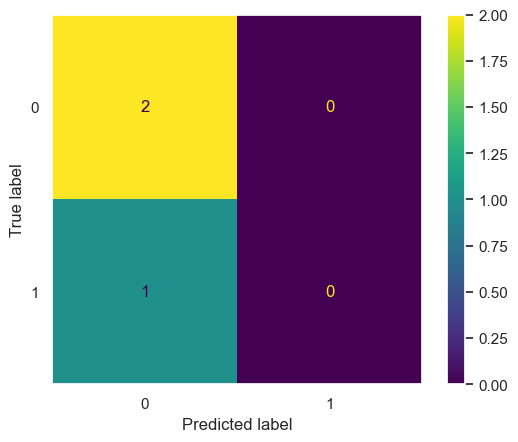

recall :  0.0    precision:  0.0
file :  Tomatos001.csv


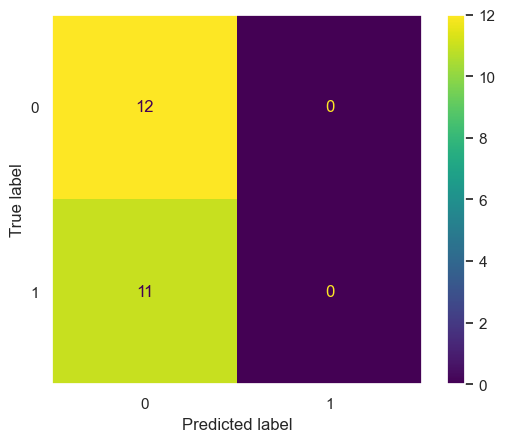

recall :  0.0    precision:  0.0
file :  Tomatos002.csv


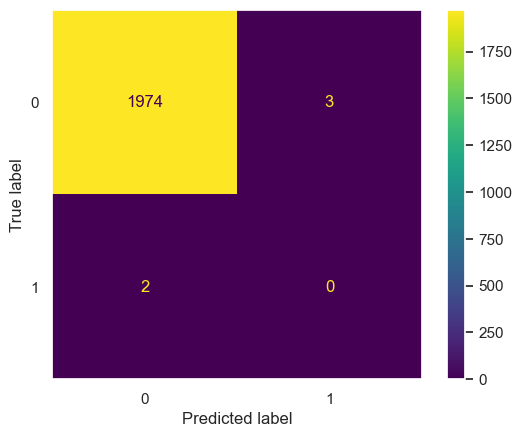

recall :  0.0    precision:  0.0
file :  Tomatos004.csv


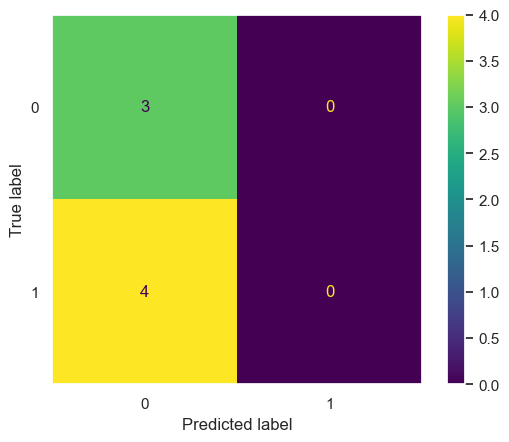

recall :  0.0    precision:  0.0
file :  Umbrella001.csv


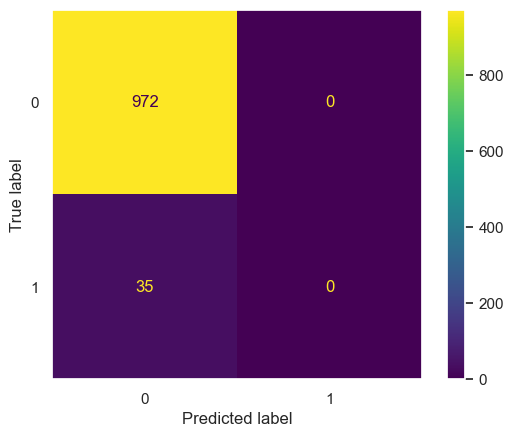

recall :  0.0    precision:  0.0
file :  Umbrella003.csv


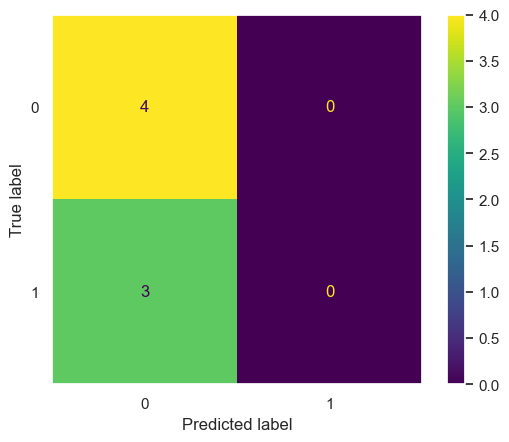

recall :  0.0    precision:  0.0
file :  Umbrella007.csv


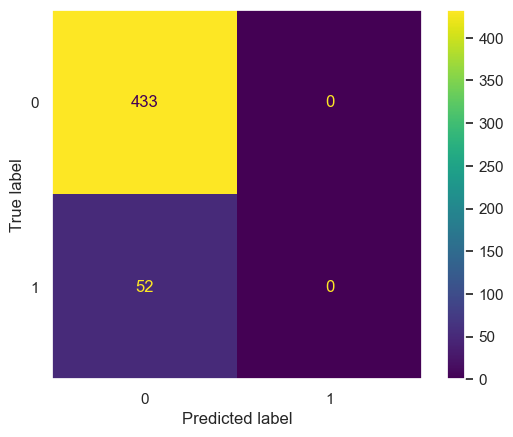

recall :  0.0    precision:  0.0
file :  Umbrella008.csv


recall :  0.0    precision:  0.0
file :  Umbrella009.csv


recall :  0.0    precision:  0.0
file :  Umbrella010.csv


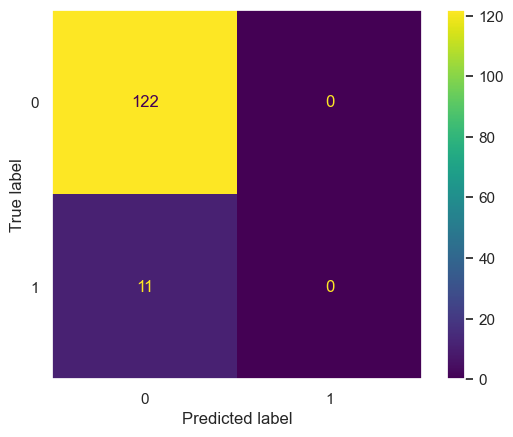

recall :  0.0    precision:  0.0
file :  Umbrella011.csv


recall :  0.0    precision:  0.0
file :  Umbrella012.csv


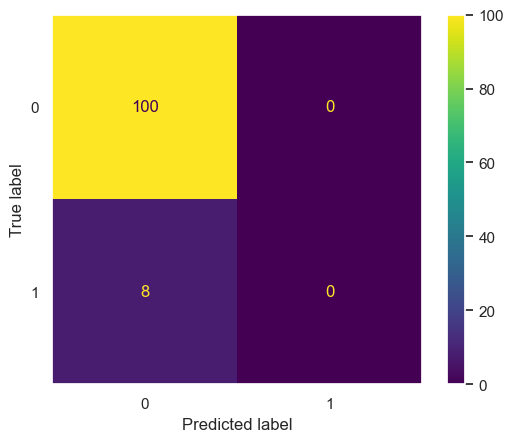

recall :  0.0    precision:  0.0
file :  Umbrella013.csv


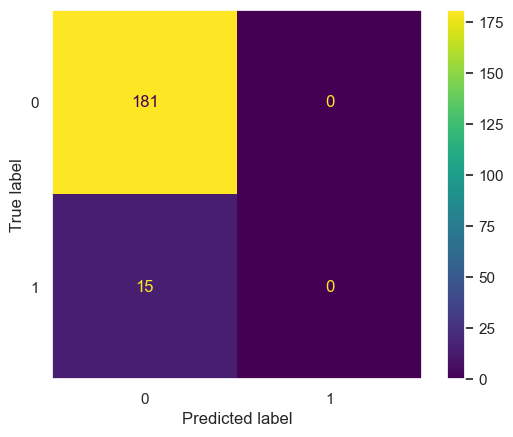

recall :  0.0    precision:  0.0
file :  Umbrella014.csv


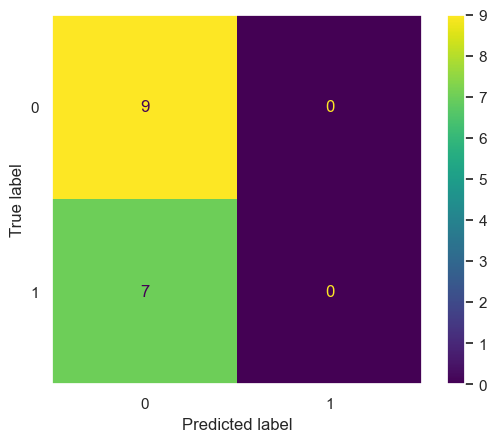

recall :  0.0    precision:  0.0
file :  Umbrella015.csv


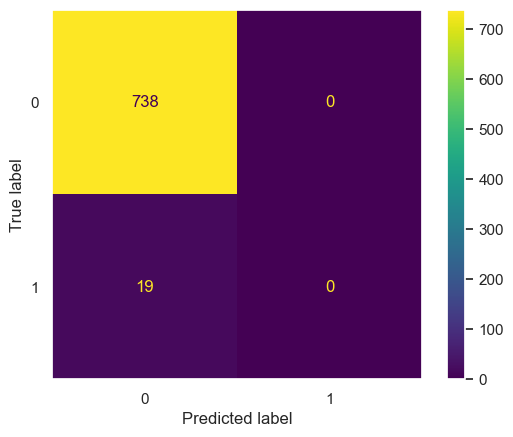

recall :  0.0    precision:  0.0
file :  Umbrella016.csv


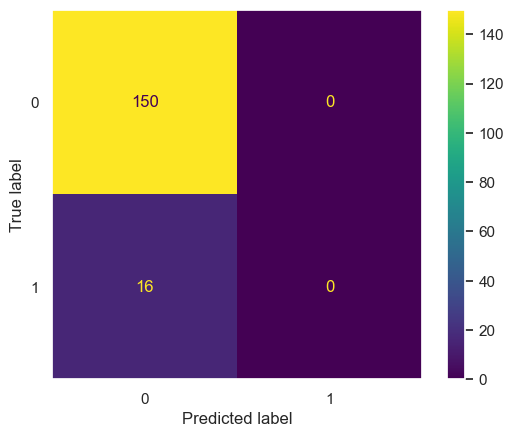

recall :  0.0    precision:  0.0
file :  Umbrella017.csv


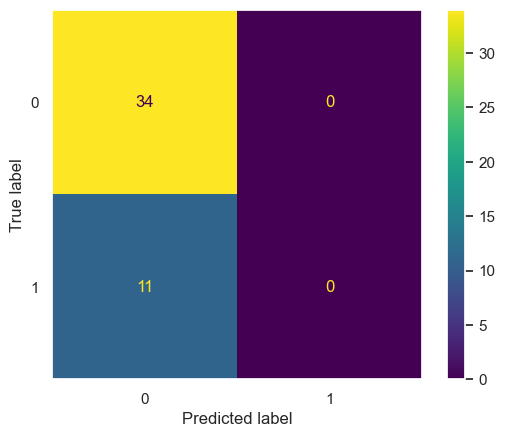

recall :  0.0    precision:  0.0
file :  Umbrella018.csv


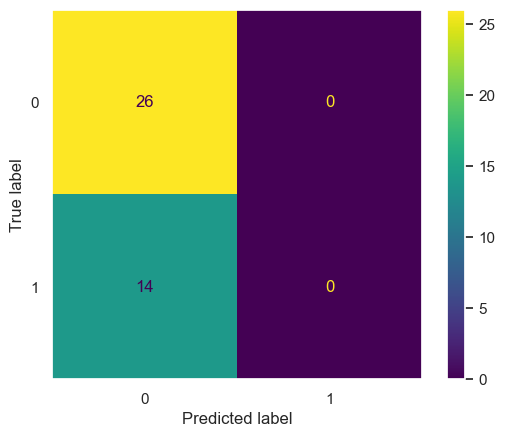

recall :  0.0    precision:  0.0
file :  Umbrella019.csv


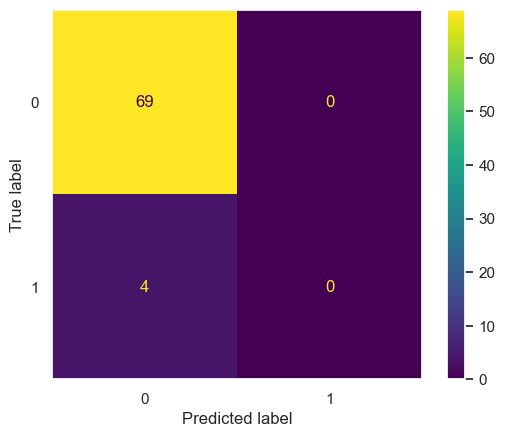

recall :  0.0    precision:  0.0
file :  Umbrella020.csv


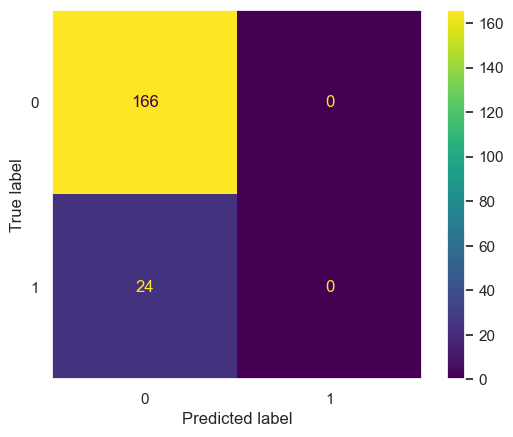

recall :  0.0    precision:  0.0
file :  Umbrella021.csv


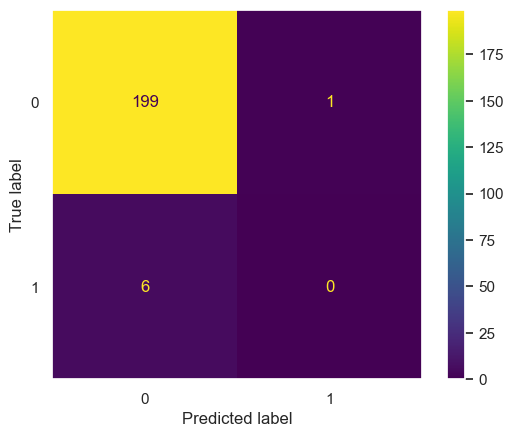

recall :  0.0    precision:  0.0
file :  Umbrella022.csv


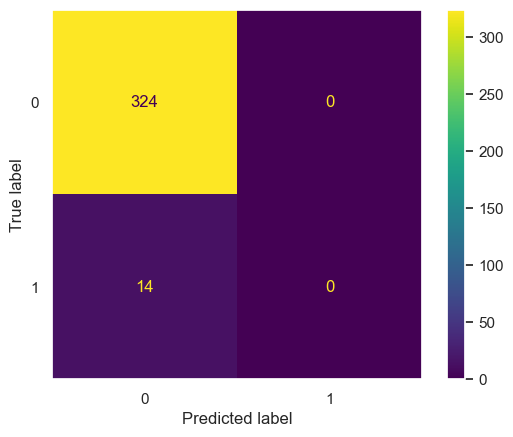

recall :  0.0    precision:  0.0
file :  Umbrella023.csv


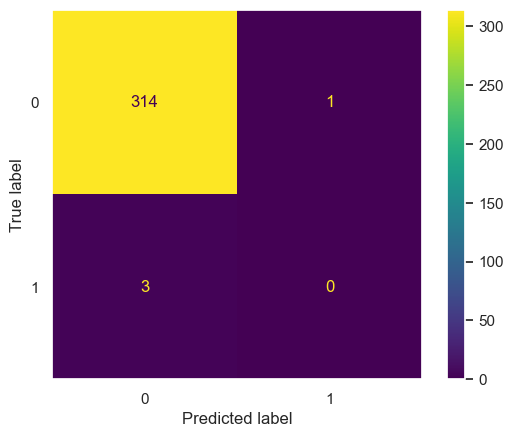

recall :  0.0    precision:  0.0
file :  Umbrella024.csv


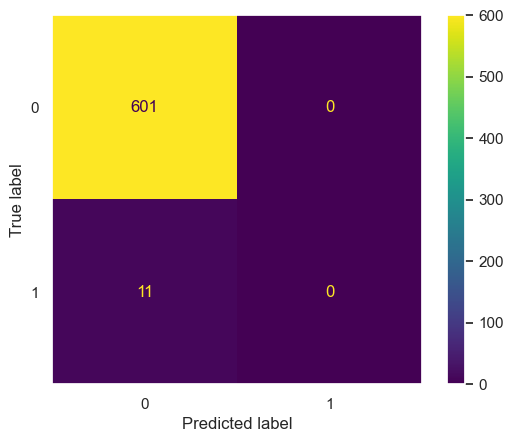

recall :  0.0    precision:  0.0
file :  Umbrella025.csv


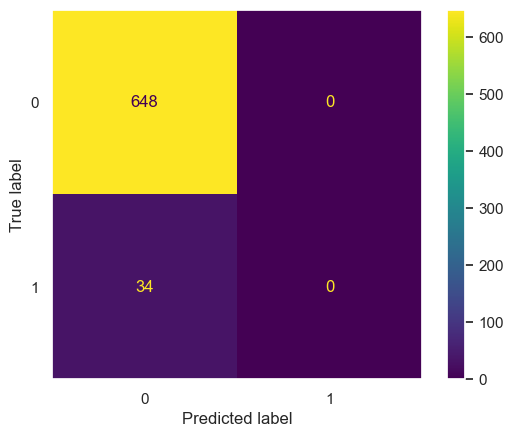

recall :  0.0    precision:  0.0
file :  Umbrella028.csv


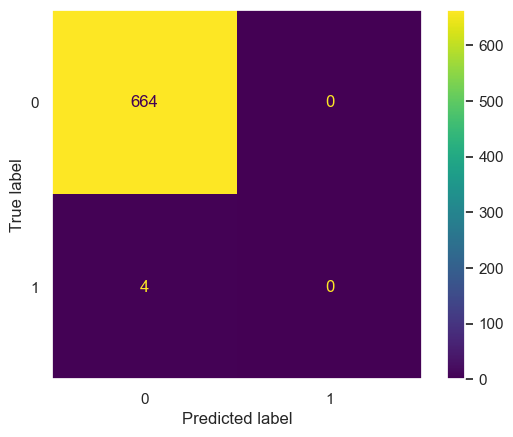

recall :  0.0    precision:  0.0
file :  UniCat.csv


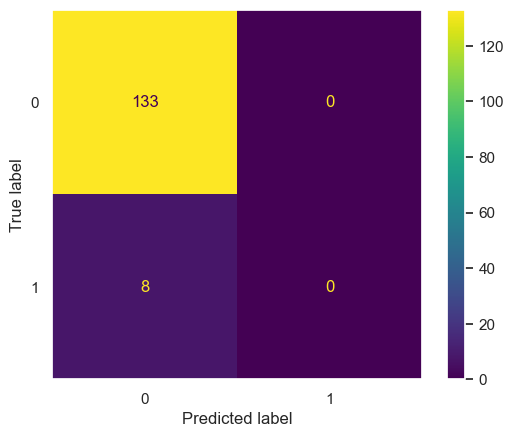

recall :  0.0    precision:  0.0
file :  Unicrypt001.csv


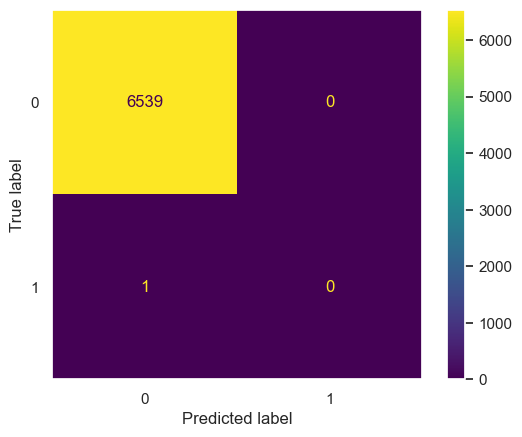

recall :  0.0    precision:  0.0
file :  Unidark001.csv


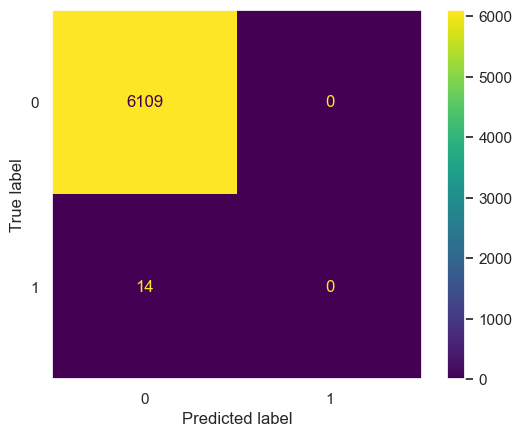

recall :  0.0    precision:  0.0
file :  Uniswap001.csv


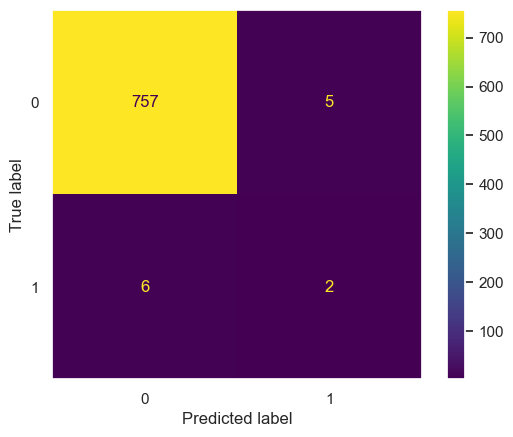

recall :  0.25    precision:  0.2857142857142857
file :  Upbit001.csv


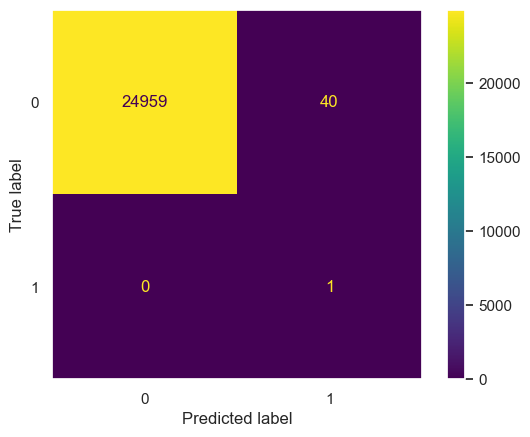

recall :  1.0    precision:  0.024390243902439025
file :  Upbit004.csv


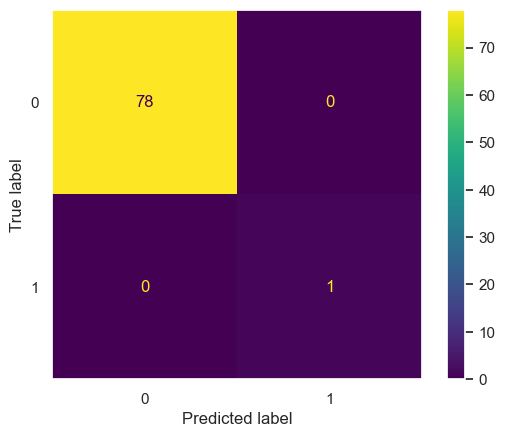

recall :  1.0    precision:  1.0
file :  Upbit005.csv


recall :  0.0    precision:  0.0
file :  Upbit006.csv


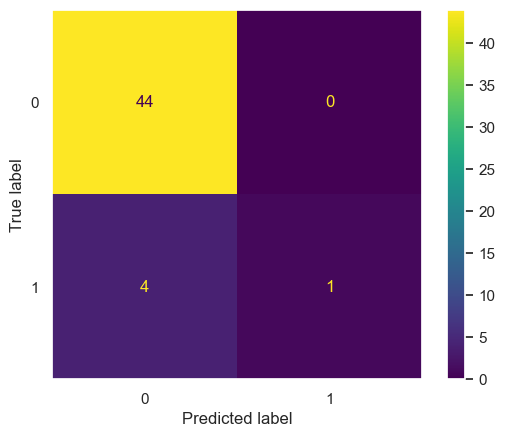

recall :  0.2    precision:  1.0
file :  Upbit008.csv


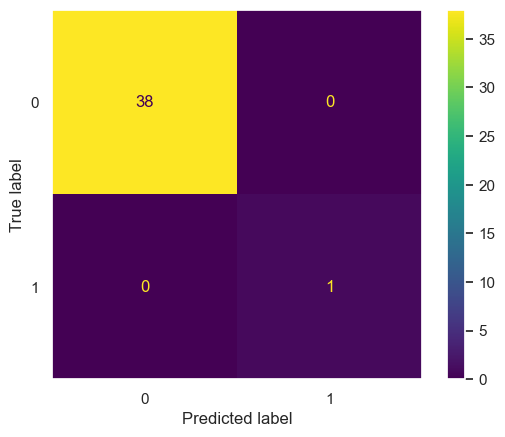

recall :  1.0    precision:  1.0
file :  Upbit009.csv


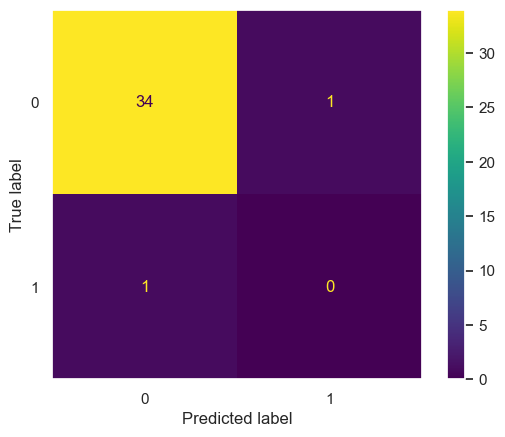

recall :  0.0    precision:  0.0
file :  Upbit7.csv


recall :  0.3333333333333333    precision:  1.0
file :  Vadia Finance001.csv


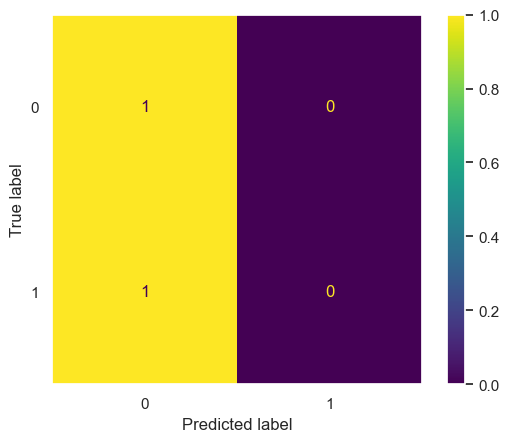

recall :  0.0    precision:  0.0
file :  Vadia Finance002.csv


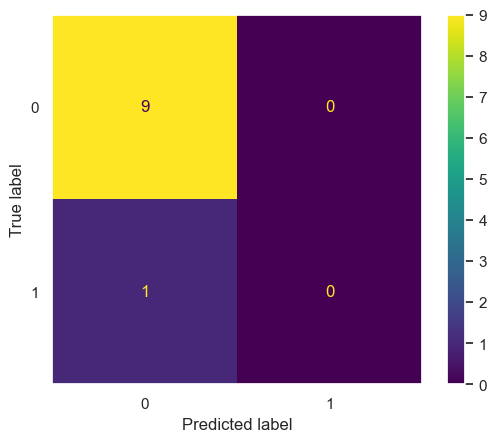

recall :  0.0    precision:  0.0
file :  VeeFinance001.csv


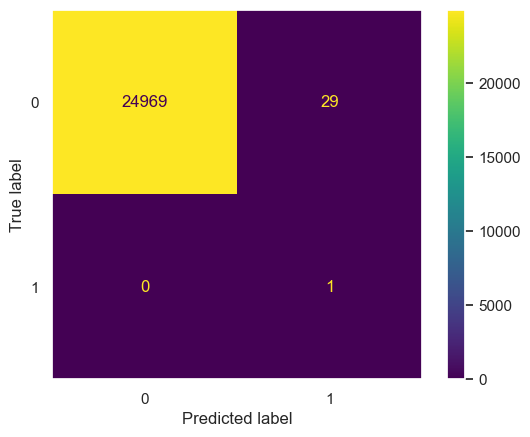

recall :  1.0    precision:  0.03333333333333333
file :  Vesperi001.csv


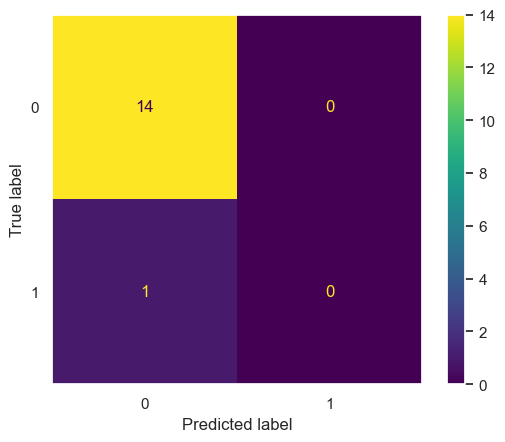

recall :  0.0    precision:  0.0
file :  VulcanForged002.csv


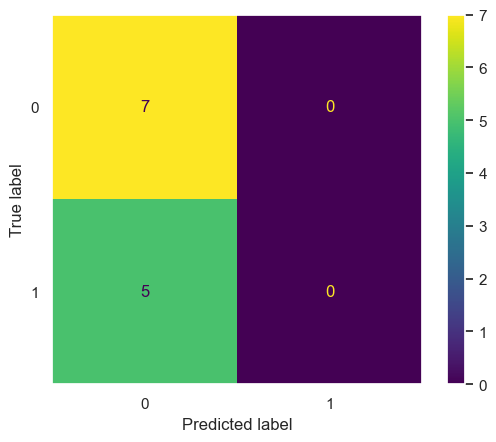

recall :  0.0    precision:  0.0
file :  VulcanForged003.csv


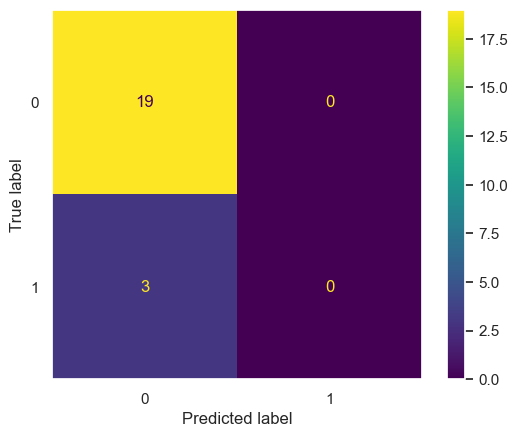

recall :  0.0    precision:  0.0
file :  VulcanForged004.csv


recall :  0.0    precision:  0.0
file :  VulcanForged005.csv


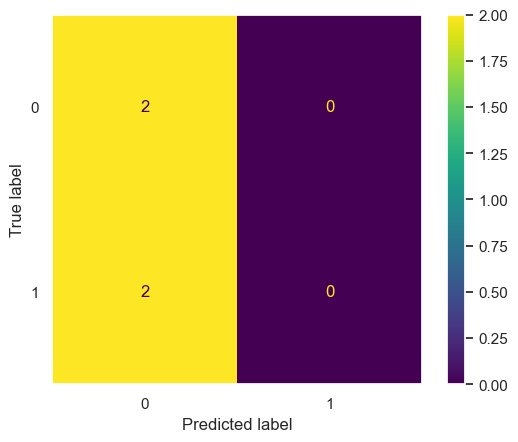

recall :  0.0    precision:  0.0
file :  VulcanForged006.csv


recall :  0.0    precision:  0.0
file :  VulcanForged007.csv


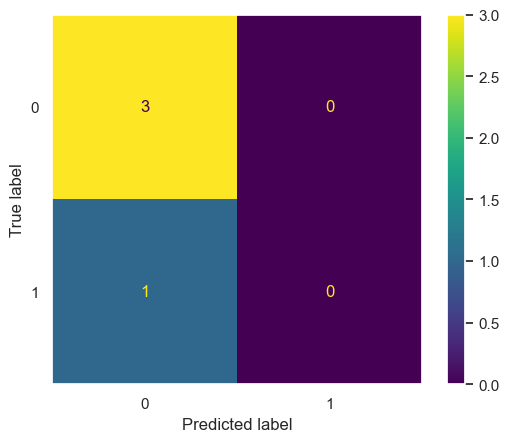

recall :  0.0    precision:  0.0
file :  Warp001.csv


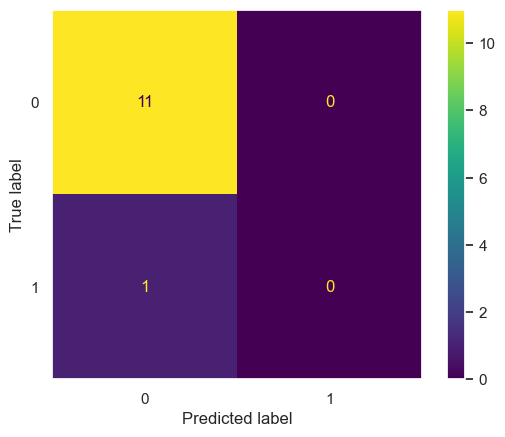

recall :  0.0    precision:  0.0
file :  WildCredit001.csv


recall :  0.0    precision:  0.0
file :  WildCredit002.csv


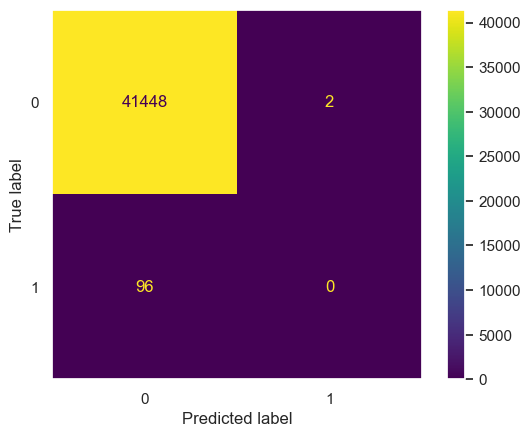

recall :  0.0    precision:  0.0
file :  Wormhole001.csv


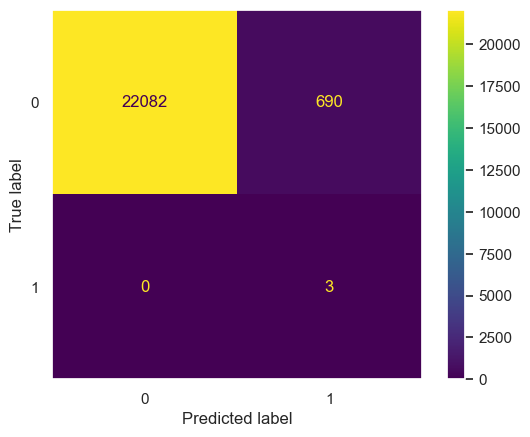

recall :  1.0    precision:  0.004329004329004329
file :  XToken001.csv


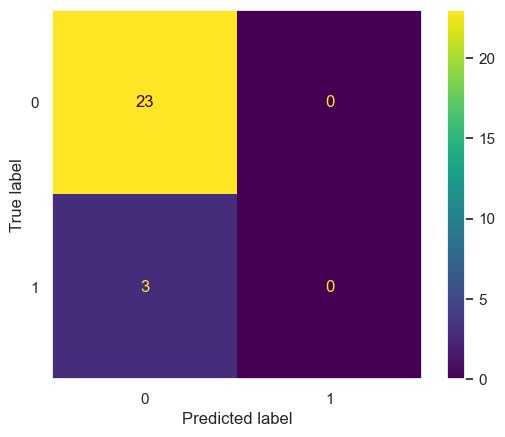

recall :  0.0    precision:  0.0
file :  Zenith001.csv


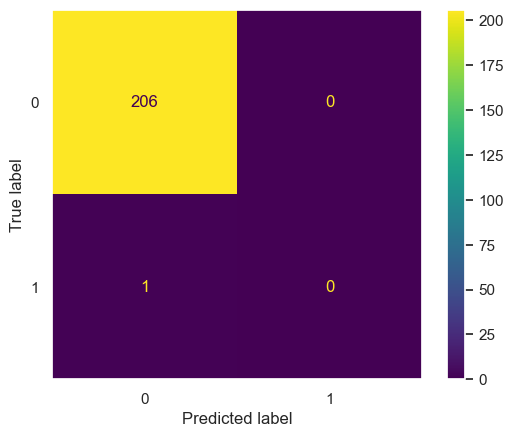

recall :  0.0    precision:  0.0
file :  Zenith002.csv


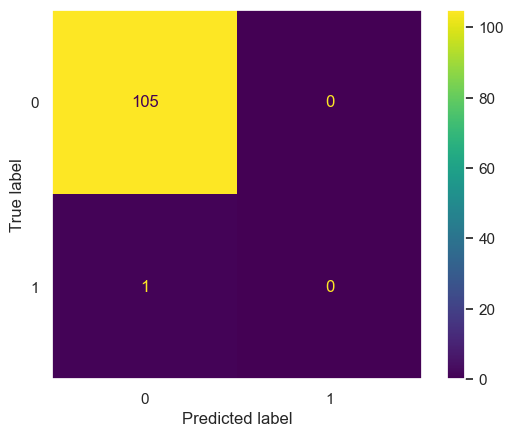

recall :  0.0    precision:  0.0
file :  Zenith003.csv


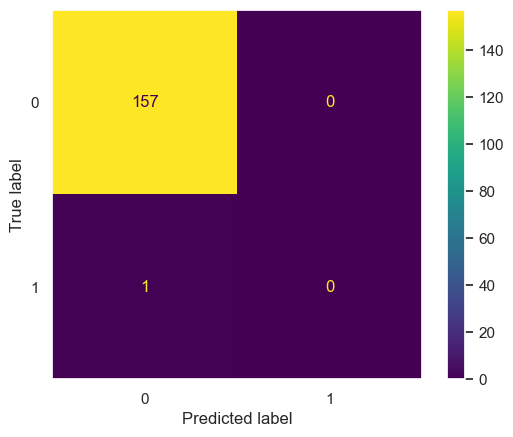

recall :  0.0    precision:  0.0
file :  Zenith004.csv


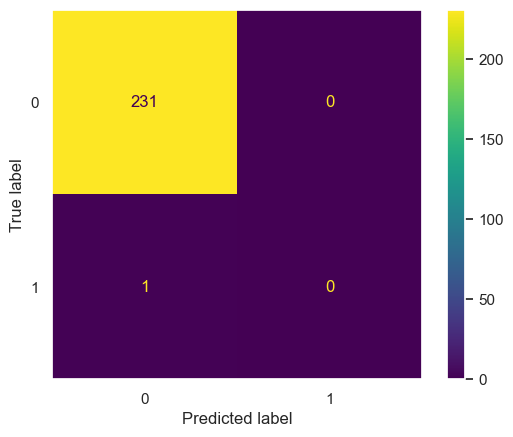

recall :  0.0    precision:  0.0
file :  Zenith005.csv


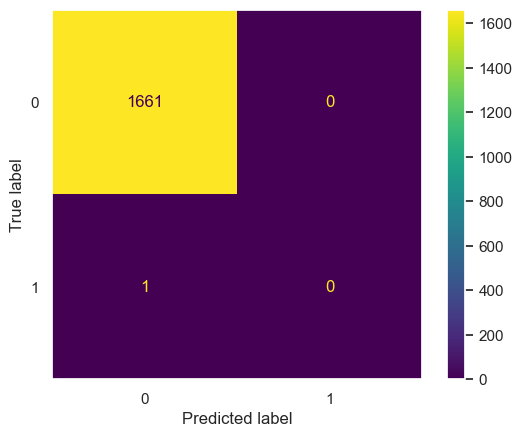

recall :  0.0    precision:  0.0
file :  Zenith006.csv


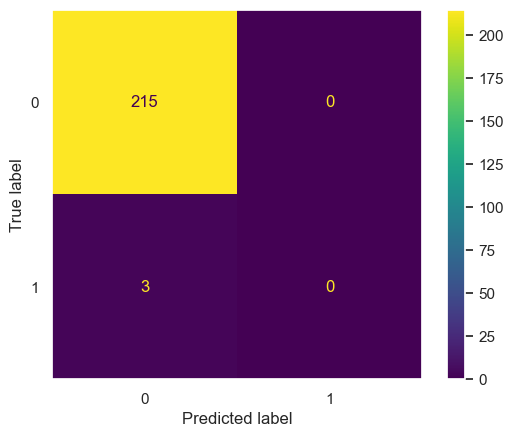

recall :  0.0    precision:  0.0
file :  bZx001.csv


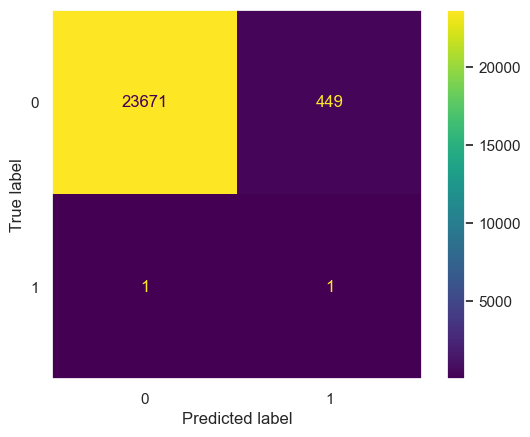

recall :  0.5    precision:  0.0022222222222222222
file :  dxHub001.csv


recall :  0.0    precision:  0.0


In [24]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
results = []
for vTrainIdx, vTestIdx in logo.split(dfData_, dfData_['Label'], groups = dfData_['File Name'].to_list()):#split(X):
    print('file : ' , dfData_.iloc[vTestIdx]['File Name'].to_list()[0])  
    #mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    dft = dfData.iloc[vTestIdx]
    vYPred = f(dft)
    DisplayConfusionMatrix(dft['Label'], vYPred['Alert Rule'], lClasses = [0,1])
    print('recall : ' , recall_score(dft['Label'], vYPred['Alert Rule']), '   precision: ' , precision_score(dft['Label'], vYPred['Alert Rule']))
    results.append({dfData_.iloc[vTestIdx]['File Name'].to_list()[0] : [vYPred,recall_score(dft['Label'], vYPred['Alert Rule'])]})
    #if recall_score(vYTest, vYPred) != 1:
    #    prob_files.append(dfData_.iloc[vTestIdx]['File Name'].to_list()[0])

### K-fold training, using categorical variables (EXPERIMENT)

In [ ]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [ ]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [ ]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


In [ ]:
l_sfs = ['Amount',
 'Gas Price',
 'Gas Used',
 'AMOUNT_SUM_USR',
 'AMOUNT_MEAN_ASSET',
 'AMOUNT_STD_USR',
 'AMOUNT_VAR_USR',
 'AMOUNT_MIN_ASSET',
 'AMOUNT_MIN_USR',
 'AMOUNT_MAX_USR',
 'TIME_DIFF_MEAN_USR',
 'TIME_DIFF_STD_USR',
 'TIME_DIFF_MEDIAN_USR',
 'TIME_DIFF_MIN_ASSET',
 'TIME_DIFF_MIN_USR',
 'TIME_DIFF_MAX_ASSET',
 'TIME_DIFF_MAX_USR',
 'COIN_TYPE_USR_MEAN_ASSET_RATIO',
 'COIN_TYPE_COUNT_USR',
 'RECEIVER_TYPE_COUNT_USR',
 'TIME_HOUR',
 'TIME_WEEKDAY',
 'TIME_INTERVL_USR',
 'TIME_DIFF_STD_RATIO_USR_ASSET',
 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
 'GAS_PRICE_STD_USR',
 'GAS_PRICE_MEDIAN_USR',
 'GAS_USED_MEAN_USR',
 'GAS_USED_STD_ASSET',
 'GAS_USED_STD_USR',
 'MIN_INDICATOR',
 'GAS_PRICE_USR_ASSET_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO',
 'GAS_PRICE_USED_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO_MEAN',
 'GAS_PRICE_QUANTILE_RATIO',
 'GAS_USED_QUANTILE_RATIO',
 'GAS_LIMIT_QUANTILE_RATIO',
 'GAS_PRICE_QUANTILE_USR',
 'GAS_USED_QUANTILE_USR']


In [ ]:
mX = mX[l_sfs]

In [ ]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(mX)


In [ ]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

### Data Split

In [ ]:

if trainMode == TRAIN_BY_FILES:
    hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY, groups = dfData['Sender ID'])
else:
    hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY)


### Model Training

In [ ]:
skPipeline = Pipeline([('clf', XGBClassifier())])
dPipelineParams = {'clf': [XGBClassifier(), LGBMClassifier()]}

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))

### GridSearch and Pipelines combo:


In [ ]:
#skPipeline = Pipeline([('clf', XGBClassifier())])
#dPipelineParams =  {'clf': [XGBClassifier(), LGBMClassifier()]}


skPipeline = Pipeline([("classifier", RandomForestClassifier())])

dPipelineParams = [ {"classifier": [XGBClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__tree_method" : ["hist", "gpu_hist"]
                    },
                    {"classifier": [LGBMClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20]
                                   #"classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    },  
                    {"classifier": [RandomForestClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }                            
                    ]


In [ ]:
##########make sure mX, vY are not redefined into dfs(simply skip K-fold training, using categorical variables (EXPERIMENT) part), naming should be later changed

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
print(gridSearchCvF.best_estimator_.get_params()["classifier"])

In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))